In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'comp4211/'
assert FOLDERNAME is not None, "[1]Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [ ]:
#!unzip "drive/My Drive/comp4211/proj1/archive.zip" -d "drive/My Drive/comp4211/proj1/"

In [ ]:
!ls "drive/My Drive/comp4211/proj1/"

anno_length.csv   df_vgg.csv		  Retina_path.csv
annotations	  df_vgg_ft.csv		  Retina_path_valid.csv
archive.zip	  images		  Retina_valid_path.csv
baseline.pt	  img_Retinaface	  train_split1.csv
baseline_test.pt  modified_res18_ft.pt	  train_split.csv
baseline_tf1.pt   modified_res18.pt	  valid_index.csv
baseline_tf2.pt   modified_vgg_ft.pt	  valid_label_resnet18.csv
baseline_tf3.pt   modified_vgg.pt	  valid_label_vgg.csv
base_para1.pt	  proj1.csv		  valid_split1.csv
base_para2.pt	  proj1_data.csv	  valid_split.csv
clip_images	  proj1_retina_label.csv  valid_truth_label.csv
data_all.csv	  proj1_truth_label.csv
df_base.csv	  Retinaface_annot.csv


##imaging preprocessing

###Face mask dataset on kaggle

In [ ]:
PATH = '/content/drive/My Drive/comp4211/proj1/' 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os
from tqdm.notebook import tqdm
from torch import optim 
# pip install tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#basic function for generating data

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [ ]:
imgs_filename = list(sorted(os.listdir("/content/drive/My Drive/comp4211/proj1/images/")))
labels_filename = list(sorted(os.listdir("/content/drive/My Drive/comp4211/proj1/annotations/")))

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("/content/drive/My Drive/comp4211/proj1/images/")))
        # self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content//drive/My Drive/comp4211/proj1/images/", file_image)
        label_path = os.path.join("/content/drive/My Drive/comp4211/proj1/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])
data_resize = transforms.Compose([transforms.Resize((32,32)),
        transforms.ToTensor(), 
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
dataset_resize = MaskDataset(data_resize)
data_loader = torch.utils.data.DataLoader(
dataset, batch_size=4, collate_fn=collate_fn)
data_loader_demo = torch.utils.data.DataLoader(
dataset_resize, batch_size=64, collate_fn=collate_fn)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!ls '/content/drive/My Drive/comp4211/proj1/images/maksssksksss0.png'

'/content/drive/My Drive/comp4211/proj1/images/maksssksksss0.png'


In [ ]:
for imgs, annotations in data_loader:
  print(imgs)
  imgs = list(img.to(device) for img in imgs)
  annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
  print(annotations)
  break

(tensor([[[0.4431, 0.4314, 0.3843,  ..., 0.1569, 0.2824, 0.3373],
         [0.4118, 0.3882, 0.3451,  ..., 0.1529, 0.1882, 0.3098],
         [0.3765, 0.3569, 0.3255,  ..., 0.1490, 0.1216, 0.2784],
         ...,
         [0.3333, 0.3412, 0.3569,  ..., 0.1098, 0.1098, 0.1137],
         [0.3373, 0.3490, 0.3608,  ..., 0.1137, 0.1137, 0.1176],
         [0.3647, 0.3765, 0.3922,  ..., 0.1176, 0.1176, 0.1216]],

        [[0.4353, 0.4235, 0.3765,  ..., 0.2314, 0.3843, 0.4549],
         [0.3922, 0.3804, 0.3373,  ..., 0.2275, 0.2863, 0.4275],
         [0.3608, 0.3412, 0.3098,  ..., 0.2235, 0.2235, 0.3922],
         ...,
         [0.3255, 0.3333, 0.3490,  ..., 0.1059, 0.1059, 0.1098],
         [0.3294, 0.3412, 0.3529,  ..., 0.1098, 0.1098, 0.1137],
         [0.3569, 0.3686, 0.3843,  ..., 0.1137, 0.1137, 0.1176]],

        [[0.4549, 0.4431, 0.3961,  ..., 0.4000, 0.6157, 0.7294],
         [0.4157, 0.3922, 0.3490,  ..., 0.3843, 0.5059, 0.6784],
         [0.3647, 0.3451, 0.3137,  ..., 0.3529, 0.4118, 0

In [ ]:
'''
plt.figure(figsize = (12,14))

count = 1
for input, labels in tqdm(data_loader_demo):
  if count == 121:
      break
  for i in range(0,64):
    if count == 121:
      break
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace =0, hspace =0)
    plt.subplot(12,10,count)
    plt.axis('off')
    plt.imshow(input[i].permute(1, 2, 0))
    count+=1
plt.show()
'''

"\nplt.figure(figsize = (12,14))\n\ncount = 1\nfor input, labels in tqdm(data_loader_demo):\n  if count == 121:\n      break\n  for i in range(0,64):\n    if count == 121:\n      break\n    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace =0, hspace =0)\n    plt.subplot(12,10,count)\n    plt.axis('off')\n    plt.imshow(input[i].permute(1, 2, 0))\n    count+=1\nplt.show()\n"

In [ ]:
import matplotlib.pyplot as plt
def plot_image(img_tensor, annotation):
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    i = 0
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box
        lab =  annotation["labels"][i]
        text = ''
        if lab == 1:
          text = "with_mask"
        elif lab == 0:
          text = "without_mask"
        else:
          text = "mask_weared_incorrect"
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        plt.text(xmin, ymin, text, color = "red")
        # Add the patch to the Axes
        ax.add_patch(rect)
        i+=1
        
        
    plt.show()

Images demo


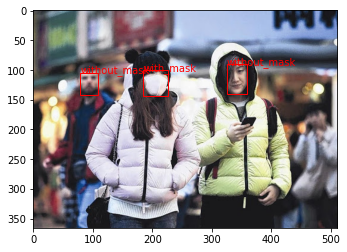

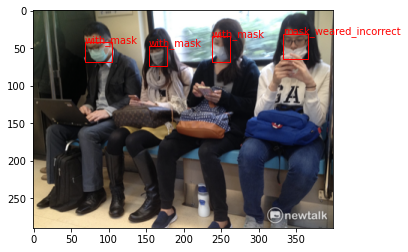

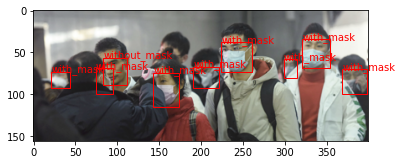

In [ ]:
print("Images demo")


plot_image(imgs[0], annotations[0])
plot_image(imgs[2], annotations[2])
plot_image(imgs[1], annotations[1])

###clip the images

In [ ]:
len(imgs_filename)

853

In [ ]:
#clip the image
import PIL.Image as img
import os
'''
labels = []
count = 0
for i in tqdm(range(len(imgs_filename))):
  file_image = 'maksssksksss'+ str(i) + '.png'
  file_label = 'maksssksksss'+ str(i) + '.xml'
  img_path = os.path.join("/content//drive/My Drive/comp4211/proj1/images/", file_image)
  label_path = os.path.join("/content/drive/My Drive/comp4211/proj1/annotations/", file_label)
  img = Image.open(img_path).convert("RGB")
  #Generate Label
  annot = generate_target(i, label_path)
  label = annot["labels"]
  labels.append(label.tolist())


  #clip the image
  box = annot["boxes"]
  for box_range in box:
    box_range = torch.tensor(box_range,dtype=torch.int32)
    #print(box_range.tolist())
    clip_img = img.crop(box_range.tolist())
    clip_img.save('/content/drive/My Drive/comp4211/proj1/clip_images/mask{}.png'.format(count))
    count+=1
'''


'\nlabels = []\ncount = 0\nfor i in tqdm(range(len(imgs_filename))):\n  file_image = \'maksssksksss\'+ str(i) + \'.png\'\n  file_label = \'maksssksksss\'+ str(i) + \'.xml\'\n  img_path = os.path.join("/content//drive/My Drive/comp4211/proj1/images/", file_image)\n  label_path = os.path.join("/content/drive/My Drive/comp4211/proj1/annotations/", file_label)\n  img = Image.open(img_path).convert("RGB")\n  #Generate Label\n  annot = generate_target(i, label_path)\n  label = annot["labels"]\n  labels.append(label.tolist())\n\n\n  #clip the image\n  box = annot["boxes"]\n  for box_range in box:\n    box_range = torch.tensor(box_range,dtype=torch.int32)\n    #print(box_range.tolist())\n    clip_img = img.crop(box_range.tolist())\n    clip_img.save(\'/content/drive/My Drive/comp4211/proj1/clip_images/mask{}.png\'.format(count))\n    count+=1\n'

In [ ]:
#generate label
'''
labels = []
for j in tqdm(range(len(imgs_filename))):
  #file_image = 'maksssksksss'+ str(i) + '.png'
  file_label = 'maksssksksss'+ str(j) + '.xml'
  #img_path = os.path.join("/content//drive/My Drive/comp4211/proj1/images/", file_image)
  label_path = os.path.join("/content/drive/My Drive/comp4211/proj1/annotations/", file_label)
  #img = Image.open(img_path).convert("RGB")
  
  #Generate Label
  annot = generate_target(j, label_path)
  label = annot["labels"]
  labels.append(label.tolist())
'''

'\nlabels = []\nfor j in tqdm(range(len(imgs_filename))):\n  #file_image = \'maksssksksss\'+ str(i) + \'.png\'\n  file_label = \'maksssksksss\'+ str(j) + \'.xml\'\n  #img_path = os.path.join("/content//drive/My Drive/comp4211/proj1/images/", file_image)\n  label_path = os.path.join("/content/drive/My Drive/comp4211/proj1/annotations/", file_label)\n  #img = Image.open(img_path).convert("RGB")\n  \n  #Generate Label\n  annot = generate_target(j, label_path)\n  label = annot["labels"]\n  labels.append(label.tolist())\n'

In [ ]:
#processing the label
'''
labels_data = [b for a in labels for b in a]
print(labels)
print(labels_data)
'''

'\nlabels_data = [b for a in labels for b in a]\nprint(labels)\nprint(labels_data)\n'

In [ ]:
from pandas.core.frame import DataFrame
'''
df = DataFrame(labels_data)
df.to_csv('/content/drive/My Drive/comp4211/proj1/proj1.csv', header=False, index=False)
df
'''

"\ndf = DataFrame(labels_data)\ndf.to_csv('/content/drive/My Drive/comp4211/proj1/proj1.csv', header=False, index=False)\ndf\n"

In [ ]:
'''
from pandas.core.frame import DataFrame
#generating dataframe dataset
img_clip_path = []
imgs_clip_filename = list(sorted(os.listdir("/content/drive/My Drive/comp4211/proj1/clip_images/")))
for i in tqdm(range(len(imgs_clip_filename))):
  file_image = 'mask'+ str(i) + '.png'
  img_clip_path.append(file_image)

df_img_path = DataFrame(img_clip_path)

'''

'\nfrom pandas.core.frame import DataFrame\n#generating dataframe dataset\nimg_clip_path = []\nimgs_clip_filename = list(sorted(os.listdir("/content/drive/My Drive/comp4211/proj1/clip_images/")))\nfor i in tqdm(range(len(imgs_clip_filename))):\n  file_image = \'mask\'+ str(i) + \'.png\'\n  img_clip_path.append(file_image)\n\ndf_img_path = DataFrame(img_clip_path)\n\n'

In [ ]:
'''
df_img_path
'''

'\ndf_img_path\n'

In [ ]:
'''
df_data = pd.concat([df_img_path, df_label], axis=1)
df_data.columns = ['img_name','label']
df_data.to_csv('/content/drive/My Drive/comp4211/proj1/proj1_data.csv', header=False, index=False)
df_data
'''

"\ndf_data = pd.concat([df_img_path, df_label], axis=1)\ndf_data.columns = ['img_name','label']\ndf_data.to_csv('/content/drive/My Drive/comp4211/proj1/proj1_data.csv', header=False, index=False)\ndf_data\n"

In [ ]:
imgs_clip_filename = list(sorted(os.listdir("/content/drive/My Drive/comp4211/proj1/clip_images/")))
len(imgs_clip_filename)

4072

##dataset and dataloader

In [ ]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from torch import optim 
# pip install tqdm

data_path_train = '/content/drive/My Drive/comp4211/proj1/proj1_data.csv'
df_dataset = pd.read_csv(data_path_train)
df_dataset

img_name  label
0        mask0.png      0
1        mask1.png      1
2        mask2.png      0
3        mask3.png      1
4        mask4.png      1
...            ...    ...
4067  mask4067.png      1
4068  mask4068.png      1
4069  mask4069.png      1
4070  mask4070.png      1
4071  mask4071.png      0

[4072 rows x 2 columns]

In [ ]:
train, valid = df_dataset.iloc[814:], df_dataset.iloc[0:814]

data_train_path = os.path.join(PATH, 'train_split1.csv')
data_valid_path = os.path.join(PATH, 'valid_split1.csv')

train.to_csv(data_train_path, header=True, index=False)
valid.to_csv(data_valid_path, header=True, index=False)

In [ ]:
train

img_name  label
814    mask814.png      1
815    mask815.png      0
816    mask816.png      0
817    mask817.png      1
818    mask818.png      1
...            ...    ...
4067  mask4067.png      1
4068  mask4068.png      1
4069  mask4069.png      1
4070  mask4070.png      1
4071  mask4071.png      0

[3258 rows x 2 columns]

In [ ]:
valid

img_name  label
0      mask0.png      0
1      mask1.png      1
2      mask2.png      0
3      mask3.png      1
4      mask4.png      1
..           ...    ...
809  mask809.png      0
810  mask810.png      0
811  mask811.png      0
812  mask812.png      1
813  mask813.png      1

[814 rows x 2 columns]

In [ ]:
'''
img_order = []
box_order= []
box_anno = []
name = []
count = 0
for i in tqdm(range(len(imgs_filename))):
  file_label = 'maksssksksss'+ str(i) + '.xml'
  label_path = os.path.join("/content/drive/My Drive/comp4211/proj1/annotations/", file_label)
  #Generate Label
  annot = generate_target(i, label_path)
  #clip the image
  box = annot["boxes"]
  count2 = 0
  for box_range in box:
    name.append('mask{}.png'.format(count)) 
    img_order.append(i)
    box_order.append(count2)
    box_anno.append(box_range.tolist())
    count2+=1
    count+=1
    '''

'\nimg_order = []\nbox_order= []\nbox_anno = []\nname = []\ncount = 0\nfor i in tqdm(range(len(imgs_filename))):\n  file_label = \'maksssksksss\'+ str(i) + \'.xml\'\n  label_path = os.path.join("/content/drive/My Drive/comp4211/proj1/annotations/", file_label)\n  #Generate Label\n  annot = generate_target(i, label_path)\n  #clip the image\n  box = annot["boxes"]\n  count2 = 0\n  for box_range in box:\n    name.append(\'mask{}.png\'.format(count)) \n    img_order.append(i)\n    box_order.append(count2)\n    box_anno.append(box_range.tolist())\n    count2+=1\n    count+=1\n    '

In [ ]:
class MaskDataset_clip(object):
    def __init__(self, csv_file,transforms = None):
        self.transforms = transforms
        self.labels_data = pd.read_csv(csv_file)
        self.imgs_clip = list(sorted(os.listdir("/content/drive/My Drive/comp4211/proj1/clip_images/")))
        

    def __getitem__(self, idx):
        # load images ad mask
        #print("idx",idx)
        file_image = self.labels_data.iloc[idx, 0]
        #print("file_image",file_image)
        img_clip_path = os.path.join("/content/drive/My Drive/comp4211/proj1/clip_images/", file_image)
        label =  self.labels_data.iloc[idx, 1]
        #label = torch.zeros(64,3).scatter_(1,label,1)
        #print("label",label)
        img = Image.open(img_clip_path).convert("RGB")
       
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, label

    def __len__(self):
        return len(self.labels_data)

In [ ]:
transf = transforms.Compose(
    [transforms.Resize((32,32)), transforms.ToTensor(),transforms.Grayscale(num_output_channels=1)])

#transf = transforms.Compose(
    #[transforms.Resize((32,32)), transforms.ToTensor()])

train_dataest = MaskDataset_clip(data_train_path, transforms=transf)
valid_dataest = MaskDataset_clip(data_valid_path, transforms=transf)

bs = 64

train_loader = DataLoader(train_dataest, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataest, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
'''
plt.figure(figsize = (12,14))

count = 1
for input, labels in tqdm(train_loader):
  if count == 121:
      break
  for i in range(0,64):
    if count == 121:
      break
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace =0, hspace =0)
    plt.subplot(12,10,count)
    plt.axis('off')
    #img = Image.open(input).convert("RGB")
    plt.imshow(input[i].permute(1, 2, 0))
    count+=1
plt.show()
'''

'\nplt.figure(figsize = (12,14))\n\ncount = 1\nfor input, labels in tqdm(train_loader):\n  if count == 121:\n      break\n  for i in range(0,64):\n    if count == 121:\n      break\n    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace =0, hspace =0)\n    plt.subplot(12,10,count)\n    plt.axis(\'off\')\n    #img = Image.open(input).convert("RGB")\n    plt.imshow(input[i].permute(1, 2, 0))\n    count+=1\nplt.show()\n'

In [ ]:
len(train_loader)

51

In [ ]:
len(valid_loader)

814

In [ ]:
train_dataest.__getitem__(1)
print(valid_dataest.__getitem__(100))

(tensor([[[0.0109, 0.0419, 0.1570,  ..., 0.6511, 0.7992, 0.5976],
         [0.0299, 0.0996, 0.2777,  ..., 0.4416, 0.5386, 0.5207],
         [0.0473, 0.1791, 0.3671,  ..., 0.2026, 0.4105, 0.4989],
         ...,
         [0.3573, 0.3103, 0.3559,  ..., 0.3876, 0.4989, 0.5786],
         [0.4843, 0.4965, 0.5684,  ..., 0.3986, 0.5624, 0.5142],
         [0.4470, 0.6338, 0.7569,  ..., 0.4250, 0.6134, 0.4736]]]), 1)


#Baseline Model & Training

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.cnn_model = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2, 2, padding=0),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.AvgPool2d(16, 16)
        )
    
        d_in, d_out = 512, 3
        
        self.fc_layer = nn.Sequential(
            nn.Linear(d_in, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, d_out),
            nn.Sigmoid()

        )



    def forward(self, x):
    
        # out_dim = in_dim - kernel_size + 1  
        x = self.cnn_model(x)    
        x = x.view(-1,512)
        #x= x.float()

        x = self.fc_layer(x)
        #x= x.float()
        return x


In [ ]:
# print model
baseline = Baseline().to(device)

baseline

Baseline(
  (cnn_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
!pip install torchsummaryX

In [ ]:
from torchsummaryX import summary

model = Baseline().cuda()
summary(model, torch.zeros((64,1, 32, 32)).cuda())

                                 Kernel Shape       Output Shape    Params  \
Layer                                                                        
0_cnn_model.Conv2d_0            [1, 32, 3, 3]   [64, 32, 32, 32]     320.0   
1_cnn_model.BatchNorm2d_1                [32]   [64, 32, 32, 32]      64.0   
2_cnn_model.ReLU_2                          -   [64, 32, 32, 32]         -   
3_cnn_model.Conv2d_3           [32, 32, 3, 3]   [64, 32, 32, 32]    9.248k   
4_cnn_model.BatchNorm2d_4                [32]   [64, 32, 32, 32]      64.0   
5_cnn_model.ReLU_5                          -   [64, 32, 32, 32]         -   
6_cnn_model.MaxPool2d_6                     -   [64, 32, 16, 16]         -   
7_cnn_model.Conv2d_7           [32, 64, 3, 3]   [64, 64, 16, 16]   18.496k   
8_cnn_model.BatchNorm2d_8                [64]   [64, 64, 16, 16]     128.0   
9_cnn_model.ReLU_9                          -   [64, 64, 16, 16]         -   
10_cnn_model.Conv2d_10        [64, 128, 3, 3]  [64, 128, 16, 16]

Kernel Shape  ...    Mult-Adds
Layer                                          ...             
0_cnn_model.Conv2d_0            [1, 32, 3, 3]  ...     294912.0
1_cnn_model.BatchNorm2d_1                [32]  ...         32.0
2_cnn_model.ReLU_2                          -  ...          NaN
3_cnn_model.Conv2d_3           [32, 32, 3, 3]  ...    9437184.0
4_cnn_model.BatchNorm2d_4                [32]  ...         32.0
5_cnn_model.ReLU_5                          -  ...          NaN
6_cnn_model.MaxPool2d_6                     -  ...          NaN
7_cnn_model.Conv2d_7           [32, 64, 3, 3]  ...    4718592.0
8_cnn_model.BatchNorm2d_8                [64]  ...         64.0
9_cnn_model.ReLU_9                          -  ...          NaN
10_cnn_model.Conv2d_10        [64, 128, 3, 3]  ...   18874368.0
11_cnn_model.BatchNorm2d_11             [128]  ...        128.0
12_cnn_model.ReLU_12                        -  ...          NaN
13_cnn_model.Conv2d_13       [128, 256, 3, 3]  ...   75497472.0
14_cnn_model.BatchNorm2d_14             [256]  ...        256.0
15_cnn_model.ReLU_15                        -  ...          NaN
16_cnn_model.Conv2d_16       [256, 512, 3, 3]  ...  301989888.0
17_cnn_model.BatchNorm2d_17             [512]  ...        512.0
18_cnn_model.ReLU_18                        -  ...          NaN
19_cnn_model.AvgPool2d_19                   -  ...          NaN
20_fc_layer.Linear_0               [512, 512]  ...     262144.0
21_fc_layer.ReLU_1                          -  ...          NaN
22_fc_layer.Dropout_2                       -  ...          NaN
23_fc_layer.Linear_3                 [512, 3]  ...       1536.0
24_fc_layer.Sigmoid_4                       -  ...          NaN

[25 rows x 4 columns]

###Training

In [ ]:
from tqdm.notebook import tqdm
from torch import optim 
# pip install tqdm

def save_checkpoint(save_path, model, optimizer, val_accu):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_accu': val_accu}

    torch.save(state_dict, save_path)
    print(f'Model saved to {save_path}')


def load_checkpoint(save_path, model, optimizer):
    save_path = save_path 
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_accu = state_dict['val_accu']
    print(f'Model loaded from {save_path}, with val loss: {val_accu}')
    return val_accu


def TRAIN(net, train_loader, valid_loader,  num_epochs, criterion, optimizer, valid_acc, device, save_name):
    

    step_axis = []
    train_loss_line = []
    valid_loss_line = []
    train_accu_line = []
    valid_accu_line = []

  
    if valid_acc==None:
      best_val_accu = float(0.0)  
    else: 
      best_val_accu=valid_acc
      print('Resume training')


    step = 0
    running_loss = 0.0
    train_corrects = 0

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        net.train()
      
        
        for input, labels in tqdm(train_loader):
            net.train()
            input = input.to(device)
            labels = labels.to(device)
            #labels = torch.unsqueeze(1,labels)
            
 
            '''Training of the model'''
            # Forward pass
            outputs = net(input)
            #labels = labels.view(1,-1)
            #print("outputs",outputs)
            #print("labels",labels)

            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            train_corrects += torch.sum(preds == labels.data)

            step +=1
            #counter +=1

            if step%10 == 0:
              step_axis.append(step)
    
              with torch.no_grad():
                net.eval()
                running_loss_v = 0
                valid_corrects = 0
                for input, labels in tqdm(valid_loader):
                  input = input.to(device)
                  labels = labels.to(device)
                  #labels = torch.unsqueeze(labels, 1)
             
                  outputs = net(input)

                  loss = criterion(outputs, labels)
                  running_loss_v += loss.item()
                  _, preds = torch.max(outputs.data, 1)
                  #print("preds",preds)
                  valid_corrects += torch.sum(preds == labels.data)
                  #print(labels.data)

                valid_loss = running_loss_v / len(valid_loader)
                valid_acc = valid_corrects / float(len(valid_loader.dataset))
                valid_loss_line.append(valid_loss)
                valid_accu_line.append(valid_acc)
                
                '''
                if valid_loss < best_val_loss:
                  best_val_loss = valid_loss
                  save_checkpoint(save_name, net, optimizer, best_val_loss)
                '''
                #save best model
                if valid_acc > best_val_accu:
                  best_val_accu = valid_acc
                  save_checkpoint(save_name, net, optimizer, best_val_accu)
              
              train_loss = running_loss / 10
              train_loss_line.append(train_loss)
              train_acc = train_corrects /1280
              train_accu_line.append(train_acc)



              print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))

              running_loss = 0.0
              train_corrects = 0

    print('Finished Training')


    return  step_axis,train_loss_line,valid_loss_line,train_accu_line, valid_accu_line



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


model = Baseline().to(device)
num_epochs = 20
best_val_accu = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
save_path = f'/content/drive/My Drive/comp4211/proj1/baseline.pt'

step_axis_base,train_loss_line_base,valid_loss_line_base,train_accu_line_base, valid_accu_line_base = TRAIN(model, train_loader, valid_loader, num_epochs, criterion, optimizer, best_val_accu, device, save_path)

cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [1/20], Train Loss: 0.8282, Train Acc: 0.7125, Valid Loss: 0.8267,  Valid Acc: 0.7936



Epoch [1/20], Train Loss: 0.7131, Train Acc: 0.8141, Valid Loss: 0.8740,  Valid Acc: 0.7936



Epoch [1/20], Train Loss: 0.7240, Train Acc: 0.7766, Valid Loss: 0.7354,  Valid Acc: 0.7936



Epoch [1/20], Train Loss: 0.7066, Train Acc: 0.8000, Valid Loss: 0.7370,  Valid Acc: 0.7936



Epoch [1/20], Train Loss: 0.6992, Train Acc: 0.7953, Valid Loss: 0.7280,  Valid Acc: 0.7936




Epoch [2/20], Train Loss: 0.7138, Train Acc: 0.7844, Valid Loss: 0.7229,  Valid Acc: 0.7936



Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [2/20], Train Loss: 0.6885, Train Acc: 0.8313, Valid Loss: 0.7173,  Valid Acc: 0.8010



Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [2/20], Train Loss: 0.6807, Train Acc: 0.8578, Valid Loss: 0.7164,  Valid Acc: 0.8182



Epoch [2/20], Train Loss: 0.6941, Train Acc: 0.8609, Valid Loss: 0.7153,  Valid Acc: 0.8170



Epoch [2/20], Train Loss: 0.6997, Train Acc: 0.8391, Valid Loss: 0.7315,  Valid Acc: 0.8034




Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [3/20], Train Loss: 0.6963, Train Acc: 0.8469, Valid Loss: 0.7095,  Valid Acc: 0.8219



Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [3/20], Train Loss: 0.6787, Train Acc: 0.8781, Valid Loss: 0.7226,  Valid Acc: 0.8231



Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [3/20], Train Loss: 0.6759, Train Acc: 0.8672, Valid Loss: 0.7120,  Valid Acc: 0.8317



Epoch [3/20], Train Loss: 0.6787, Train Acc: 0.8672, Valid Loss: 0.7116,  Valid Acc: 0.8243



Epoch [3/20], Train Loss: 0.6801, Train Acc: 0.8641, Valid Loss: 0.7462,  Valid Acc: 0.7924




Epoch [4/20], Train Loss: 0.6687, Train Acc: 0.8750, Valid Loss: 0.7366,  Valid Acc: 0.8059



Epoch [4/20], Train Loss: 0.6640, Train Acc: 0.8734, Valid Loss: 0.7166,  Valid Acc: 0.8206



Epoch [4/20], Train Loss: 0.6439, Train Acc: 0.8984, Valid Loss: 0.7261,  Valid Acc: 0.8170



Epoch [4/20], Train Loss: 0.6930, Train Acc: 0.8500, Valid Loss: 0.7046,  Valid Acc: 0.8317



Epoch [4/20], Train Loss: 0.6632, Train Acc: 0.8766, Valid Loss: 0.7255,  Valid Acc: 0.8182




Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [5/20], Train Loss: 0.6746, Train Acc: 0.8625, Valid Loss: 0.6974,  Valid Acc: 0.8329



Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [5/20], Train Loss: 0.6513, Train Acc: 0.8969, Valid Loss: 0.6930,  Valid Acc: 0.8489



Epoch [5/20], Train Loss: 0.6763, Train Acc: 0.8625, Valid Loss: 0.7482,  Valid Acc: 0.7998



Epoch [5/20], Train Loss: 0.6757, Train Acc: 0.8734, Valid Loss: 0.7360,  Valid Acc: 0.8047



Epoch [5/20], Train Loss: 0.6557, Train Acc: 0.8906, Valid Loss: 0.6988,  Valid Acc: 0.8391




Epoch [6/20], Train Loss: 0.6745, Train Acc: 0.8625, Valid Loss: 0.7138,  Valid Acc: 0.8243



Epoch [6/20], Train Loss: 0.6375, Train Acc: 0.9047, Valid Loss: 0.7052,  Valid Acc: 0.8354



Epoch [6/20], Train Loss: 0.6642, Train Acc: 0.8766, Valid Loss: 0.7079,  Valid Acc: 0.8292



Epoch [6/20], Train Loss: 0.6563, Train Acc: 0.8891, Valid Loss: 0.7035,  Valid Acc: 0.8256



Epoch [6/20], Train Loss: 0.6552, Train Acc: 0.8844, Valid Loss: 0.7067,  Valid Acc: 0.8280




Epoch [7/20], Train Loss: 0.6714, Train Acc: 0.8703, Valid Loss: 0.7205,  Valid Acc: 0.8133



Epoch [7/20], Train Loss: 0.6632, Train Acc: 0.8781, Valid Loss: 0.7459,  Valid Acc: 0.7973



Epoch [7/20], Train Loss: 0.6485, Train Acc: 0.8938, Valid Loss: 0.7307,  Valid Acc: 0.8047



Epoch [7/20], Train Loss: 0.6692, Train Acc: 0.8750, Valid Loss: 0.7210,  Valid Acc: 0.8120



Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [7/20], Train Loss: 0.6517, Train Acc: 0.8875, Valid Loss: 0.6880,  Valid Acc: 0.8501




Epoch [8/20], Train Loss: 0.6511, Train Acc: 0.8922, Valid Loss: 0.6961,  Valid Acc: 0.8366



Epoch [8/20], Train Loss: 0.6545, Train Acc: 0.8953, Valid Loss: 0.7157,  Valid Acc: 0.8243



Epoch [8/20], Train Loss: 0.6623, Train Acc: 0.8797, Valid Loss: 0.7326,  Valid Acc: 0.8084



Epoch [8/20], Train Loss: 0.6866, Train Acc: 0.8594, Valid Loss: 0.7415,  Valid Acc: 0.8034



Epoch [8/20], Train Loss: 0.6634, Train Acc: 0.8719, Valid Loss: 0.6913,  Valid Acc: 0.8464




Epoch [9/20], Train Loss: 0.6644, Train Acc: 0.8703, Valid Loss: 0.6994,  Valid Acc: 0.8342



Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [9/20], Train Loss: 0.6603, Train Acc: 0.8859, Valid Loss: 0.6829,  Valid Acc: 0.8612



Epoch [9/20], Train Loss: 0.6699, Train Acc: 0.8750, Valid Loss: 0.6875,  Valid Acc: 0.8538



Epoch [9/20], Train Loss: 0.6422, Train Acc: 0.9000, Valid Loss: 0.7010,  Valid Acc: 0.8354



Epoch [9/20], Train Loss: 0.6410, Train Acc: 0.9031, Valid Loss: 0.7124,  Valid Acc: 0.8231




Epoch [10/20], Train Loss: 0.6429, Train Acc: 0.8953, Valid Loss: 0.6854,  Valid Acc: 0.8514



Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [10/20], Train Loss: 0.6486, Train Acc: 0.8969, Valid Loss: 0.6732,  Valid Acc: 0.8673



Epoch [10/20], Train Loss: 0.6542, Train Acc: 0.8859, Valid Loss: 0.7051,  Valid Acc: 0.8378



Epoch [10/20], Train Loss: 0.6599, Train Acc: 0.8891, Valid Loss: 0.7018,  Valid Acc: 0.8243



Epoch [10/20], Train Loss: 0.6563, Train Acc: 0.8844, Valid Loss: 0.6810,  Valid Acc: 0.8661



Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [10/20], Train Loss: 0.6197, Train Acc: 0.9281, Valid Loss: 0.6735,  Valid Acc: 0.8710




Epoch [11/20], Train Loss: 0.6460, Train Acc: 0.9016, Valid Loss: 0.7314,  Valid Acc: 0.8071



Epoch [11/20], Train Loss: 0.6554, Train Acc: 0.8922, Valid Loss: 0.6998,  Valid Acc: 0.8415



Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [11/20], Train Loss: 0.6457, Train Acc: 0.9109, Valid Loss: 0.6700,  Valid Acc: 0.8784



Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [11/20], Train Loss: 0.6352, Train Acc: 0.9109, Valid Loss: 0.6618,  Valid Acc: 0.8882



Epoch [11/20], Train Loss: 0.6553, Train Acc: 0.8938, Valid Loss: 0.6751,  Valid Acc: 0.8710




Epoch [12/20], Train Loss: 0.6473, Train Acc: 0.8859, Valid Loss: 0.6747,  Valid Acc: 0.8686



Epoch [12/20], Train Loss: 0.6506, Train Acc: 0.8922, Valid Loss: 0.6891,  Valid Acc: 0.8538



Epoch [12/20], Train Loss: 0.6689, Train Acc: 0.8719, Valid Loss: 0.6872,  Valid Acc: 0.8464



Epoch [12/20], Train Loss: 0.6562, Train Acc: 0.8922, Valid Loss: 0.7395,  Valid Acc: 0.7948



Epoch [12/20], Train Loss: 0.6367, Train Acc: 0.9062, Valid Loss: 0.7302,  Valid Acc: 0.8059




Epoch [13/20], Train Loss: 0.6533, Train Acc: 0.8766, Valid Loss: 0.6751,  Valid Acc: 0.8673



Epoch [13/20], Train Loss: 0.6565, Train Acc: 0.8906, Valid Loss: 0.6921,  Valid Acc: 0.8501



Epoch [13/20], Train Loss: 0.6361, Train Acc: 0.9109, Valid Loss: 0.6733,  Valid Acc: 0.8673



Epoch [13/20], Train Loss: 0.6440, Train Acc: 0.8969, Valid Loss: 0.6751,  Valid Acc: 0.8673



Epoch [13/20], Train Loss: 0.6492, Train Acc: 0.8938, Valid Loss: 0.6865,  Valid Acc: 0.8550




Epoch [14/20], Train Loss: 0.6284, Train Acc: 0.9172, Valid Loss: 0.6699,  Valid Acc: 0.8673



Epoch [14/20], Train Loss: 0.6287, Train Acc: 0.9156, Valid Loss: 0.7189,  Valid Acc: 0.8194



Epoch [14/20], Train Loss: 0.6477, Train Acc: 0.8906, Valid Loss: 0.7316,  Valid Acc: 0.8182



Epoch [14/20], Train Loss: 0.6623, Train Acc: 0.8781, Valid Loss: 0.6672,  Valid Acc: 0.8796



Epoch [14/20], Train Loss: 0.6401, Train Acc: 0.9109, Valid Loss: 0.7554,  Valid Acc: 0.7948




Epoch [15/20], Train Loss: 0.6381, Train Acc: 0.9000, Valid Loss: 0.6759,  Valid Acc: 0.8624



Epoch [15/20], Train Loss: 0.6488, Train Acc: 0.8891, Valid Loss: 0.7161,  Valid Acc: 0.8231



Epoch [15/20], Train Loss: 0.6439, Train Acc: 0.9031, Valid Loss: 0.7007,  Valid Acc: 0.8391



Epoch [15/20], Train Loss: 0.6306, Train Acc: 0.9187, Valid Loss: 0.6896,  Valid Acc: 0.8428



Epoch [15/20], Train Loss: 0.6334, Train Acc: 0.9172, Valid Loss: 0.7089,  Valid Acc: 0.8342




Epoch [16/20], Train Loss: 0.6367, Train Acc: 0.9031, Valid Loss: 0.6650,  Valid Acc: 0.8771



Epoch [16/20], Train Loss: 0.6314, Train Acc: 0.9156, Valid Loss: 0.6943,  Valid Acc: 0.8464



Epoch [16/20], Train Loss: 0.6549, Train Acc: 0.8906, Valid Loss: 0.6730,  Valid Acc: 0.8710



Epoch [16/20], Train Loss: 0.6437, Train Acc: 0.9047, Valid Loss: 0.6878,  Valid Acc: 0.8563



Epoch [16/20], Train Loss: 0.6661, Train Acc: 0.8781, Valid Loss: 0.6869,  Valid Acc: 0.8636




Epoch [17/20], Train Loss: 0.6470, Train Acc: 0.8906, Valid Loss: 0.7053,  Valid Acc: 0.8342



Epoch [17/20], Train Loss: 0.6390, Train Acc: 0.9047, Valid Loss: 0.6822,  Valid Acc: 0.8612



Epoch [17/20], Train Loss: 0.6426, Train Acc: 0.9016, Valid Loss: 0.6651,  Valid Acc: 0.8759



Epoch [17/20], Train Loss: 0.6230, Train Acc: 0.9250, Valid Loss: 0.6863,  Valid Acc: 0.8538



Epoch [17/20], Train Loss: 0.6460, Train Acc: 0.8984, Valid Loss: 0.7052,  Valid Acc: 0.8317




Epoch [18/20], Train Loss: 0.6537, Train Acc: 0.8828, Valid Loss: 0.6735,  Valid Acc: 0.8612



Epoch [18/20], Train Loss: 0.6237, Train Acc: 0.9250, Valid Loss: 0.6799,  Valid Acc: 0.8624



Epoch [18/20], Train Loss: 0.6305, Train Acc: 0.9234, Valid Loss: 0.6691,  Valid Acc: 0.8710



Epoch [18/20], Train Loss: 0.6357, Train Acc: 0.9125, Valid Loss: 0.6811,  Valid Acc: 0.8661



Model saved to /content/drive/My Drive/comp4211/proj1/baseline.pt
Epoch [18/20], Train Loss: 0.6342, Train Acc: 0.9062, Valid Loss: 0.6543,  Valid Acc: 0.8931




Epoch [19/20], Train Loss: 0.6322, Train Acc: 0.9031, Valid Loss: 0.6606,  Valid Acc: 0.8821



Epoch [19/20], Train Loss: 0.6221, Train Acc: 0.9250, Valid Loss: 0.6677,  Valid Acc: 0.8673



Epoch [19/20], Train Loss: 0.6379, Train Acc: 0.9125, Valid Loss: 0.6631,  Valid Acc: 0.8759



Epoch [19/20], Train Loss: 0.6350, Train Acc: 0.9141, Valid Loss: 0.6563,  Valid Acc: 0.8808



Epoch [19/20], Train Loss: 0.6506, Train Acc: 0.8953, Valid Loss: 0.6666,  Valid Acc: 0.8747




Epoch [20/20], Train Loss: 0.6452, Train Acc: 0.8859, Valid Loss: 0.7240,  Valid Acc: 0.8108



Epoch [20/20], Train Loss: 0.6493, Train Acc: 0.8953, Valid Loss: 0.6857,  Valid Acc: 0.8538



Epoch [20/20], Train Loss: 0.6228, Train Acc: 0.9219, Valid Loss: 0.6648,  Valid Acc: 0.8808



Epoch [20/20], Train Loss: 0.6434, Train Acc: 0.9156, Valid Loss: 0.7033,  Valid Acc: 0.8219



Epoch [20/20], Train Loss: 0.6268, Train Acc: 0.9172, Valid Loss: 0.6830,  Valid Acc: 0.8587



Epoch [20/20], Train Loss: 0.6287, Train Acc: 0.9078, Valid Loss: 0.7132,  Valid Acc: 0.8292

Finished Training


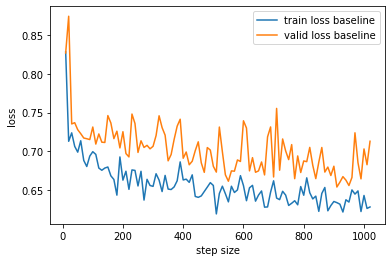

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.plot(step_axis_base, train_loss_line_base,label='train loss baseline')
plt.plot(step_axis_base, valid_loss_line_base,label='valid loss baseline')
plt.xlabel('step size')
plt.ylabel('loss')
plt.legend()

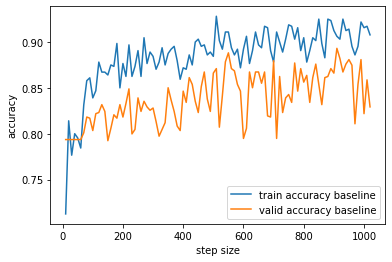

In [ ]:
plt.plot(step_axis_base, train_accu_line_base,label='train accuracy baseline')
plt.plot(step_axis_base, valid_accu_line_base,label='valid accuracy baseline')
plt.xlabel('step size')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
d_list_bs = [train_accu_line_base,valid_accu_line_base,train_loss_line_base,valid_loss_line_base]
df_base = pd.DataFrame.from_records(d_list_bs)
df_base = df_base.T
df_base.columns = ['train_accu_line_base','valid_accu_line_base','train_loss_line_base','valid_loss_line_base']
df_base.to_csv('/content/drive/My Drive/comp4211/proj1/df_base.csv', header=True, index=False)

#Advanced Try

##modified parameter 1

In [ ]:
transf = transforms.Compose(
    [transforms.Resize((32,32)), transforms.ToTensor(),transforms.Grayscale(num_output_channels=1)])

#transf = transforms.Compose(
    #[transforms.Resize((32,32)), transforms.ToTensor()])

train_dataest_1 = MaskDataset_clip(data_train_path, transforms=transf)
valid_dataest_1 = MaskDataset_clip(data_valid_path, transforms=transf)

bs = 128

train_loader_1 = DataLoader(train_dataest_1, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
valid_loader_1 = DataLoader(valid_dataest_1, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


model = Baseline().to(device)
num_epochs = 25
best_val_accu = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001,weight_decay=0.0001)
save_path = f'/content/drive/My Drive/comp4211/proj1/base_para1.pt'

step_axis_base1,train_loss_line_base1,valid_loss_line_base1,train_accu_line_base1, valid_accu_line_base1 = TRAIN(model, train_loader_1, valid_loader_1, num_epochs, criterion, optimizer, best_val_accu, device, save_path)

cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [1/25], Train Loss: 0.7909, Train Acc: 0.7945, Valid Loss: 0.8153,  Valid Acc: 0.7936



Epoch [1/25], Train Loss: 0.7212, Train Acc: 0.7844, Valid Loss: 0.8947,  Valid Acc: 0.7936




Epoch [2/25], Train Loss: 0.7109, Train Acc: 0.7477, Valid Loss: 0.7626,  Valid Acc: 0.7936



Epoch [2/25], Train Loss: 0.6997, Train Acc: 0.7937, Valid Loss: 0.7482,  Valid Acc: 0.7936



Epoch [2/25], Train Loss: 0.6794, Train Acc: 0.8141, Valid Loss: 0.7113,  Valid Acc: 0.7936




Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [3/25], Train Loss: 0.6926, Train Acc: 0.7719, Valid Loss: 0.7224,  Valid Acc: 0.7948



Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [3/25], Train Loss: 0.6896, Train Acc: 0.8203, Valid Loss: 0.7152,  Valid Acc: 0.8145




Epoch [4/25], Train Loss: 0.6845, Train Acc: 0.7969, Valid Loss: 0.7225,  Valid Acc: 0.8096



Epoch [4/25], Train Loss: 0.6816, Train Acc: 0.8727, Valid Loss: 0.7197,  Valid Acc: 0.8096



Epoch [4/25], Train Loss: 0.6861, Train Acc: 0.8648, Valid Loss: 0.7194,  Valid Acc: 0.8096




Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [5/25], Train Loss: 0.6797, Train Acc: 0.8203, Valid Loss: 0.7211,  Valid Acc: 0.8170



Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [5/25], Train Loss: 0.6695, Train Acc: 0.8813, Valid Loss: 0.7133,  Valid Acc: 0.8292



Epoch [5/25], Train Loss: 0.6677, Train Acc: 0.8305, Valid Loss: 0.7068,  Valid Acc: 0.8292




Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [6/25], Train Loss: 0.6722, Train Acc: 0.8773, Valid Loss: 0.7130,  Valid Acc: 0.8317



Epoch [6/25], Train Loss: 0.6661, Train Acc: 0.8781, Valid Loss: 0.7205,  Valid Acc: 0.8133




Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [7/25], Train Loss: 0.6630, Train Acc: 0.8313, Valid Loss: 0.7011,  Valid Acc: 0.8366



Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [7/25], Train Loss: 0.6723, Train Acc: 0.8727, Valid Loss: 0.6926,  Valid Acc: 0.8550



Epoch [7/25], Train Loss: 0.6516, Train Acc: 0.8945, Valid Loss: 0.6978,  Valid Acc: 0.8378




Epoch [8/25], Train Loss: 0.6564, Train Acc: 0.8383, Valid Loss: 0.6943,  Valid Acc: 0.8489



Epoch [8/25], Train Loss: 0.6622, Train Acc: 0.8820, Valid Loss: 0.6952,  Valid Acc: 0.8464




Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [9/25], Train Loss: 0.6609, Train Acc: 0.8391, Valid Loss: 0.6868,  Valid Acc: 0.8563



Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [9/25], Train Loss: 0.6710, Train Acc: 0.8750, Valid Loss: 0.6815,  Valid Acc: 0.8587



Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [9/25], Train Loss: 0.6488, Train Acc: 0.8961, Valid Loss: 0.6784,  Valid Acc: 0.8649




Epoch [10/25], Train Loss: 0.6542, Train Acc: 0.8422, Valid Loss: 0.7021,  Valid Acc: 0.8329



Epoch [10/25], Train Loss: 0.6564, Train Acc: 0.8859, Valid Loss: 0.6946,  Valid Acc: 0.8440



Epoch [10/25], Train Loss: 0.6375, Train Acc: 0.8625, Valid Loss: 0.6870,  Valid Acc: 0.8501




Epoch [11/25], Train Loss: 0.6609, Train Acc: 0.8813, Valid Loss: 0.7251,  Valid Acc: 0.8145



Epoch [11/25], Train Loss: 0.6551, Train Acc: 0.8922, Valid Loss: 0.6864,  Valid Acc: 0.8575




Epoch [12/25], Train Loss: 0.6515, Train Acc: 0.8469, Valid Loss: 0.6964,  Valid Acc: 0.8464



Epoch [12/25], Train Loss: 0.6413, Train Acc: 0.9031, Valid Loss: 0.7471,  Valid Acc: 0.7727



Epoch [12/25], Train Loss: 0.6514, Train Acc: 0.8992, Valid Loss: 0.6928,  Valid Acc: 0.8538




Epoch [13/25], Train Loss: 0.6709, Train Acc: 0.8281, Valid Loss: 0.7518,  Valid Acc: 0.7948



Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [13/25], Train Loss: 0.6500, Train Acc: 0.8953, Valid Loss: 0.6751,  Valid Acc: 0.8673




Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [14/25], Train Loss: 0.6625, Train Acc: 0.8398, Valid Loss: 0.6740,  Valid Acc: 0.8784



Epoch [14/25], Train Loss: 0.6446, Train Acc: 0.9023, Valid Loss: 0.6736,  Valid Acc: 0.8710



Epoch [14/25], Train Loss: 0.6448, Train Acc: 0.9031, Valid Loss: 0.7018,  Valid Acc: 0.8391




Epoch [15/25], Train Loss: 0.6342, Train Acc: 0.8648, Valid Loss: 0.6757,  Valid Acc: 0.8624



Epoch [15/25], Train Loss: 0.6353, Train Acc: 0.9109, Valid Loss: 0.6920,  Valid Acc: 0.8550



Epoch [15/25], Train Loss: 0.6534, Train Acc: 0.8484, Valid Loss: 0.7545,  Valid Acc: 0.7850




Epoch [16/25], Train Loss: 0.6378, Train Acc: 0.9102, Valid Loss: 0.6727,  Valid Acc: 0.8673



Epoch [16/25], Train Loss: 0.6390, Train Acc: 0.9133, Valid Loss: 0.6951,  Valid Acc: 0.8477




Epoch [17/25], Train Loss: 0.6387, Train Acc: 0.8625, Valid Loss: 0.7050,  Valid Acc: 0.8354



Epoch [17/25], Train Loss: 0.6471, Train Acc: 0.9016, Valid Loss: 0.6897,  Valid Acc: 0.8489



Epoch [17/25], Train Loss: 0.6304, Train Acc: 0.9148, Valid Loss: 0.6923,  Valid Acc: 0.8501




Epoch [18/25], Train Loss: 0.6402, Train Acc: 0.8594, Valid Loss: 0.7187,  Valid Acc: 0.8219



Epoch [18/25], Train Loss: 0.6308, Train Acc: 0.9219, Valid Loss: 0.7046,  Valid Acc: 0.8428




Epoch [19/25], Train Loss: 0.6422, Train Acc: 0.8547, Valid Loss: 0.6763,  Valid Acc: 0.8624



Epoch [19/25], Train Loss: 0.6450, Train Acc: 0.9039, Valid Loss: 0.6867,  Valid Acc: 0.8587



Epoch [19/25], Train Loss: 0.6362, Train Acc: 0.9148, Valid Loss: 0.6807,  Valid Acc: 0.8661




Epoch [20/25], Train Loss: 0.6330, Train Acc: 0.8609, Valid Loss: 0.6780,  Valid Acc: 0.8575



Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [20/25], Train Loss: 0.6424, Train Acc: 0.9070, Valid Loss: 0.6621,  Valid Acc: 0.8845



Epoch [20/25], Train Loss: 0.6352, Train Acc: 0.8617, Valid Loss: 0.6711,  Valid Acc: 0.8698




Epoch [21/25], Train Loss: 0.6424, Train Acc: 0.9055, Valid Loss: 0.6759,  Valid Acc: 0.8661



Epoch [21/25], Train Loss: 0.6307, Train Acc: 0.9172, Valid Loss: 0.6778,  Valid Acc: 0.8624




Epoch [22/25], Train Loss: 0.6273, Train Acc: 0.8695, Valid Loss: 0.6756,  Valid Acc: 0.8661



Epoch [22/25], Train Loss: 0.6340, Train Acc: 0.9117, Valid Loss: 0.6898,  Valid Acc: 0.8538



Epoch [22/25], Train Loss: 0.6463, Train Acc: 0.8961, Valid Loss: 0.6645,  Valid Acc: 0.8845




Epoch [23/25], Train Loss: 0.6254, Train Acc: 0.8734, Valid Loss: 0.6673,  Valid Acc: 0.8771



Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [23/25], Train Loss: 0.6298, Train Acc: 0.9172, Valid Loss: 0.6570,  Valid Acc: 0.8894




Epoch [24/25], Train Loss: 0.6383, Train Acc: 0.8602, Valid Loss: 0.6893,  Valid Acc: 0.8514



Epoch [24/25], Train Loss: 0.6331, Train Acc: 0.9141, Valid Loss: 0.7514,  Valid Acc: 0.7838



Epoch [24/25], Train Loss: 0.6213, Train Acc: 0.9250, Valid Loss: 0.6625,  Valid Acc: 0.8808




Epoch [25/25], Train Loss: 0.6317, Train Acc: 0.8672, Valid Loss: 0.6725,  Valid Acc: 0.8698



Epoch [25/25], Train Loss: 0.6225, Train Acc: 0.9281, Valid Loss: 0.6696,  Valid Acc: 0.8796



Model saved to /content/drive/My Drive/comp4211/proj1/base_para1.pt
Epoch [25/25], Train Loss: 0.6257, Train Acc: 0.8758, Valid Loss: 0.6524,  Valid Acc: 0.8993

Finished Training


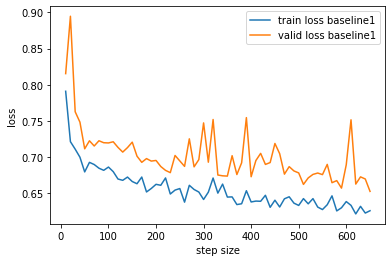

In [ ]:
plt.plot(step_axis_base1, train_loss_line_base1,label='train loss baseline1')
plt.plot(step_axis_base1, valid_loss_line_base1,label='valid loss baseline1')
plt.xlabel('step size')
plt.ylabel('loss')
plt.legend()

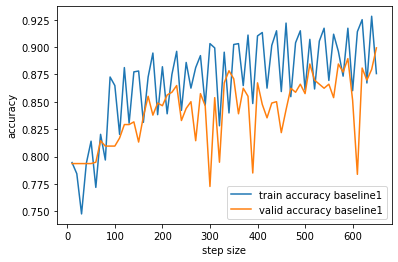

In [ ]:
plt.plot(step_axis_base1, train_accu_line_base1,label='train accuracy baseline1')
plt.plot(step_axis_base1, valid_accu_line_base1,label='valid accuracy baseline1')
plt.xlabel('step size')
plt.ylabel('accuracy')
plt.legend()

##modified parameter 2

In [ ]:
model = Baseline().to(device)
num_epochs = 30
best_val_accu = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.002,weight_decay=0.0001)
save_path = f'/content/drive/My Drive/comp4211/proj1/base_para2.pt'

step_axis_base2,train_loss_line_base2,valid_loss_line_base2,train_accu_line_base2, valid_accu_line_base2 = TRAIN(model, train_loader_1, valid_loader_1, num_epochs, criterion, optimizer, best_val_accu, device, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model saved to /content/drive/My Drive/comp4211/proj1/base_para2.pt
Epoch [1/30], Train Loss: 0.8139, Train Acc: 0.7414, Valid Loss: 0.8145,  Valid Acc: 0.7936



Epoch [1/30], Train Loss: 0.7318, Train Acc: 0.7891, Valid Loss: 0.8524,  Valid Acc: 0.7936




Epoch [2/30], Train Loss: 0.6938, Train Acc: 0.7742, Valid Loss: 0.7653,  Valid Acc: 0.7936



Epoch [2/30], Train Loss: 0.6967, Train Acc: 0.8078, Valid Loss: 0.7310,  Valid Acc: 0.7801



Epoch [2/30], Train Loss: 0.7004, Train Acc: 0.8211, Valid Loss: 0.7395,  Valid Acc: 0.7899




Model saved to /content/drive/My Drive/comp4211/proj1/base_para2.pt
Epoch [3/30], Train Loss: 0.7026, Train Acc: 0.7789, Valid Loss: 0.7296,  Valid Acc: 0.8010



Epoch [3/30], Train Loss: 0.7029, Train Acc: 0.8313, Valid Loss: 0.7443,  Valid Acc: 0.7776




Epoch [4/30], Train Loss: 0.6919, Train Acc: 0.8086, Valid Loss: 0.7531,  Valid Acc: 0.7936



Model saved to /content/drive/My Drive/comp4211/proj1/base_para2.pt
Epoch [4/30], Train Loss: 0.6894, Train Acc: 0.8500, Valid Loss: 0.7273,  Valid Acc: 0.8084



Epoch [4/30], Train Loss: 0.6804, Train Acc: 0.8641, Valid Loss: 0.7394,  Valid Acc: 0.7936




Model saved to /content/drive/My Drive/comp4211/proj1/base_para2.pt
Epoch [5/30], Train Loss: 0.6692, Train Acc: 0.8227, Valid Loss: 0.7127,  Valid Acc: 0.8133



Epoch [5/30], Train Loss: 0.6782, Train Acc: 0.8609, Valid Loss: 0.7464,  Valid Acc: 0.7862



Model saved to /content/drive/My Drive/comp4211/proj1/base_para2.pt
Epoch [5/30], Train Loss: 0.6693, Train Acc: 0.8305, Valid Loss: 0.7000,  Valid Acc: 0.8354




Epoch [6/30], Train Loss: 0.6723, Train Acc: 0.8734, Valid Loss: 0.7238,  Valid Acc: 0.8133



Epoch [6/30], Train Loss: 0.6746, Train Acc: 0.8703, Valid Loss: 0.7412,  Valid Acc: 0.7936




Epoch [7/30], Train Loss: 0.6457, Train Acc: 0.8469, Valid Loss: 0.7185,  Valid Acc: 0.8157



Epoch [7/30], Train Loss: 0.6629, Train Acc: 0.8852, Valid Loss: 0.7090,  Valid Acc: 0.8206



Epoch [7/30], Train Loss: 0.6691, Train Acc: 0.8750, Valid Loss: 0.7198,  Valid Acc: 0.8243




Epoch [8/30], Train Loss: 0.6630, Train Acc: 0.8344, Valid Loss: 0.8112,  Valid Acc: 0.7039



Epoch [8/30], Train Loss: 0.6678, Train Acc: 0.8773, Valid Loss: 0.8288,  Valid Acc: 0.6695




Epoch [9/30], Train Loss: 0.6637, Train Acc: 0.8352, Valid Loss: 0.7481,  Valid Acc: 0.7875



Model saved to /content/drive/My Drive/comp4211/proj1/base_para2.pt
Epoch [9/30], Train Loss: 0.6620, Train Acc: 0.8859, Valid Loss: 0.6927,  Valid Acc: 0.8415



Epoch [9/30], Train Loss: 0.6516, Train Acc: 0.9008, Valid Loss: 0.7164,  Valid Acc: 0.8206




Epoch [10/30], Train Loss: 0.6545, Train Acc: 0.8383, Valid Loss: 0.7358,  Valid Acc: 0.7887



Epoch [10/30], Train Loss: 0.6417, Train Acc: 0.9055, Valid Loss: 0.7037,  Valid Acc: 0.8378



Epoch [10/30], Train Loss: 0.6628, Train Acc: 0.8328, Valid Loss: 0.7016,  Valid Acc: 0.8366




Model saved to /content/drive/My Drive/comp4211/proj1/base_para2.pt
Epoch [11/30], Train Loss: 0.6591, Train Acc: 0.8922, Valid Loss: 0.6898,  Valid Acc: 0.8538



Epoch [11/30], Train Loss: 0.6615, Train Acc: 0.8836, Valid Loss: 0.7258,  Valid Acc: 0.8157




Epoch [12/30], Train Loss: 0.6502, Train Acc: 0.8492, Valid Loss: 0.7317,  Valid Acc: 0.8120



Epoch [12/30], Train Loss: 0.6620, Train Acc: 0.8820, Valid Loss: 0.7143,  Valid Acc: 0.8219



Epoch [12/30], Train Loss: 0.6519, Train Acc: 0.8938, Valid Loss: 0.7111,  Valid Acc: 0.8268




Epoch [13/30], Train Loss: 0.6620, Train Acc: 0.8438, Valid Loss: 0.7927,  Valid Acc: 0.7285



Epoch [13/30], Train Loss: 0.6559, Train Acc: 0.8898, Valid Loss: 0.6961,  Valid Acc: 0.8415




Epoch [14/30], Train Loss: 0.6594, Train Acc: 0.8336, Valid Loss: 0.6920,  Valid Acc: 0.8403



Epoch [14/30], Train Loss: 0.6466, Train Acc: 0.9031, Valid Loss: 0.6912,  Valid Acc: 0.8477



Model saved to /content/drive/My Drive/comp4211/proj1/base_para2.pt
Epoch [14/30], Train Loss: 0.6460, Train Acc: 0.9008, Valid Loss: 0.6739,  Valid Acc: 0.8735




Epoch [15/30], Train Loss: 0.6550, Train Acc: 0.8406, Valid Loss: 0.6722,  Valid Acc: 0.8722



Epoch [15/30], Train Loss: 0.6481, Train Acc: 0.8961, Valid Loss: 0.7149,  Valid Acc: 0.8120



Epoch [15/30], Train Loss: 0.6445, Train Acc: 0.8586, Valid Loss: 0.6763,  Valid Acc: 0.8649




Epoch [16/30], Train Loss: 0.6363, Train Acc: 0.9117, Valid Loss: 0.6763,  Valid Acc: 0.8710



Epoch [16/30], Train Loss: 0.6640, Train Acc: 0.8820, Valid Loss: 0.7071,  Valid Acc: 0.8342




Epoch [17/30], Train Loss: 0.6324, Train Acc: 0.8625, Valid Loss: 0.6904,  Valid Acc: 0.8526



Epoch [17/30], Train Loss: 0.6390, Train Acc: 0.9109, Valid Loss: 0.7335,  Valid Acc: 0.8071



Epoch [17/30], Train Loss: 0.6611, Train Acc: 0.8805, Valid Loss: 0.6843,  Valid Acc: 0.8575




Epoch [18/30], Train Loss: 0.6632, Train Acc: 0.8328, Valid Loss: 0.6918,  Valid Acc: 0.8501



Epoch [18/30], Train Loss: 0.6433, Train Acc: 0.9023, Valid Loss: 0.6774,  Valid Acc: 0.8612




Epoch [19/30], Train Loss: 0.6421, Train Acc: 0.8539, Valid Loss: 0.6849,  Valid Acc: 0.8600



Epoch [19/30], Train Loss: 0.6417, Train Acc: 0.9062, Valid Loss: 0.7300,  Valid Acc: 0.8010



Epoch [19/30], Train Loss: 0.6582, Train Acc: 0.8898, Valid Loss: 0.7006,  Valid Acc: 0.8378




Epoch [20/30], Train Loss: 0.6441, Train Acc: 0.8523, Valid Loss: 0.6819,  Valid Acc: 0.8575



Epoch [20/30], Train Loss: 0.6362, Train Acc: 0.9086, Valid Loss: 0.6742,  Valid Acc: 0.8686



Model saved to /content/drive/My Drive/comp4211/proj1/base_para2.pt
Epoch [20/30], Train Loss: 0.6507, Train Acc: 0.8477, Valid Loss: 0.6640,  Valid Acc: 0.8784




Epoch [21/30], Train Loss: 0.6287, Train Acc: 0.9266, Valid Loss: 0.7727,  Valid Acc: 0.7568



Epoch [21/30], Train Loss: 0.6481, Train Acc: 0.9008, Valid Loss: 0.8563,  Valid Acc: 0.6634




Epoch [22/30], Train Loss: 0.6281, Train Acc: 0.8703, Valid Loss: 0.6763,  Valid Acc: 0.8661



Epoch [22/30], Train Loss: 0.6410, Train Acc: 0.9078, Valid Loss: 0.7245,  Valid Acc: 0.8219



Epoch [22/30], Train Loss: 0.6441, Train Acc: 0.9008, Valid Loss: 0.7465,  Valid Acc: 0.7862




Epoch [23/30], Train Loss: 0.6344, Train Acc: 0.8633, Valid Loss: 0.7204,  Valid Acc: 0.8133



Epoch [23/30], Train Loss: 0.6608, Train Acc: 0.8875, Valid Loss: 0.7015,  Valid Acc: 0.8428




Model saved to /content/drive/My Drive/comp4211/proj1/base_para2.pt
Epoch [24/30], Train Loss: 0.6381, Train Acc: 0.8570, Valid Loss: 0.6617,  Valid Acc: 0.8907



Epoch [24/30], Train Loss: 0.6370, Train Acc: 0.9109, Valid Loss: 0.7002,  Valid Acc: 0.8391



Epoch [24/30], Train Loss: 0.6411, Train Acc: 0.9055, Valid Loss: 0.7019,  Valid Acc: 0.8440




Epoch [25/30], Train Loss: 0.6271, Train Acc: 0.8711, Valid Loss: 0.6787,  Valid Acc: 0.8636



Epoch [25/30], Train Loss: 0.6447, Train Acc: 0.9039, Valid Loss: 0.7671,  Valid Acc: 0.7604



Epoch [25/30], Train Loss: 0.6328, Train Acc: 0.8688, Valid Loss: 0.7102,  Valid Acc: 0.8268




Epoch [26/30], Train Loss: 0.6334, Train Acc: 0.9187, Valid Loss: 0.6935,  Valid Acc: 0.8489



Epoch [26/30], Train Loss: 0.6376, Train Acc: 0.9102, Valid Loss: 0.7202,  Valid Acc: 0.8133




Epoch [27/30], Train Loss: 0.6306, Train Acc: 0.8711, Valid Loss: 0.6787,  Valid Acc: 0.8600



Epoch [27/30], Train Loss: 0.6300, Train Acc: 0.9164, Valid Loss: 0.6807,  Valid Acc: 0.8587



Model saved to /content/drive/My Drive/comp4211/proj1/base_para2.pt
Epoch [27/30], Train Loss: 0.6240, Train Acc: 0.9258, Valid Loss: 0.6463,  Valid Acc: 0.9017




Epoch [28/30], Train Loss: 0.6373, Train Acc: 0.8609, Valid Loss: 0.6779,  Valid Acc: 0.8673



Epoch [28/30], Train Loss: 0.6292, Train Acc: 0.9203, Valid Loss: 0.7252,  Valid Acc: 0.8243




Epoch [29/30], Train Loss: 0.6383, Train Acc: 0.8578, Valid Loss: 0.6813,  Valid Acc: 0.8624



Epoch [29/30], Train Loss: 0.6296, Train Acc: 0.9234, Valid Loss: 0.6717,  Valid Acc: 0.8735



Epoch [29/30], Train Loss: 0.6379, Train Acc: 0.9094, Valid Loss: 0.6996,  Valid Acc: 0.8428




Epoch [30/30], Train Loss: 0.6630, Train Acc: 0.8352, Valid Loss: 0.7034,  Valid Acc: 0.8342



Epoch [30/30], Train Loss: 0.6396, Train Acc: 0.9070, Valid Loss: 0.7161,  Valid Acc: 0.8292



Epoch [30/30], Train Loss: 0.6360, Train Acc: 0.8586, Valid Loss: 0.7391,  Valid Acc: 0.8047

Finished Training


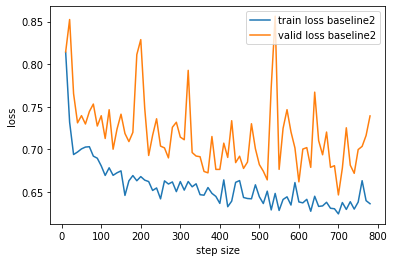

In [ ]:
plt.plot(step_axis_base2, train_loss_line_base2,label='train loss baseline2')
plt.plot(step_axis_base2, valid_loss_line_base2,label='valid loss baseline2')
plt.xlabel('step size')
plt.ylabel('loss')
plt.legend()

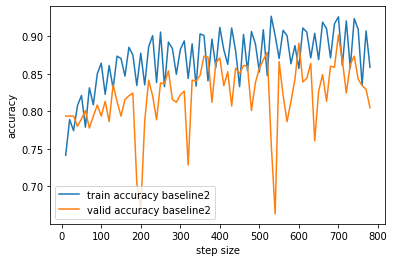

In [ ]:
plt.plot(step_axis_base2, train_accu_line_base2,label='train accuracy baseline2')
plt.plot(step_axis_base2, valid_accu_line_base2,label='valid accuracy baseline2')
plt.xlabel('step size')
plt.ylabel('accuracy')
plt.legend()

##pretrained model vgg16

In [ ]:
transf_vgg = transforms.Compose(
    [transforms.Resize((32,32)), transforms.ToTensor()])

train_dataest_vgg = MaskDataset_clip(data_train_path, transforms=transf_vgg)
valid_dataest_vgg = MaskDataset_clip(data_valid_path, transforms=transf_vgg)

bs = 64

train_loader_vgg = DataLoader(train_dataest_vgg, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
valid_loader_vgg = DataLoader(valid_dataest_vgg, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True).cuda()
summary(vgg16, torch.zeros((64, 3, 32, 32)).cuda())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



                              Kernel Shape       Output Shape       Params  \
Layer                                                                        
0_features.Conv2d_0          [3, 64, 3, 3]   [64, 64, 32, 32]       1.792k   
1_features.ReLU_1                        -   [64, 64, 32, 32]            -   
2_features.Conv2d_2         [64, 64, 3, 3]   [64, 64, 32, 32]      36.928k   
3_features.ReLU_3                        -   [64, 64, 32, 32]            -   
4_features.MaxPool2d_4                   -   [64, 64, 16, 16]            -   
5_features.Conv2d_5        [64, 128, 3, 3]  [64, 128, 16, 16]      73.856k   
6_features.ReLU_6                        -  [64, 128, 16, 16]            -   
7_features.Conv2d_7       [128, 128, 3, 3]  [64, 128, 16, 16]     147.584k   
8_features.ReLU_8                        -  [64, 128, 16, 16]            -   
9_features.MaxPool2d_9                   -    [64, 128, 8, 8]            -   
10_features.Conv2d_10     [128, 256, 3, 3]    [64, 256, 8, 8]  

Kernel Shape  ...    Mult-Adds
Layer                                       ...             
0_features.Conv2d_0          [3, 64, 3, 3]  ...    1769472.0
1_features.ReLU_1                        -  ...          NaN
2_features.Conv2d_2         [64, 64, 3, 3]  ...   37748736.0
3_features.ReLU_3                        -  ...          NaN
4_features.MaxPool2d_4                   -  ...          NaN
5_features.Conv2d_5        [64, 128, 3, 3]  ...   18874368.0
6_features.ReLU_6                        -  ...          NaN
7_features.Conv2d_7       [128, 128, 3, 3]  ...   37748736.0
8_features.ReLU_8                        -  ...          NaN
9_features.MaxPool2d_9                   -  ...          NaN
10_features.Conv2d_10     [128, 256, 3, 3]  ...   18874368.0
11_features.ReLU_11                      -  ...          NaN
12_features.Conv2d_12     [256, 256, 3, 3]  ...   37748736.0
13_features.ReLU_13                      -  ...          NaN
14_features.Conv2d_14     [256, 256, 3, 3]  ...   37748736.0
15_features.ReLU_15                      -  ...          NaN
16_features.MaxPool2d_16                 -  ...          NaN
17_features.Conv2d_17     [256, 512, 3, 3]  ...   18874368.0
18_features.ReLU_18                      -  ...          NaN
19_features.Conv2d_19     [512, 512, 3, 3]  ...   37748736.0
20_features.ReLU_20                      -  ...          NaN
21_features.Conv2d_21     [512, 512, 3, 3]  ...   37748736.0
22_features.ReLU_22                      -  ...          NaN
23_features.MaxPool2d_23                 -  ...          NaN
24_features.Conv2d_24     [512, 512, 3, 3]  ...    9437184.0
25_features.ReLU_25                      -  ...          NaN
26_features.Conv2d_26     [512, 512, 3, 3]  ...    9437184.0
27_features.ReLU_27                      -  ...          NaN
28_features.Conv2d_28     [512, 512, 3, 3]  ...    9437184.0
29_features.ReLU_29                      -  ...          NaN
30_features.MaxPool2d_30                 -  ...          NaN
31_avgpool                               -  ...          NaN
32_classifier.Linear_0       [25088, 4096]  ...  102760448.0
33_classifier.ReLU_1                     -  ...          NaN
34_classifier.Dropout_2                  -  ...          NaN
35_classifier.Linear_3        [4096, 4096]  ...   16777216.0
36_classifier.ReLU_4                     -  ...          NaN
37_classifier.Dropout_5                  -  ...          NaN
38_classifier.Linear_6        [4096, 1000]  ...    4096000.0

[39 rows x 4 columns]

In [ ]:
# replace the entire classifier block by encapsulating VGG in a new model

class Modified_VGG(nn.Module):

    def __init__(self):
        super(Modified_VGG, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=True)

        for param in self.vgg.parameters():
            param.requires_grad = False

        self.vgg.classifier = nn.Linear(512*7*7, 3)

    def forward(self, images):
        return self.vgg(images)

modified_vgg = Modified_VGG().cuda()
summary(modified_vgg, torch.zeros((64, 3, 32, 32)).cuda())

                                      Kernel Shape       Output Shape  \
Layer                                                                   
0_vgg.features.Conv2d_0              [3, 64, 3, 3]   [64, 64, 32, 32]   
1_vgg.features.ReLU_1                            -   [64, 64, 32, 32]   
2_vgg.features.Conv2d_2             [64, 64, 3, 3]   [64, 64, 32, 32]   
3_vgg.features.ReLU_3                            -   [64, 64, 32, 32]   
4_vgg.features.MaxPool2d_4                       -   [64, 64, 16, 16]   
5_vgg.features.Conv2d_5            [64, 128, 3, 3]  [64, 128, 16, 16]   
6_vgg.features.ReLU_6                            -  [64, 128, 16, 16]   
7_vgg.features.Conv2d_7           [128, 128, 3, 3]  [64, 128, 16, 16]   
8_vgg.features.ReLU_8                            -  [64, 128, 16, 16]   
9_vgg.features.MaxPool2d_9                       -    [64, 128, 8, 8]   
10_vgg.features.Conv2d_10         [128, 256, 3, 3]    [64, 256, 8, 8]   
11_vgg.features.ReLU_11                          - 

Kernel Shape  ... Mult-Adds
Layer                                               ...          
0_vgg.features.Conv2d_0              [3, 64, 3, 3]  ...       NaN
1_vgg.features.ReLU_1                            -  ...       NaN
2_vgg.features.Conv2d_2             [64, 64, 3, 3]  ...       NaN
3_vgg.features.ReLU_3                            -  ...       NaN
4_vgg.features.MaxPool2d_4                       -  ...       NaN
5_vgg.features.Conv2d_5            [64, 128, 3, 3]  ...       NaN
6_vgg.features.ReLU_6                            -  ...       NaN
7_vgg.features.Conv2d_7           [128, 128, 3, 3]  ...       NaN
8_vgg.features.ReLU_8                            -  ...       NaN
9_vgg.features.MaxPool2d_9                       -  ...       NaN
10_vgg.features.Conv2d_10         [128, 256, 3, 3]  ...       NaN
11_vgg.features.ReLU_11                          -  ...       NaN
12_vgg.features.Conv2d_12         [256, 256, 3, 3]  ...       NaN
13_vgg.features.ReLU_13                          -  ...       NaN
14_vgg.features.Conv2d_14         [256, 256, 3, 3]  ...       NaN
15_vgg.features.ReLU_15                          -  ...       NaN
16_vgg.features.MaxPool2d_16                     -  ...       NaN
17_vgg.features.Conv2d_17         [256, 512, 3, 3]  ...       NaN
18_vgg.features.ReLU_18                          -  ...       NaN
19_vgg.features.Conv2d_19         [512, 512, 3, 3]  ...       NaN
20_vgg.features.ReLU_20                          -  ...       NaN
21_vgg.features.Conv2d_21         [512, 512, 3, 3]  ...       NaN
22_vgg.features.ReLU_22                          -  ...       NaN
23_vgg.features.MaxPool2d_23                     -  ...       NaN
24_vgg.features.Conv2d_24         [512, 512, 3, 3]  ...       NaN
25_vgg.features.ReLU_25                          -  ...       NaN
26_vgg.features.Conv2d_26         [512, 512, 3, 3]  ...       NaN
27_vgg.features.ReLU_27                          -  ...       NaN
28_vgg.features.Conv2d_28         [512, 512, 3, 3]  ...       NaN
29_vgg.features.ReLU_29                          -  ...       NaN
30_vgg.features.MaxPool2d_30                     -  ...       NaN
31_vgg.AdaptiveAvgPool2d_avgpool                 -  ...       NaN
32_vgg.Linear_classifier                [25088, 3]  ...   75264.0

[33 rows x 4 columns]

In [ ]:
num_epochs = 20
vgg16_optimizer = optim.Adam(modified_vgg.parameters())
best_accu = None
criterion = nn.CrossEntropyLoss()
save_path = f'/content/drive/My Drive/comp4211/proj1/modified_vgg.pt'

step_axis_vgg,train_loss_line_vgg,valid_loss_line_vgg,train_accu_line_vgg, valid_accu_line_vgg = TRAIN(modified_vgg, train_loader_vgg, valid_loader_vgg, num_epochs, criterion, vgg16_optimizer, best_accu, device, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg.pt
Epoch [1/20], Train Loss: 1.1236, Train Acc: 0.7563, Valid Loss: 0.9832,  Valid Acc: 0.8587



Epoch [1/20], Train Loss: 0.8140, Train Acc: 0.8453, Valid Loss: 0.7430,  Valid Acc: 0.8182



Epoch [1/20], Train Loss: 0.5690, Train Acc: 0.8391, Valid Loss: 0.6638,  Valid Acc: 0.8280



Epoch [1/20], Train Loss: 0.5324, Train Acc: 0.8391, Valid Loss: 0.5884,  Valid Acc: 0.8391



Epoch [1/20], Train Loss: 0.4732, Train Acc: 0.8703, Valid Loss: 0.5454,  Valid Acc: 0.8366




Epoch [2/20], Train Loss: 0.3760, Train Acc: 0.8688, Valid Loss: 0.6043,  Valid Acc: 0.8305



Epoch [2/20], Train Loss: 0.3936, Train Acc: 0.8844, Valid Loss: 0.6164,  Valid Acc: 0.8587



Epoch [2/20], Train Loss: 0.3716, Train Acc: 0.8906, Valid Loss: 0.5687,  Valid Acc: 0.8391



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg.pt
Epoch [2/20], Train Loss: 0.3801, Train Acc: 0.8766, Valid Loss: 0.5071,  Valid Acc: 0.8624



Epoch [2/20], Train Loss: 0.2727, Train Acc: 0.9141, Valid Loss: 0.6017,  Valid Acc: 0.8329




Epoch [3/20], Train Loss: 0.3566, Train Acc: 0.8703, Valid Loss: 0.5926,  Valid Acc: 0.8305



Epoch [3/20], Train Loss: 0.2624, Train Acc: 0.9062, Valid Loss: 0.6808,  Valid Acc: 0.8391



Epoch [3/20], Train Loss: 0.2941, Train Acc: 0.9047, Valid Loss: 0.5661,  Valid Acc: 0.8268



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg.pt
Epoch [3/20], Train Loss: 0.2365, Train Acc: 0.9234, Valid Loss: 0.6883,  Valid Acc: 0.8673



Epoch [3/20], Train Loss: 0.3525, Train Acc: 0.8984, Valid Loss: 0.5615,  Valid Acc: 0.8563




Epoch [4/20], Train Loss: 0.2317, Train Acc: 0.9125, Valid Loss: 0.6077,  Valid Acc: 0.8636



Epoch [4/20], Train Loss: 0.2815, Train Acc: 0.9250, Valid Loss: 0.5997,  Valid Acc: 0.8366



Epoch [4/20], Train Loss: 0.2507, Train Acc: 0.9187, Valid Loss: 0.5971,  Valid Acc: 0.8440



Epoch [4/20], Train Loss: 0.3547, Train Acc: 0.8813, Valid Loss: 0.6024,  Valid Acc: 0.8501



Epoch [4/20], Train Loss: 0.3300, Train Acc: 0.8938, Valid Loss: 0.5879,  Valid Acc: 0.8661




Epoch [5/20], Train Loss: 0.2606, Train Acc: 0.9187, Valid Loss: 0.5823,  Valid Acc: 0.8624



Epoch [5/20], Train Loss: 0.2284, Train Acc: 0.9141, Valid Loss: 0.5451,  Valid Acc: 0.8538



Epoch [5/20], Train Loss: 0.2653, Train Acc: 0.9234, Valid Loss: 0.6733,  Valid Acc: 0.8477



Epoch [5/20], Train Loss: 0.3010, Train Acc: 0.9094, Valid Loss: 0.6763,  Valid Acc: 0.8612



Epoch [5/20], Train Loss: 0.3999, Train Acc: 0.8766, Valid Loss: 0.7617,  Valid Acc: 0.8477




Epoch [6/20], Train Loss: 0.3706, Train Acc: 0.8766, Valid Loss: 0.6873,  Valid Acc: 0.8501



Epoch [6/20], Train Loss: 0.2977, Train Acc: 0.9016, Valid Loss: 0.7444,  Valid Acc: 0.8428



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg.pt
Epoch [6/20], Train Loss: 0.3083, Train Acc: 0.9094, Valid Loss: 0.6165,  Valid Acc: 0.8747



Epoch [6/20], Train Loss: 0.2784, Train Acc: 0.9031, Valid Loss: 0.7228,  Valid Acc: 0.8636



Epoch [6/20], Train Loss: 0.3863, Train Acc: 0.8953, Valid Loss: 0.9035,  Valid Acc: 0.7985




Epoch [7/20], Train Loss: 0.2698, Train Acc: 0.9094, Valid Loss: 0.8101,  Valid Acc: 0.8575



Epoch [7/20], Train Loss: 0.2884, Train Acc: 0.9203, Valid Loss: 0.7588,  Valid Acc: 0.8489



Epoch [7/20], Train Loss: 0.2926, Train Acc: 0.9078, Valid Loss: 0.7128,  Valid Acc: 0.8550



Epoch [7/20], Train Loss: 0.2833, Train Acc: 0.9031, Valid Loss: 0.7308,  Valid Acc: 0.8501



Epoch [7/20], Train Loss: 0.3672, Train Acc: 0.8953, Valid Loss: 0.7253,  Valid Acc: 0.8686




Epoch [8/20], Train Loss: 0.2543, Train Acc: 0.9125, Valid Loss: 0.7692,  Valid Acc: 0.8489



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg.pt
Epoch [8/20], Train Loss: 0.2446, Train Acc: 0.9219, Valid Loss: 0.7708,  Valid Acc: 0.8796



Epoch [8/20], Train Loss: 0.2314, Train Acc: 0.9391, Valid Loss: 0.6498,  Valid Acc: 0.8538



Epoch [8/20], Train Loss: 0.3406, Train Acc: 0.8922, Valid Loss: 0.8055,  Valid Acc: 0.8391



Epoch [8/20], Train Loss: 0.3660, Train Acc: 0.9031, Valid Loss: 0.8558,  Valid Acc: 0.8477




Epoch [9/20], Train Loss: 0.3309, Train Acc: 0.8906, Valid Loss: 0.8618,  Valid Acc: 0.8378



Epoch [9/20], Train Loss: 0.1887, Train Acc: 0.9375, Valid Loss: 0.8559,  Valid Acc: 0.8649



Epoch [9/20], Train Loss: 0.3366, Train Acc: 0.9000, Valid Loss: 0.8275,  Valid Acc: 0.8624



Epoch [9/20], Train Loss: 0.2736, Train Acc: 0.9203, Valid Loss: 0.9455,  Valid Acc: 0.8010



Epoch [9/20], Train Loss: 0.4493, Train Acc: 0.8781, Valid Loss: 0.8779,  Valid Acc: 0.8440




Epoch [10/20], Train Loss: 0.3776, Train Acc: 0.8953, Valid Loss: 0.8538,  Valid Acc: 0.8415



Epoch [10/20], Train Loss: 0.2817, Train Acc: 0.9219, Valid Loss: 0.9039,  Valid Acc: 0.8661



Epoch [10/20], Train Loss: 0.2601, Train Acc: 0.9313, Valid Loss: 0.9045,  Valid Acc: 0.8194



Epoch [10/20], Train Loss: 0.2443, Train Acc: 0.9359, Valid Loss: 0.7981,  Valid Acc: 0.8636



Epoch [10/20], Train Loss: 0.3124, Train Acc: 0.9062, Valid Loss: 0.9008,  Valid Acc: 0.8550



Epoch [10/20], Train Loss: 0.2964, Train Acc: 0.9109, Valid Loss: 0.9106,  Valid Acc: 0.8464




Epoch [11/20], Train Loss: 0.1777, Train Acc: 0.9453, Valid Loss: 0.9573,  Valid Acc: 0.8489



Epoch [11/20], Train Loss: 0.3354, Train Acc: 0.8969, Valid Loss: 0.8726,  Valid Acc: 0.8710



Epoch [11/20], Train Loss: 0.2281, Train Acc: 0.9328, Valid Loss: 0.8684,  Valid Acc: 0.8452



Epoch [11/20], Train Loss: 0.2637, Train Acc: 0.9156, Valid Loss: 0.9494,  Valid Acc: 0.8157



Epoch [11/20], Train Loss: 0.3087, Train Acc: 0.9141, Valid Loss: 0.9234,  Valid Acc: 0.8477




Epoch [12/20], Train Loss: 0.2003, Train Acc: 0.9172, Valid Loss: 0.8011,  Valid Acc: 0.8550



Epoch [12/20], Train Loss: 0.2308, Train Acc: 0.9187, Valid Loss: 0.8240,  Valid Acc: 0.8661



Epoch [12/20], Train Loss: 0.2332, Train Acc: 0.9141, Valid Loss: 0.8454,  Valid Acc: 0.8550



Epoch [12/20], Train Loss: 0.2486, Train Acc: 0.9156, Valid Loss: 0.9383,  Valid Acc: 0.8342



Epoch [12/20], Train Loss: 0.2347, Train Acc: 0.9391, Valid Loss: 0.9381,  Valid Acc: 0.8550




Epoch [13/20], Train Loss: 0.2070, Train Acc: 0.9203, Valid Loss: 0.9809,  Valid Acc: 0.8477



Epoch [13/20], Train Loss: 0.2134, Train Acc: 0.9391, Valid Loss: 0.8854,  Valid Acc: 0.8550



Epoch [13/20], Train Loss: 0.2356, Train Acc: 0.9141, Valid Loss: 1.0089,  Valid Acc: 0.8428



Epoch [13/20], Train Loss: 0.2547, Train Acc: 0.9281, Valid Loss: 0.9002,  Valid Acc: 0.8538



Epoch [13/20], Train Loss: 0.3119, Train Acc: 0.9094, Valid Loss: 0.8818,  Valid Acc: 0.8452




Epoch [14/20], Train Loss: 0.2108, Train Acc: 0.9250, Valid Loss: 0.9309,  Valid Acc: 0.8477



Epoch [14/20], Train Loss: 0.1625, Train Acc: 0.9469, Valid Loss: 0.9137,  Valid Acc: 0.8624



Epoch [14/20], Train Loss: 0.2881, Train Acc: 0.9156, Valid Loss: 0.9800,  Valid Acc: 0.8268



Epoch [14/20], Train Loss: 0.2999, Train Acc: 0.9000, Valid Loss: 0.8897,  Valid Acc: 0.8428



Epoch [14/20], Train Loss: 0.2541, Train Acc: 0.9250, Valid Loss: 0.9310,  Valid Acc: 0.8526




Epoch [15/20], Train Loss: 0.1750, Train Acc: 0.9234, Valid Loss: 0.8853,  Valid Acc: 0.8440



Epoch [15/20], Train Loss: 0.2106, Train Acc: 0.9328, Valid Loss: 0.8775,  Valid Acc: 0.8489



Epoch [15/20], Train Loss: 0.2229, Train Acc: 0.9172, Valid Loss: 1.0363,  Valid Acc: 0.8120



Epoch [15/20], Train Loss: 0.2542, Train Acc: 0.9156, Valid Loss: 0.9430,  Valid Acc: 0.8428



Epoch [15/20], Train Loss: 0.2622, Train Acc: 0.9156, Valid Loss: 0.9550,  Valid Acc: 0.8661




Epoch [16/20], Train Loss: 0.2730, Train Acc: 0.8969, Valid Loss: 1.0848,  Valid Acc: 0.8477



Epoch [16/20], Train Loss: 0.2358, Train Acc: 0.9313, Valid Loss: 0.9956,  Valid Acc: 0.8440



Epoch [16/20], Train Loss: 0.3081, Train Acc: 0.9047, Valid Loss: 0.9638,  Valid Acc: 0.8403



Epoch [16/20], Train Loss: 0.1833, Train Acc: 0.9406, Valid Loss: 0.9523,  Valid Acc: 0.8329



Epoch [16/20], Train Loss: 0.2041, Train Acc: 0.9328, Valid Loss: 0.8821,  Valid Acc: 0.8489




Epoch [17/20], Train Loss: 0.1908, Train Acc: 0.9281, Valid Loss: 0.9782,  Valid Acc: 0.8550



Epoch [17/20], Train Loss: 0.1910, Train Acc: 0.9359, Valid Loss: 0.9872,  Valid Acc: 0.8280



Epoch [17/20], Train Loss: 0.2283, Train Acc: 0.9313, Valid Loss: 1.0865,  Valid Acc: 0.8391



Epoch [17/20], Train Loss: 0.2625, Train Acc: 0.9156, Valid Loss: 1.0233,  Valid Acc: 0.8280



Epoch [17/20], Train Loss: 0.2604, Train Acc: 0.9125, Valid Loss: 0.9677,  Valid Acc: 0.8587




Epoch [18/20], Train Loss: 0.2036, Train Acc: 0.9266, Valid Loss: 0.9863,  Valid Acc: 0.8538



Epoch [18/20], Train Loss: 0.1911, Train Acc: 0.9344, Valid Loss: 0.9410,  Valid Acc: 0.8464



Epoch [18/20], Train Loss: 0.1811, Train Acc: 0.9328, Valid Loss: 0.9647,  Valid Acc: 0.8501



Epoch [18/20], Train Loss: 0.1928, Train Acc: 0.9344, Valid Loss: 1.0894,  Valid Acc: 0.8501



Epoch [18/20], Train Loss: 0.3048, Train Acc: 0.9109, Valid Loss: 1.0250,  Valid Acc: 0.8649




Epoch [19/20], Train Loss: 0.2624, Train Acc: 0.9156, Valid Loss: 1.0936,  Valid Acc: 0.8514



Epoch [19/20], Train Loss: 0.2372, Train Acc: 0.9187, Valid Loss: 1.1934,  Valid Acc: 0.8342



Epoch [19/20], Train Loss: 0.2219, Train Acc: 0.9266, Valid Loss: 1.0963,  Valid Acc: 0.8587



Epoch [19/20], Train Loss: 0.2934, Train Acc: 0.9156, Valid Loss: 1.0980,  Valid Acc: 0.8280



Epoch [19/20], Train Loss: 0.2178, Train Acc: 0.9266, Valid Loss: 0.9799,  Valid Acc: 0.8526




Epoch [20/20], Train Loss: 0.1897, Train Acc: 0.9281, Valid Loss: 1.0497,  Valid Acc: 0.8440



Epoch [20/20], Train Loss: 0.1926, Train Acc: 0.9391, Valid Loss: 1.0494,  Valid Acc: 0.8428



Epoch [20/20], Train Loss: 0.1726, Train Acc: 0.9484, Valid Loss: 1.0515,  Valid Acc: 0.8317



Epoch [20/20], Train Loss: 0.2387, Train Acc: 0.9297, Valid Loss: 1.1743,  Valid Acc: 0.8194



Epoch [20/20], Train Loss: 0.2115, Train Acc: 0.9141, Valid Loss: 1.1110,  Valid Acc: 0.8305



Epoch [20/20], Train Loss: 0.2790, Train Acc: 0.9078, Valid Loss: 1.0119,  Valid Acc: 0.8354

Finished Training


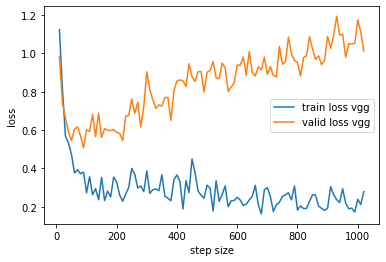

In [ ]:
plt.plot(step_axis_vgg, train_loss_line_vgg,label='train loss vgg')
plt.plot(step_axis_vgg, valid_loss_line_vgg,label='valid loss vgg')
plt.xlabel('step size')
plt.ylabel('loss')
plt.legend()

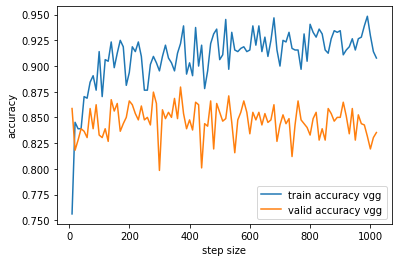

In [ ]:
plt.plot(step_axis_vgg, train_accu_line_vgg,label='train accuracy vgg')
plt.plot(step_axis_vgg, valid_accu_line_vgg,label='valid accuracy vgg')
plt.xlabel('step size')
plt.ylabel('accuracy')
plt.legend()

###vgg fine-tune

In [ ]:
# replace the entire classifier block by encapsulating VGG in a new model

class Modified_VGG_FT(nn.Module):

    def __init__(self):
        super(Modified_VGG_FT, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=True)

        for param in self.vgg.parameters():
            param.requires_grad = True

        self.vgg.classifier = nn.Linear(512*7*7, 3)

    def forward(self, images):
        return self.vgg(images)

modified_vgg_ft = Modified_VGG_FT().cuda()
summary(modified_vgg_ft, torch.zeros((64, 3, 32, 32)).cuda())

                                      Kernel Shape       Output Shape  \
Layer                                                                   
0_vgg.features.Conv2d_0              [3, 64, 3, 3]   [64, 64, 32, 32]   
1_vgg.features.ReLU_1                            -   [64, 64, 32, 32]   
2_vgg.features.Conv2d_2             [64, 64, 3, 3]   [64, 64, 32, 32]   
3_vgg.features.ReLU_3                            -   [64, 64, 32, 32]   
4_vgg.features.MaxPool2d_4                       -   [64, 64, 16, 16]   
5_vgg.features.Conv2d_5            [64, 128, 3, 3]  [64, 128, 16, 16]   
6_vgg.features.ReLU_6                            -  [64, 128, 16, 16]   
7_vgg.features.Conv2d_7           [128, 128, 3, 3]  [64, 128, 16, 16]   
8_vgg.features.ReLU_8                            -  [64, 128, 16, 16]   
9_vgg.features.MaxPool2d_9                       -    [64, 128, 8, 8]   
10_vgg.features.Conv2d_10         [128, 256, 3, 3]    [64, 256, 8, 8]   
11_vgg.features.ReLU_11                          - 

Kernel Shape  ...   Mult-Adds
Layer                                               ...            
0_vgg.features.Conv2d_0              [3, 64, 3, 3]  ...   1769472.0
1_vgg.features.ReLU_1                            -  ...         NaN
2_vgg.features.Conv2d_2             [64, 64, 3, 3]  ...  37748736.0
3_vgg.features.ReLU_3                            -  ...         NaN
4_vgg.features.MaxPool2d_4                       -  ...         NaN
5_vgg.features.Conv2d_5            [64, 128, 3, 3]  ...  18874368.0
6_vgg.features.ReLU_6                            -  ...         NaN
7_vgg.features.Conv2d_7           [128, 128, 3, 3]  ...  37748736.0
8_vgg.features.ReLU_8                            -  ...         NaN
9_vgg.features.MaxPool2d_9                       -  ...         NaN
10_vgg.features.Conv2d_10         [128, 256, 3, 3]  ...  18874368.0
11_vgg.features.ReLU_11                          -  ...         NaN
12_vgg.features.Conv2d_12         [256, 256, 3, 3]  ...  37748736.0
13_vgg.features.ReLU_13                          -  ...         NaN
14_vgg.features.Conv2d_14         [256, 256, 3, 3]  ...  37748736.0
15_vgg.features.ReLU_15                          -  ...         NaN
16_vgg.features.MaxPool2d_16                     -  ...         NaN
17_vgg.features.Conv2d_17         [256, 512, 3, 3]  ...  18874368.0
18_vgg.features.ReLU_18                          -  ...         NaN
19_vgg.features.Conv2d_19         [512, 512, 3, 3]  ...  37748736.0
20_vgg.features.ReLU_20                          -  ...         NaN
21_vgg.features.Conv2d_21         [512, 512, 3, 3]  ...  37748736.0
22_vgg.features.ReLU_22                          -  ...         NaN
23_vgg.features.MaxPool2d_23                     -  ...         NaN
24_vgg.features.Conv2d_24         [512, 512, 3, 3]  ...   9437184.0
25_vgg.features.ReLU_25                          -  ...         NaN
26_vgg.features.Conv2d_26         [512, 512, 3, 3]  ...   9437184.0
27_vgg.features.ReLU_27                          -  ...         NaN
28_vgg.features.Conv2d_28         [512, 512, 3, 3]  ...   9437184.0
29_vgg.features.ReLU_29                          -  ...         NaN
30_vgg.features.MaxPool2d_30                     -  ...         NaN
31_vgg.AdaptiveAvgPool2d_avgpool                 -  ...         NaN
32_vgg.Linear_classifier                [25088, 3]  ...     75264.0

[33 rows x 4 columns]

In [ ]:
num_epochs = 20
vgg16_optimizer_ft = optim.Adam(modified_vgg_ft.parameters())
best_accu = None
criterion = nn.CrossEntropyLoss()
save_path = f'/content/drive/My Drive/comp4211/proj1/modified_vgg_ft.pt'

step_axis_vgg2,train_loss_line_vgg2,valid_loss_line_vgg2,train_accu_line_vgg2, valid_accu_line_vgg2 = TRAIN(modified_vgg_ft, train_loader_vgg, valid_loader_vgg, num_epochs, criterion, vgg16_optimizer_ft, best_accu, device, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg_ft.pt
Epoch [1/20], Train Loss: 1.0485, Train Acc: 0.6859, Valid Loss: 0.6002,  Valid Acc: 0.7936



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg_ft.pt
Epoch [1/20], Train Loss: 0.5442, Train Acc: 0.7922, Valid Loss: 0.4360,  Valid Acc: 0.8317



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg_ft.pt
Epoch [1/20], Train Loss: 0.3090, Train Acc: 0.8891, Valid Loss: 0.2661,  Valid Acc: 0.9066



Epoch [1/20], Train Loss: 0.4109, Train Acc: 0.8203, Valid Loss: 0.5998,  Valid Acc: 0.7936



Epoch [1/20], Train Loss: 0.3614, Train Acc: 0.8688, Valid Loss: 0.3708,  Valid Acc: 0.8956




Epoch [2/20], Train Loss: 0.2722, Train Acc: 0.9203, Valid Loss: 0.2937,  Valid Acc: 0.9017



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg_ft.pt
Epoch [2/20], Train Loss: 0.1951, Train Acc: 0.9344, Valid Loss: 0.2024,  Valid Acc: 0.9312



Epoch [2/20], Train Loss: 0.2034, Train Acc: 0.9234, Valid Loss: 0.2061,  Valid Acc: 0.9226



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg_ft.pt
Epoch [2/20], Train Loss: 0.2022, Train Acc: 0.9484, Valid Loss: 0.2213,  Valid Acc: 0.9337



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg_ft.pt
Epoch [2/20], Train Loss: 0.1876, Train Acc: 0.9547, Valid Loss: 0.1816,  Valid Acc: 0.9373




Epoch [3/20], Train Loss: 0.1414, Train Acc: 0.9531, Valid Loss: 0.3041,  Valid Acc: 0.9017



Epoch [3/20], Train Loss: 0.1827, Train Acc: 0.9344, Valid Loss: 0.2209,  Valid Acc: 0.9300



Epoch [3/20], Train Loss: 0.1743, Train Acc: 0.9516, Valid Loss: 0.1900,  Valid Acc: 0.9361



Epoch [3/20], Train Loss: 0.1693, Train Acc: 0.9391, Valid Loss: 0.1770,  Valid Acc: 0.9263



Epoch [3/20], Train Loss: 0.1412, Train Acc: 0.9438, Valid Loss: 0.3353,  Valid Acc: 0.9066




Epoch [4/20], Train Loss: 0.1847, Train Acc: 0.9187, Valid Loss: 0.2048,  Valid Acc: 0.9226



Epoch [4/20], Train Loss: 0.1343, Train Acc: 0.9500, Valid Loss: 0.2000,  Valid Acc: 0.9361



Epoch [4/20], Train Loss: 0.1546, Train Acc: 0.9563, Valid Loss: 0.1667,  Valid Acc: 0.9373



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg_ft.pt
Epoch [4/20], Train Loss: 0.1275, Train Acc: 0.9531, Valid Loss: 0.1367,  Valid Acc: 0.9521



Epoch [4/20], Train Loss: 0.1375, Train Acc: 0.9500, Valid Loss: 0.1557,  Valid Acc: 0.9509




Epoch [5/20], Train Loss: 0.1212, Train Acc: 0.9547, Valid Loss: 0.1507,  Valid Acc: 0.9521



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg_ft.pt
Epoch [5/20], Train Loss: 0.1190, Train Acc: 0.9609, Valid Loss: 0.1395,  Valid Acc: 0.9607



Epoch [5/20], Train Loss: 0.1273, Train Acc: 0.9641, Valid Loss: 0.1337,  Valid Acc: 0.9607



Epoch [5/20], Train Loss: 0.1107, Train Acc: 0.9563, Valid Loss: 0.1513,  Valid Acc: 0.9447



Epoch [5/20], Train Loss: 0.1114, Train Acc: 0.9688, Valid Loss: 0.1640,  Valid Acc: 0.9447




Epoch [6/20], Train Loss: 0.1074, Train Acc: 0.9594, Valid Loss: 0.1555,  Valid Acc: 0.9570



Epoch [6/20], Train Loss: 0.1398, Train Acc: 0.9594, Valid Loss: 0.1632,  Valid Acc: 0.9410



Epoch [6/20], Train Loss: 0.1066, Train Acc: 0.9625, Valid Loss: 0.2094,  Valid Acc: 0.9337



Epoch [6/20], Train Loss: 0.1144, Train Acc: 0.9688, Valid Loss: 0.1648,  Valid Acc: 0.9386



Model saved to /content/drive/My Drive/comp4211/proj1/modified_vgg_ft.pt
Epoch [6/20], Train Loss: 0.1067, Train Acc: 0.9594, Valid Loss: 0.1225,  Valid Acc: 0.9644




Epoch [7/20], Train Loss: 0.0884, Train Acc: 0.9531, Valid Loss: 0.1333,  Valid Acc: 0.9607



Epoch [7/20], Train Loss: 0.0731, Train Acc: 0.9891, Valid Loss: 0.1430,  Valid Acc: 0.9533



Epoch [7/20], Train Loss: 0.0846, Train Acc: 0.9688, Valid Loss: 0.1850,  Valid Acc: 0.9484



Epoch [7/20], Train Loss: 0.1174, Train Acc: 0.9641, Valid Loss: 0.2562,  Valid Acc: 0.9287



Epoch [7/20], Train Loss: 0.1297, Train Acc: 0.9672, Valid Loss: 0.1620,  Valid Acc: 0.9423




Epoch [8/20], Train Loss: 0.1179, Train Acc: 0.9531, Valid Loss: 0.1842,  Valid Acc: 0.9398



Epoch [8/20], Train Loss: 0.0952, Train Acc: 0.9734, Valid Loss: 0.1498,  Valid Acc: 0.9545



Epoch [8/20], Train Loss: 0.1100, Train Acc: 0.9656, Valid Loss: 0.1453,  Valid Acc: 0.9521



Epoch [8/20], Train Loss: 0.1352, Train Acc: 0.9500, Valid Loss: 0.2165,  Valid Acc: 0.9275



Epoch [8/20], Train Loss: 0.1015, Train Acc: 0.9656, Valid Loss: 0.1315,  Valid Acc: 0.9570




Epoch [9/20], Train Loss: 0.0871, Train Acc: 0.9625, Valid Loss: 0.1322,  Valid Acc: 0.9607



Epoch [9/20], Train Loss: 0.0877, Train Acc: 0.9734, Valid Loss: 0.1236,  Valid Acc: 0.9558



Epoch [9/20], Train Loss: 0.0569, Train Acc: 0.9859, Valid Loss: 0.1357,  Valid Acc: 0.9595



Epoch [9/20], Train Loss: 0.0947, Train Acc: 0.9750, Valid Loss: 0.1790,  Valid Acc: 0.9398



Epoch [9/20], Train Loss: 0.1047, Train Acc: 0.9703, Valid Loss: 0.1785,  Valid Acc: 0.9373




Epoch [10/20], Train Loss: 0.0635, Train Acc: 0.9688, Valid Loss: 0.2209,  Valid Acc: 0.9386



Epoch [10/20], Train Loss: 0.0865, Train Acc: 0.9734, Valid Loss: 0.1637,  Valid Acc: 0.9521



Epoch [10/20], Train Loss: 0.1055, Train Acc: 0.9641, Valid Loss: 0.1656,  Valid Acc: 0.9459



Epoch [10/20], Train Loss: 0.0721, Train Acc: 0.9719, Valid Loss: 0.1789,  Valid Acc: 0.9496



Epoch [10/20], Train Loss: 0.0850, Train Acc: 0.9781, Valid Loss: 0.1953,  Valid Acc: 0.9447



Epoch [10/20], Train Loss: 0.0684, Train Acc: 0.9672, Valid Loss: 0.1613,  Valid Acc: 0.9631




Epoch [11/20], Train Loss: 0.0538, Train Acc: 0.9875, Valid Loss: 0.1612,  Valid Acc: 0.9607



Epoch [11/20], Train Loss: 0.0554, Train Acc: 0.9844, Valid Loss: 0.1548,  Valid Acc: 0.9570



Epoch [11/20], Train Loss: 0.0819, Train Acc: 0.9734, Valid Loss: 0.1412,  Valid Acc: 0.9545



Epoch [11/20], Train Loss: 0.0591, Train Acc: 0.9859, Valid Loss: 0.1731,  Valid Acc: 0.9484



Epoch [11/20], Train Loss: 0.0634, Train Acc: 0.9797, Valid Loss: 0.1923,  Valid Acc: 0.9423




Epoch [12/20], Train Loss: 0.0925, Train Acc: 0.9656, Valid Loss: 0.1551,  Valid Acc: 0.9533



Epoch [12/20], Train Loss: 0.0536, Train Acc: 0.9812, Valid Loss: 0.1449,  Valid Acc: 0.9545



Epoch [12/20], Train Loss: 0.0640, Train Acc: 0.9766, Valid Loss: 0.1627,  Valid Acc: 0.9533



Epoch [12/20], Train Loss: 0.0580, Train Acc: 0.9750, Valid Loss: 0.1778,  Valid Acc: 0.9509



Epoch [12/20], Train Loss: 0.0429, Train Acc: 0.9875, Valid Loss: 0.1651,  Valid Acc: 0.9533




Epoch [13/20], Train Loss: 0.0795, Train Acc: 0.9688, Valid Loss: 0.1512,  Valid Acc: 0.9582



Epoch [13/20], Train Loss: 0.0319, Train Acc: 0.9906, Valid Loss: 0.1901,  Valid Acc: 0.9533



Epoch [13/20], Train Loss: 0.0694, Train Acc: 0.9766, Valid Loss: 0.2161,  Valid Acc: 0.9275



Epoch [13/20], Train Loss: 0.0415, Train Acc: 0.9906, Valid Loss: 0.1480,  Valid Acc: 0.9595



Epoch [13/20], Train Loss: 0.0462, Train Acc: 0.9859, Valid Loss: 0.1841,  Valid Acc: 0.9509




Epoch [14/20], Train Loss: 0.0529, Train Acc: 0.9781, Valid Loss: 0.2636,  Valid Acc: 0.9410



Epoch [14/20], Train Loss: 0.0425, Train Acc: 0.9875, Valid Loss: 0.1300,  Valid Acc: 0.9595



Epoch [14/20], Train Loss: 0.0407, Train Acc: 0.9906, Valid Loss: 0.1452,  Valid Acc: 0.9595



Epoch [14/20], Train Loss: 0.0325, Train Acc: 0.9891, Valid Loss: 0.1519,  Valid Acc: 0.9631



Epoch [14/20], Train Loss: 0.0209, Train Acc: 0.9938, Valid Loss: 0.1776,  Valid Acc: 0.9570




Epoch [15/20], Train Loss: 0.0533, Train Acc: 0.9719, Valid Loss: 0.1853,  Valid Acc: 0.9533



Epoch [15/20], Train Loss: 0.0694, Train Acc: 0.9797, Valid Loss: 0.1751,  Valid Acc: 0.9509



Epoch [15/20], Train Loss: 0.0636, Train Acc: 0.9906, Valid Loss: 0.2045,  Valid Acc: 0.9423



Epoch [15/20], Train Loss: 0.0567, Train Acc: 0.9812, Valid Loss: 0.1737,  Valid Acc: 0.9435



Epoch [15/20], Train Loss: 0.0936, Train Acc: 0.9672, Valid Loss: 0.1393,  Valid Acc: 0.9496




Epoch [16/20], Train Loss: 0.0483, Train Acc: 0.9750, Valid Loss: 0.2398,  Valid Acc: 0.9386



Epoch [16/20], Train Loss: 0.0484, Train Acc: 0.9844, Valid Loss: 0.3051,  Valid Acc: 0.9337



Epoch [16/20], Train Loss: 0.0825, Train Acc: 0.9828, Valid Loss: 0.1746,  Valid Acc: 0.9582



Epoch [16/20], Train Loss: 0.0517, Train Acc: 0.9859, Valid Loss: 0.2476,  Valid Acc: 0.9410



Epoch [16/20], Train Loss: 0.1222, Train Acc: 0.9609, Valid Loss: 0.1401,  Valid Acc: 0.9570




Epoch [17/20], Train Loss: 0.0690, Train Acc: 0.9766, Valid Loss: 0.1447,  Valid Acc: 0.9607



Epoch [17/20], Train Loss: 0.0548, Train Acc: 0.9828, Valid Loss: 0.1407,  Valid Acc: 0.9595



Epoch [17/20], Train Loss: 0.0587, Train Acc: 0.9828, Valid Loss: 0.2059,  Valid Acc: 0.9509



Epoch [17/20], Train Loss: 0.0422, Train Acc: 0.9891, Valid Loss: 0.2063,  Valid Acc: 0.9595



Epoch [17/20], Train Loss: 0.0597, Train Acc: 0.9906, Valid Loss: 0.1481,  Valid Acc: 0.9558




Epoch [18/20], Train Loss: 0.0206, Train Acc: 0.9859, Valid Loss: 0.1839,  Valid Acc: 0.9570



Epoch [18/20], Train Loss: 0.0251, Train Acc: 0.9922, Valid Loss: 0.2102,  Valid Acc: 0.9570



Epoch [18/20], Train Loss: 0.0454, Train Acc: 0.9922, Valid Loss: 0.2275,  Valid Acc: 0.9533



Epoch [18/20], Train Loss: 0.0370, Train Acc: 0.9891, Valid Loss: 0.2024,  Valid Acc: 0.9435



Epoch [18/20], Train Loss: 0.0421, Train Acc: 0.9844, Valid Loss: 0.2082,  Valid Acc: 0.9595




Epoch [19/20], Train Loss: 0.0586, Train Acc: 0.9734, Valid Loss: 0.2404,  Valid Acc: 0.9435



Epoch [19/20], Train Loss: 0.0510, Train Acc: 0.9812, Valid Loss: 0.1677,  Valid Acc: 0.9533



Epoch [19/20], Train Loss: 0.0258, Train Acc: 0.9938, Valid Loss: 0.1902,  Valid Acc: 0.9558



Epoch [19/20], Train Loss: 0.0303, Train Acc: 0.9906, Valid Loss: 0.1738,  Valid Acc: 0.9496



Epoch [19/20], Train Loss: 0.0390, Train Acc: 0.9844, Valid Loss: 0.3228,  Valid Acc: 0.9472




Epoch [20/20], Train Loss: 0.0952, Train Acc: 0.9609, Valid Loss: 0.1953,  Valid Acc: 0.9398



Epoch [20/20], Train Loss: 0.0331, Train Acc: 0.9922, Valid Loss: 0.2079,  Valid Acc: 0.9435



Epoch [20/20], Train Loss: 0.0944, Train Acc: 0.9812, Valid Loss: 0.1593,  Valid Acc: 0.9582



Epoch [20/20], Train Loss: 0.0419, Train Acc: 0.9906, Valid Loss: 0.1740,  Valid Acc: 0.9533



Epoch [20/20], Train Loss: 0.0161, Train Acc: 0.9969, Valid Loss: 0.2536,  Valid Acc: 0.9386



Epoch [20/20], Train Loss: 0.0514, Train Acc: 0.9766, Valid Loss: 0.3145,  Valid Acc: 0.9607

Finished Training


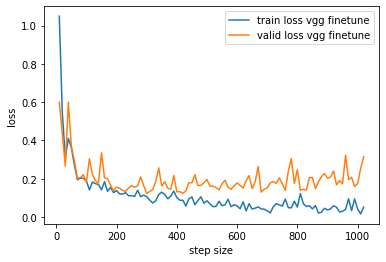

In [ ]:
plt.plot(step_axis_vgg2, train_loss_line_vgg2,label='train loss vgg finetune')
plt.plot(step_axis_vgg2, valid_loss_line_vgg2,label='valid loss vgg finetune')
plt.xlabel('step size')
plt.ylabel('loss')
plt.legend()

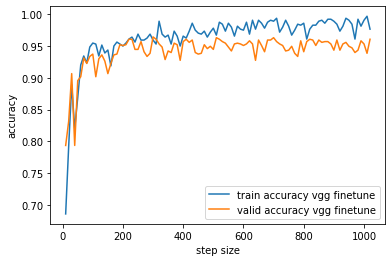

In [ ]:
plt.plot(step_axis_vgg2, train_accu_line_vgg2,label='train accuracy vgg finetune')
plt.plot(step_axis_vgg2, valid_accu_line_vgg2,label='valid accuracy vgg finetune')
plt.xlabel('step size')
plt.ylabel('accuracy')
plt.legend()

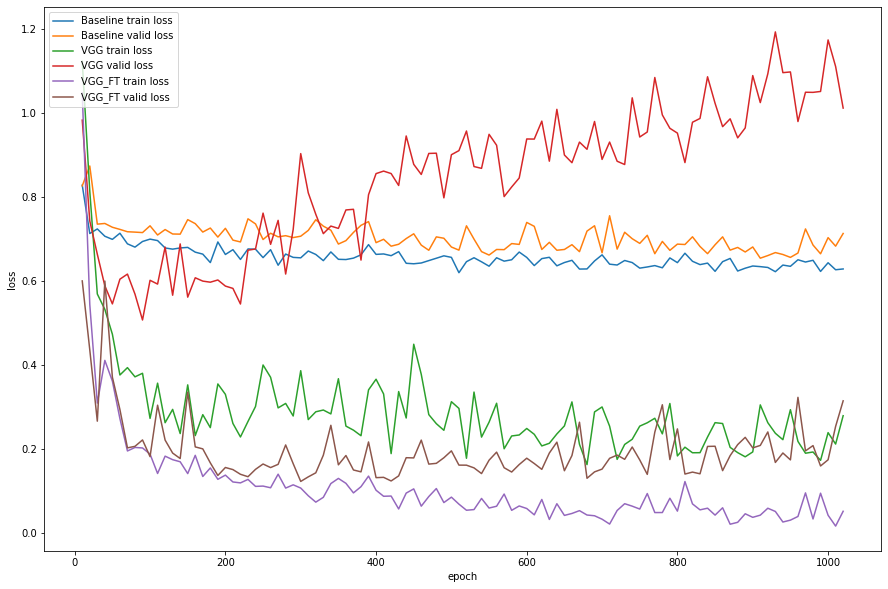

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(step_axis_base, train_loss_line_base,label='Baseline train loss')
plt.plot(step_axis_base, valid_loss_line_base,label='Baseline valid loss')

plt.plot(step_axis_base, train_loss_line_vgg,label='VGG train loss')
plt.plot(step_axis_base, valid_loss_line_vgg,label='VGG valid loss')

plt.plot(step_axis_base, train_loss_line_vgg2,label='VGG_FT train loss')
plt.plot(step_axis_base, valid_loss_line_vgg2,label='VGG_FT valid loss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc = 2)

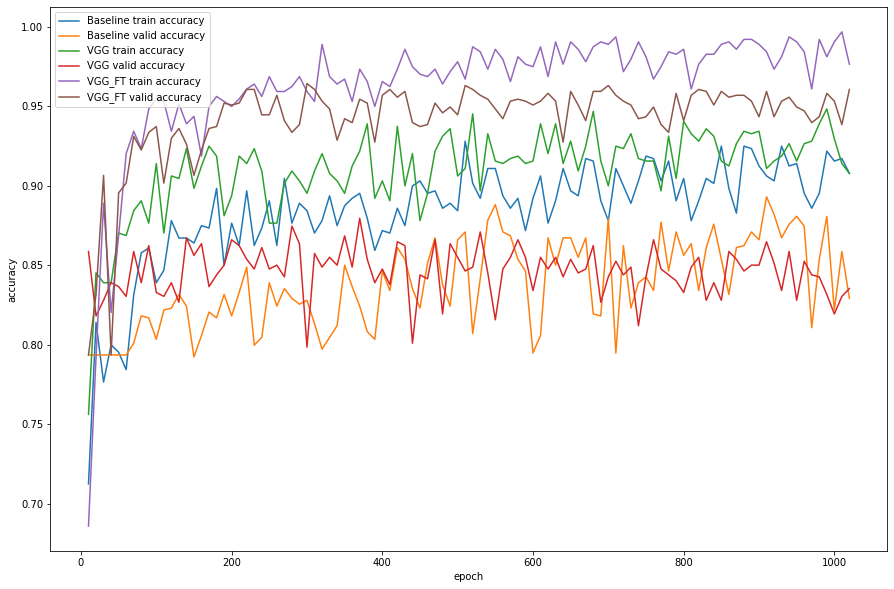

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(step_axis_base, train_accu_line_base,label='Baseline train accuracy')
plt.plot(step_axis_base, valid_accu_line_base,label='Baseline valid accuracy')

plt.plot(step_axis_base, train_accu_line_vgg,label='VGG train accuracy')
plt.plot(step_axis_base, valid_accu_line_vgg,label='VGG valid accuracy')

plt.plot(step_axis_base, train_accu_line_vgg2,label='VGG_FT train accuracy')
plt.plot(step_axis_base, valid_accu_line_vgg2,label='VGG_FT valid accuracy')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc = 2)

In [ ]:
d_list = [train_accu_line_vgg,valid_accu_line_vgg,train_loss_line_vgg,valid_loss_line_vgg]
df_vgg = pd.DataFrame.from_records(d_list)
df_vgg = df_vgg.T
df_vgg.columns = ['train_accu_line_vgg','valid_accu_line_vgg','train_loss_line_vgg','valid_loss_line_vgg']
df_vgg.to_csv('/content/drive/My Drive/comp4211/proj1/df_vgg.csv', header=True, index=False)

In [ ]:
df_vgg

train_accu_line_vgg  ... valid_loss_line_vgg
0    tensor(0.7563, device='cuda:0')  ...            0.983248
1    tensor(0.8453, device='cuda:0')  ...            0.742997
2    tensor(0.8391, device='cuda:0')  ...            0.663838
3    tensor(0.8391, device='cuda:0')  ...            0.588369
4    tensor(0.8703, device='cuda:0')  ...            0.545419
..                               ...  ...                 ...
97   tensor(0.9391, device='cuda:0')  ...             1.04938
98   tensor(0.9484, device='cuda:0')  ...             1.05153
99   tensor(0.9297, device='cuda:0')  ...             1.17427
100  tensor(0.9141, device='cuda:0')  ...             1.11096
101  tensor(0.9078, device='cuda:0')  ...             1.01195

[102 rows x 4 columns]

In [ ]:
d_list2 = [train_accu_line_vgg2,valid_accu_line_vgg2,train_loss_line_vgg2,valid_loss_line_vgg2]
df_vgg2 = pd.DataFrame.from_records(d_list2)
df_vgg2 = df_vgg2.T
df_vgg2.columns = ['train_accu_line_vgg2','valid_accu_line_vgg2','train_loss_line_vgg2','valid_loss_line_vgg2']
df_vgg2.to_csv('/content/drive/My Drive/comp4211/proj1/df_vgg_ft.csv', header=True, index=False)

In [ ]:
df_vgg2

train_accu_line_vgg2  ... valid_loss_line_vgg2
0    tensor(0.6859, device='cuda:0')  ...              0.60018
1    tensor(0.7922, device='cuda:0')  ...             0.435961
2    tensor(0.8891, device='cuda:0')  ...             0.266051
3    tensor(0.8203, device='cuda:0')  ...              0.59978
4    tensor(0.8688, device='cuda:0')  ...              0.37076
..                               ...  ...                  ...
97   tensor(0.9922, device='cuda:0')  ...             0.207853
98   tensor(0.9812, device='cuda:0')  ...             0.159333
99   tensor(0.9906, device='cuda:0')  ...             0.174023
100  tensor(0.9969, device='cuda:0')  ...               0.2536
101  tensor(0.9766, device='cuda:0')  ...             0.314489

[102 rows x 4 columns]

##Pretrained model -- resnet18

In [ ]:
transf_res = transforms.Compose(
    [transforms.Resize((32,32)), transforms.ToTensor()])

train_dataest_res = MaskDataset_clip(data_train_path, transforms=transf_res)
valid_dataest_res = MaskDataset_clip(data_valid_path, transforms=transf_res)

bs = 64

train_loader_res = DataLoader(train_dataest_res, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
valid_loader_res = DataLoader(valid_dataest_res, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True).cuda()
summary(resnet18, torch.zeros((64, 3, 32, 32)).cuda())

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



                                          Kernel Shape      Output Shape  \
Layer                                                                      
0_conv1                                  [3, 64, 7, 7]  [64, 64, 16, 16]   
1_bn1                                             [64]  [64, 64, 16, 16]   
2_relu                                               -  [64, 64, 16, 16]   
3_maxpool                                            -    [64, 64, 8, 8]   
4_layer1.0.Conv2d_conv1                 [64, 64, 3, 3]    [64, 64, 8, 8]   
5_layer1.0.BatchNorm2d_bn1                        [64]    [64, 64, 8, 8]   
6_layer1.0.ReLU_relu                                 -    [64, 64, 8, 8]   
7_layer1.0.Conv2d_conv2                 [64, 64, 3, 3]    [64, 64, 8, 8]   
8_layer1.0.BatchNorm2d_bn2                        [64]    [64, 64, 8, 8]   
9_layer1.0.ReLU_relu                                 -    [64, 64, 8, 8]   
10_layer1.1.Conv2d_conv1                [64, 64, 3, 3]    [64, 64, 8, 8]   
11_layer1.1

Kernel Shape  ...  Mult-Adds
Layer                                                   ...           
0_conv1                                  [3, 64, 7, 7]  ...  2408448.0
1_bn1                                             [64]  ...       64.0
2_relu                                               -  ...        NaN
3_maxpool                                            -  ...        NaN
4_layer1.0.Conv2d_conv1                 [64, 64, 3, 3]  ...  2359296.0
5_layer1.0.BatchNorm2d_bn1                        [64]  ...       64.0
6_layer1.0.ReLU_relu                                 -  ...        NaN
7_layer1.0.Conv2d_conv2                 [64, 64, 3, 3]  ...  2359296.0
8_layer1.0.BatchNorm2d_bn2                        [64]  ...       64.0
9_layer1.0.ReLU_relu                                 -  ...        NaN
10_layer1.1.Conv2d_conv1                [64, 64, 3, 3]  ...  2359296.0
11_layer1.1.BatchNorm2d_bn1                       [64]  ...       64.0
12_layer1.1.ReLU_relu                                -  ...        NaN
13_layer1.1.Conv2d_conv2                [64, 64, 3, 3]  ...  2359296.0
14_layer1.1.BatchNorm2d_bn2                       [64]  ...       64.0
15_layer1.1.ReLU_relu                                -  ...        NaN
16_layer2.0.Conv2d_conv1               [64, 128, 3, 3]  ...  1179648.0
17_layer2.0.BatchNorm2d_bn1                      [128]  ...      128.0
18_layer2.0.ReLU_relu                                -  ...        NaN
19_layer2.0.Conv2d_conv2              [128, 128, 3, 3]  ...  2359296.0
20_layer2.0.BatchNorm2d_bn2                      [128]  ...      128.0
21_layer2.0.downsample.Conv2d_0        [64, 128, 1, 1]  ...   131072.0
22_layer2.0.downsample.BatchNorm2d_1             [128]  ...      128.0
23_layer2.0.ReLU_relu                                -  ...        NaN
24_layer2.1.Conv2d_conv1              [128, 128, 3, 3]  ...  2359296.0
25_layer2.1.BatchNorm2d_bn1                      [128]  ...      128.0
26_layer2.1.ReLU_relu                                -  ...        NaN
27_layer2.1.Conv2d_conv2              [128, 128, 3, 3]  ...  2359296.0
28_layer2.1.BatchNorm2d_bn2                      [128]  ...      128.0
29_layer2.1.ReLU_relu                                -  ...        NaN
30_layer3.0.Conv2d_conv1              [128, 256, 3, 3]  ...  1179648.0
31_layer3.0.BatchNorm2d_bn1                      [256]  ...      256.0
32_layer3.0.ReLU_relu                                -  ...        NaN
33_layer3.0.Conv2d_conv2              [256, 256, 3, 3]  ...  2359296.0
34_layer3.0.BatchNorm2d_bn2                      [256]  ...      256.0
35_layer3.0.downsample.Conv2d_0       [128, 256, 1, 1]  ...   131072.0
36_layer3.0.downsample.BatchNorm2d_1             [256]  ...      256.0
37_layer3.0.ReLU_relu                                -  ...        NaN
38_layer3.1.Conv2d_conv1              [256, 256, 3, 3]  ...  2359296.0
39_layer3.1.BatchNorm2d_bn1                      [256]  ...      256.0
40_layer3.1.ReLU_relu                                -  ...        NaN
41_layer3.1.Conv2d_conv2              [256, 256, 3, 3]  ...  2359296.0
42_layer3.1.BatchNorm2d_bn2                      [256]  ...      256.0
43_layer3.1.ReLU_relu                                -  ...        NaN
44_layer4.0.Conv2d_conv1              [256, 512, 3, 3]  ...  1179648.0
45_layer4.0.BatchNorm2d_bn1                      [512]  ...      512.0
46_layer4.0.ReLU_relu                                -  ...        NaN
47_layer4.0.Conv2d_conv2              [512, 512, 3, 3]  ...  2359296.0
48_layer4.0.BatchNorm2d_bn2                      [512]  ...      512.0
49_layer4.0.downsample.Conv2d_0       [256, 512, 1, 1]  ...   131072.0
50_layer4.0.downsample.BatchNorm2d_1             [512]  ...      512.0
51_layer4.0.ReLU_relu                                -  ...        NaN
52_layer4.1.Conv2d_conv1              [512, 512, 3, 3]  ...  2359296.0
53_layer4.1.BatchNorm2d_bn1                      [512]  ...      512.0
54_layer4.1.ReLU_relu                                -  ...       

In [ ]:
class Modified_resnet18(nn.Module):

    def __init__(self):
        super(Modified_resnet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=True)

        for param in self.resnet18.parameters():
            param.requires_grad = False

        self.resnet18.fc = nn.Linear(512, 3)

    def forward(self, images):
        return self.resnet18(images)

modified_resnet18 = Modified_resnet18().cuda()
summary(modified_resnet18, torch.zeros((64, 3, 32, 32)).cuda())

                                                   Kernel Shape  \
Layer                                                             
0_resnet18.Conv2d_conv1                           [3, 64, 7, 7]   
1_resnet18.BatchNorm2d_bn1                                 [64]   
2_resnet18.ReLU_relu                                          -   
3_resnet18.MaxPool2d_maxpool                                  -   
4_resnet18.layer1.0.Conv2d_conv1                 [64, 64, 3, 3]   
5_resnet18.layer1.0.BatchNorm2d_bn1                        [64]   
6_resnet18.layer1.0.ReLU_relu                                 -   
7_resnet18.layer1.0.Conv2d_conv2                 [64, 64, 3, 3]   
8_resnet18.layer1.0.BatchNorm2d_bn2                        [64]   
9_resnet18.layer1.0.ReLU_relu                                 -   
10_resnet18.layer1.1.Conv2d_conv1                [64, 64, 3, 3]   
11_resnet18.layer1.1.BatchNorm2d_bn1                       [64]   
12_resnet18.layer1.1.ReLU_relu                                

Kernel Shape  ... Mult-Adds
Layer                                                            ...          
0_resnet18.Conv2d_conv1                           [3, 64, 7, 7]  ...       NaN
1_resnet18.BatchNorm2d_bn1                                 [64]  ...       NaN
2_resnet18.ReLU_relu                                          -  ...       NaN
3_resnet18.MaxPool2d_maxpool                                  -  ...       NaN
4_resnet18.layer1.0.Conv2d_conv1                 [64, 64, 3, 3]  ...       NaN
5_resnet18.layer1.0.BatchNorm2d_bn1                        [64]  ...       NaN
6_resnet18.layer1.0.ReLU_relu                                 -  ...       NaN
7_resnet18.layer1.0.Conv2d_conv2                 [64, 64, 3, 3]  ...       NaN
8_resnet18.layer1.0.BatchNorm2d_bn2                        [64]  ...       NaN
9_resnet18.layer1.0.ReLU_relu                                 -  ...       NaN
10_resnet18.layer1.1.Conv2d_conv1                [64, 64, 3, 3]  ...       NaN
11_resnet18.layer1.1.BatchNorm2d_bn1                       [64]  ...       NaN
12_resnet18.layer1.1.ReLU_relu                                -  ...       NaN
13_resnet18.layer1.1.Conv2d_conv2                [64, 64, 3, 3]  ...       NaN
14_resnet18.layer1.1.BatchNorm2d_bn2                       [64]  ...       NaN
15_resnet18.layer1.1.ReLU_relu                                -  ...       NaN
16_resnet18.layer2.0.Conv2d_conv1               [64, 128, 3, 3]  ...       NaN
17_resnet18.layer2.0.BatchNorm2d_bn1                      [128]  ...       NaN
18_resnet18.layer2.0.ReLU_relu                                -  ...       NaN
19_resnet18.layer2.0.Conv2d_conv2              [128, 128, 3, 3]  ...       NaN
20_resnet18.layer2.0.BatchNorm2d_bn2                      [128]  ...       NaN
21_resnet18.layer2.0.downsample.Conv2d_0        [64, 128, 1, 1]  ...       NaN
22_resnet18.layer2.0.downsample.BatchNorm2d_1             [128]  ...       NaN
23_resnet18.layer2.0.ReLU_relu                                -  ...       NaN
24_resnet18.layer2.1.Conv2d_conv1              [128, 128, 3, 3]  ...       NaN
25_resnet18.layer2.1.BatchNorm2d_bn1                      [128]  ...       NaN
26_resnet18.layer2.1.ReLU_relu                                -  ...       NaN
27_resnet18.layer2.1.Conv2d_conv2              [128, 128, 3, 3]  ...       NaN
28_resnet18.layer2.1.BatchNorm2d_bn2                      [128]  ...       NaN
29_resnet18.layer2.1.ReLU_relu                                -  ...       NaN
30_resnet18.layer3.0.Conv2d_conv1              [128, 256, 3, 3]  ...       NaN
31_resnet18.layer3.0.BatchNorm2d_bn1                      [256]  ...       NaN
32_resnet18.layer3.0.ReLU_relu                                -  ...       NaN
33_resnet18.layer3.0.Conv2d_conv2              [256, 256, 3, 3]  ...       NaN
34_resnet18.layer3.0.BatchNorm2d_bn2                      [256]  ...       NaN
35_resnet18.layer3.0.downsample.Conv2d_0       [128, 256, 1, 1]  ...       NaN
36_resnet18.layer3.0.downsample.BatchNorm2d_1             [256]  ...       NaN
37_resnet18.layer3.0.ReLU_relu                                -  ...       NaN
38_resnet18.layer3.1.Conv2d_conv1              [256, 256, 3, 3]  ...       NaN
39_resnet18.layer3.1.BatchNorm2d_bn1                      [256]  ...       NaN
40_resnet18.layer3.1.ReLU_relu                                -  ...       NaN
41_resnet18.layer3.1.Conv2d_conv2              [256, 256, 3, 3]  ...       NaN
42_resnet18.layer3.1.BatchNorm2d_bn2                      [256]  ...       NaN
43_resnet18.layer3.1.ReLU_relu                                -  ...       NaN
44_resnet18.layer4.0.Conv2d_conv1              [256, 512, 3, 3]  ...       NaN
45_resnet18.layer4.0.BatchNorm2d_bn1                      [512]  ...       NaN
46_resnet18.layer4.0.ReLU_relu                                -  ...       NaN
47_resnet18.layer4.0.Conv2d_conv2              [512, 512, 3, 3]  ...       NaN
48_resnet18.layer4.0.BatchNorm2d_bn2                      [512]  ...       NaN
49_resnet18.layer4.0.d

In [ ]:
num_epochs = 20
res18_optimizer = optim.Adam(modified_resnet18.parameters())
best_accu = None
criterion = nn.CrossEntropyLoss()
save_path = f'/content/drive/My Drive/comp4211/proj1/modified_res18.pt'

step_axis_res18,train_loss_line_res18,valid_loss_line_res18,train_accu_line_res18, valid_accu_line_res18 = TRAIN(modified_resnet18, train_loader_res, valid_loader_res, num_epochs, criterion, res18_optimizer, best_accu, device, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18.pt
Epoch [1/20], Train Loss: 0.7693, Train Acc: 0.7109, Valid Loss: 0.7528,  Valid Acc: 0.7899



Epoch [1/20], Train Loss: 0.6333, Train Acc: 0.7766, Valid Loss: 0.6611,  Valid Acc: 0.7690



Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18.pt
Epoch [1/20], Train Loss: 0.6265, Train Acc: 0.7672, Valid Loss: 0.5963,  Valid Acc: 0.7961



Epoch [1/20], Train Loss: 0.5422, Train Acc: 0.8250, Valid Loss: 0.5775,  Valid Acc: 0.7936



Epoch [1/20], Train Loss: 0.5753, Train Acc: 0.7719, Valid Loss: 0.5767,  Valid Acc: 0.7936




Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18.pt
Epoch [2/20], Train Loss: 0.5680, Train Acc: 0.7922, Valid Loss: 0.5567,  Valid Acc: 0.8133



Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18.pt
Epoch [2/20], Train Loss: 0.4818, Train Acc: 0.8047, Valid Loss: 0.5584,  Valid Acc: 0.8219



Epoch [2/20], Train Loss: 0.4809, Train Acc: 0.8359, Valid Loss: 0.5573,  Valid Acc: 0.8170



Epoch [2/20], Train Loss: 0.4410, Train Acc: 0.8438, Valid Loss: 0.5417,  Valid Acc: 0.8170



Epoch [2/20], Train Loss: 0.4283, Train Acc: 0.8516, Valid Loss: 0.5405,  Valid Acc: 0.8157




Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18.pt
Epoch [3/20], Train Loss: 0.4548, Train Acc: 0.8344, Valid Loss: 0.5269,  Valid Acc: 0.8231



Epoch [3/20], Train Loss: 0.4562, Train Acc: 0.8078, Valid Loss: 0.5301,  Valid Acc: 0.8219



Epoch [3/20], Train Loss: 0.4385, Train Acc: 0.8453, Valid Loss: 0.5340,  Valid Acc: 0.8206



Epoch [3/20], Train Loss: 0.4565, Train Acc: 0.8156, Valid Loss: 0.5348,  Valid Acc: 0.8231



Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18.pt
Epoch [3/20], Train Loss: 0.4167, Train Acc: 0.8578, Valid Loss: 0.5532,  Valid Acc: 0.8256




Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18.pt
Epoch [4/20], Train Loss: 0.4588, Train Acc: 0.8203, Valid Loss: 0.5044,  Valid Acc: 0.8354



Epoch [4/20], Train Loss: 0.4301, Train Acc: 0.8391, Valid Loss: 0.5043,  Valid Acc: 0.8305



Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18.pt
Epoch [4/20], Train Loss: 0.4110, Train Acc: 0.8531, Valid Loss: 0.5011,  Valid Acc: 0.8391



Epoch [4/20], Train Loss: 0.4243, Train Acc: 0.8375, Valid Loss: 0.5024,  Valid Acc: 0.8317



Epoch [4/20], Train Loss: 0.4037, Train Acc: 0.8562, Valid Loss: 0.5242,  Valid Acc: 0.8292




Epoch [5/20], Train Loss: 0.4094, Train Acc: 0.8281, Valid Loss: 0.5090,  Valid Acc: 0.8256



Epoch [5/20], Train Loss: 0.3814, Train Acc: 0.8688, Valid Loss: 0.5224,  Valid Acc: 0.8354



Epoch [5/20], Train Loss: 0.4341, Train Acc: 0.8281, Valid Loss: 0.5058,  Valid Acc: 0.8280



Epoch [5/20], Train Loss: 0.4034, Train Acc: 0.8594, Valid Loss: 0.5207,  Valid Acc: 0.8317



Epoch [5/20], Train Loss: 0.3901, Train Acc: 0.8547, Valid Loss: 0.4951,  Valid Acc: 0.8292




Epoch [6/20], Train Loss: 0.4003, Train Acc: 0.8516, Valid Loss: 0.4892,  Valid Acc: 0.8342



Epoch [6/20], Train Loss: 0.3781, Train Acc: 0.8578, Valid Loss: 0.4927,  Valid Acc: 0.8329



Epoch [6/20], Train Loss: 0.4326, Train Acc: 0.8359, Valid Loss: 0.4999,  Valid Acc: 0.8280



Epoch [6/20], Train Loss: 0.3810, Train Acc: 0.8656, Valid Loss: 0.5008,  Valid Acc: 0.8280



Epoch [6/20], Train Loss: 0.3831, Train Acc: 0.8453, Valid Loss: 0.5010,  Valid Acc: 0.8354




Epoch [7/20], Train Loss: 0.3955, Train Acc: 0.8578, Valid Loss: 0.4885,  Valid Acc: 0.8342



Epoch [7/20], Train Loss: 0.3620, Train Acc: 0.8734, Valid Loss: 0.4907,  Valid Acc: 0.8329



Epoch [7/20], Train Loss: 0.3431, Train Acc: 0.8578, Valid Loss: 0.4944,  Valid Acc: 0.8366



Epoch [7/20], Train Loss: 0.4213, Train Acc: 0.8578, Valid Loss: 0.4908,  Valid Acc: 0.8268



Epoch [7/20], Train Loss: 0.3491, Train Acc: 0.8594, Valid Loss: 0.4984,  Valid Acc: 0.8366




Epoch [8/20], Train Loss: 0.3963, Train Acc: 0.8578, Valid Loss: 0.4907,  Valid Acc: 0.8342



Epoch [8/20], Train Loss: 0.3713, Train Acc: 0.8703, Valid Loss: 0.4877,  Valid Acc: 0.8391



Epoch [8/20], Train Loss: 0.3771, Train Acc: 0.8562, Valid Loss: 0.4896,  Valid Acc: 0.8305



Epoch [8/20], Train Loss: 0.4109, Train Acc: 0.8453, Valid Loss: 0.5006,  Valid Acc: 0.8317



Epoch [8/20], Train Loss: 0.3726, Train Acc: 0.8672, Valid Loss: 0.4992,  Valid Acc: 0.8292




Epoch [9/20], Train Loss: 0.3335, Train Acc: 0.8734, Valid Loss: 0.4952,  Valid Acc: 0.8280



Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18.pt
Epoch [9/20], Train Loss: 0.4054, Train Acc: 0.8359, Valid Loss: 0.4853,  Valid Acc: 0.8428



Epoch [9/20], Train Loss: 0.3586, Train Acc: 0.8688, Valid Loss: 0.4895,  Valid Acc: 0.8354



Epoch [9/20], Train Loss: 0.3738, Train Acc: 0.8516, Valid Loss: 0.4967,  Valid Acc: 0.8366



Epoch [9/20], Train Loss: 0.3639, Train Acc: 0.8688, Valid Loss: 0.4914,  Valid Acc: 0.8403




Epoch [10/20], Train Loss: 0.3438, Train Acc: 0.8688, Valid Loss: 0.5016,  Valid Acc: 0.8329



Epoch [10/20], Train Loss: 0.3673, Train Acc: 0.8688, Valid Loss: 0.4926,  Valid Acc: 0.8305



Epoch [10/20], Train Loss: 0.3604, Train Acc: 0.8531, Valid Loss: 0.4827,  Valid Acc: 0.8305



Epoch [10/20], Train Loss: 0.3432, Train Acc: 0.8734, Valid Loss: 0.5081,  Valid Acc: 0.8354



Epoch [10/20], Train Loss: 0.3446, Train Acc: 0.8672, Valid Loss: 0.4931,  Valid Acc: 0.8329



Epoch [10/20], Train Loss: 0.3991, Train Acc: 0.8328, Valid Loss: 0.4912,  Valid Acc: 0.8366




Epoch [11/20], Train Loss: 0.3453, Train Acc: 0.8594, Valid Loss: 0.4970,  Valid Acc: 0.8366



Epoch [11/20], Train Loss: 0.3627, Train Acc: 0.8688, Valid Loss: 0.4987,  Valid Acc: 0.8354



Epoch [11/20], Train Loss: 0.3651, Train Acc: 0.8844, Valid Loss: 0.5024,  Valid Acc: 0.8256



Epoch [11/20], Train Loss: 0.3950, Train Acc: 0.8484, Valid Loss: 0.5025,  Valid Acc: 0.8219



Epoch [11/20], Train Loss: 0.3879, Train Acc: 0.8547, Valid Loss: 0.5157,  Valid Acc: 0.8305




Epoch [12/20], Train Loss: 0.3568, Train Acc: 0.8422, Valid Loss: 0.4977,  Valid Acc: 0.8231



Epoch [12/20], Train Loss: 0.3504, Train Acc: 0.8703, Valid Loss: 0.5001,  Valid Acc: 0.8292



Epoch [12/20], Train Loss: 0.3775, Train Acc: 0.8672, Valid Loss: 0.4968,  Valid Acc: 0.8378



Epoch [12/20], Train Loss: 0.3468, Train Acc: 0.8578, Valid Loss: 0.5133,  Valid Acc: 0.8317



Epoch [12/20], Train Loss: 0.3812, Train Acc: 0.8594, Valid Loss: 0.4919,  Valid Acc: 0.8366




Epoch [13/20], Train Loss: 0.3358, Train Acc: 0.8656, Valid Loss: 0.5072,  Valid Acc: 0.8305



Epoch [13/20], Train Loss: 0.3729, Train Acc: 0.8672, Valid Loss: 0.4916,  Valid Acc: 0.8280



Epoch [13/20], Train Loss: 0.3588, Train Acc: 0.8656, Valid Loss: 0.5099,  Valid Acc: 0.8305



Epoch [13/20], Train Loss: 0.3800, Train Acc: 0.8609, Valid Loss: 0.5111,  Valid Acc: 0.8231



Epoch [13/20], Train Loss: 0.3507, Train Acc: 0.8656, Valid Loss: 0.5485,  Valid Acc: 0.8280




Epoch [14/20], Train Loss: 0.4311, Train Acc: 0.8391, Valid Loss: 0.5137,  Valid Acc: 0.8206



Epoch [14/20], Train Loss: 0.3071, Train Acc: 0.8922, Valid Loss: 0.5012,  Valid Acc: 0.8354



Epoch [14/20], Train Loss: 0.3509, Train Acc: 0.8734, Valid Loss: 0.4999,  Valid Acc: 0.8329



Epoch [14/20], Train Loss: 0.3368, Train Acc: 0.8734, Valid Loss: 0.4889,  Valid Acc: 0.8378



Epoch [14/20], Train Loss: 0.3983, Train Acc: 0.8438, Valid Loss: 0.4890,  Valid Acc: 0.8415




Epoch [15/20], Train Loss: 0.3270, Train Acc: 0.8766, Valid Loss: 0.5107,  Valid Acc: 0.8378



Epoch [15/20], Train Loss: 0.3342, Train Acc: 0.8891, Valid Loss: 0.4969,  Valid Acc: 0.8391



Epoch [15/20], Train Loss: 0.3975, Train Acc: 0.8516, Valid Loss: 0.4907,  Valid Acc: 0.8366



Epoch [15/20], Train Loss: 0.3588, Train Acc: 0.8750, Valid Loss: 0.4859,  Valid Acc: 0.8317



Epoch [15/20], Train Loss: 0.3786, Train Acc: 0.8625, Valid Loss: 0.4941,  Valid Acc: 0.8317




Epoch [16/20], Train Loss: 0.3464, Train Acc: 0.8703, Valid Loss: 0.4913,  Valid Acc: 0.8354



Epoch [16/20], Train Loss: 0.3476, Train Acc: 0.8688, Valid Loss: 0.4823,  Valid Acc: 0.8366



Epoch [16/20], Train Loss: 0.3248, Train Acc: 0.8875, Valid Loss: 0.5014,  Valid Acc: 0.8366



Epoch [16/20], Train Loss: 0.3682, Train Acc: 0.8531, Valid Loss: 0.4929,  Valid Acc: 0.8329



Epoch [16/20], Train Loss: 0.3013, Train Acc: 0.8969, Valid Loss: 0.5043,  Valid Acc: 0.8391




Epoch [17/20], Train Loss: 0.3736, Train Acc: 0.8562, Valid Loss: 0.5017,  Valid Acc: 0.8403



Epoch [17/20], Train Loss: 0.3461, Train Acc: 0.8734, Valid Loss: 0.4932,  Valid Acc: 0.8354



Epoch [17/20], Train Loss: 0.3166, Train Acc: 0.8703, Valid Loss: 0.4967,  Valid Acc: 0.8329



Epoch [17/20], Train Loss: 0.3380, Train Acc: 0.8594, Valid Loss: 0.4924,  Valid Acc: 0.8378



Epoch [17/20], Train Loss: 0.3046, Train Acc: 0.8906, Valid Loss: 0.4961,  Valid Acc: 0.8354




Epoch [18/20], Train Loss: 0.3640, Train Acc: 0.8578, Valid Loss: 0.4987,  Valid Acc: 0.8342



Epoch [18/20], Train Loss: 0.3286, Train Acc: 0.8578, Valid Loss: 0.4987,  Valid Acc: 0.8403



Epoch [18/20], Train Loss: 0.3719, Train Acc: 0.8625, Valid Loss: 0.4947,  Valid Acc: 0.8366



Epoch [18/20], Train Loss: 0.3390, Train Acc: 0.8766, Valid Loss: 0.5203,  Valid Acc: 0.8415



Epoch [18/20], Train Loss: 0.3538, Train Acc: 0.8547, Valid Loss: 0.5028,  Valid Acc: 0.8354




Epoch [19/20], Train Loss: 0.3095, Train Acc: 0.8875, Valid Loss: 0.5193,  Valid Acc: 0.8403



Epoch [19/20], Train Loss: 0.3221, Train Acc: 0.8734, Valid Loss: 0.5034,  Valid Acc: 0.8329



Epoch [19/20], Train Loss: 0.3479, Train Acc: 0.8547, Valid Loss: 0.5001,  Valid Acc: 0.8317



Epoch [19/20], Train Loss: 0.2938, Train Acc: 0.8781, Valid Loss: 0.5282,  Valid Acc: 0.8391



Epoch [19/20], Train Loss: 0.4112, Train Acc: 0.8516, Valid Loss: 0.5048,  Valid Acc: 0.8219




Epoch [20/20], Train Loss: 0.3655, Train Acc: 0.8562, Valid Loss: 0.4904,  Valid Acc: 0.8415



Epoch [20/20], Train Loss: 0.3116, Train Acc: 0.8922, Valid Loss: 0.4979,  Valid Acc: 0.8391



Epoch [20/20], Train Loss: 0.3515, Train Acc: 0.8547, Valid Loss: 0.4975,  Valid Acc: 0.8292



Epoch [20/20], Train Loss: 0.3317, Train Acc: 0.8828, Valid Loss: 0.5158,  Valid Acc: 0.8342



Epoch [20/20], Train Loss: 0.3590, Train Acc: 0.8719, Valid Loss: 0.5107,  Valid Acc: 0.8378



Epoch [20/20], Train Loss: 0.3547, Train Acc: 0.8719, Valid Loss: 0.5034,  Valid Acc: 0.8391

Finished Training


###resnet18 -- finetune

In [ ]:
class Modified_resnet18_FT(nn.Module):

    def __init__(self):
        super(Modified_resnet18_FT, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=True)

        for param in self.resnet18.parameters():
            param.requires_grad = True

        self.resnet18.fc = nn.Linear(512, 3)

    def forward(self, images):
        return self.resnet18(images)

modified_resnet18_ft = Modified_resnet18_FT().cuda()
summary(modified_resnet18_ft, torch.zeros((64, 3, 32, 32)).cuda())

                                                   Kernel Shape  \
Layer                                                             
0_resnet18.Conv2d_conv1                           [3, 64, 7, 7]   
1_resnet18.BatchNorm2d_bn1                                 [64]   
2_resnet18.ReLU_relu                                          -   
3_resnet18.MaxPool2d_maxpool                                  -   
4_resnet18.layer1.0.Conv2d_conv1                 [64, 64, 3, 3]   
5_resnet18.layer1.0.BatchNorm2d_bn1                        [64]   
6_resnet18.layer1.0.ReLU_relu                                 -   
7_resnet18.layer1.0.Conv2d_conv2                 [64, 64, 3, 3]   
8_resnet18.layer1.0.BatchNorm2d_bn2                        [64]   
9_resnet18.layer1.0.ReLU_relu                                 -   
10_resnet18.layer1.1.Conv2d_conv1                [64, 64, 3, 3]   
11_resnet18.layer1.1.BatchNorm2d_bn1                       [64]   
12_resnet18.layer1.1.ReLU_relu                                

Kernel Shape  ...  Mult-Adds
Layer                                                            ...           
0_resnet18.Conv2d_conv1                           [3, 64, 7, 7]  ...  2408448.0
1_resnet18.BatchNorm2d_bn1                                 [64]  ...       64.0
2_resnet18.ReLU_relu                                          -  ...        NaN
3_resnet18.MaxPool2d_maxpool                                  -  ...        NaN
4_resnet18.layer1.0.Conv2d_conv1                 [64, 64, 3, 3]  ...  2359296.0
5_resnet18.layer1.0.BatchNorm2d_bn1                        [64]  ...       64.0
6_resnet18.layer1.0.ReLU_relu                                 -  ...        NaN
7_resnet18.layer1.0.Conv2d_conv2                 [64, 64, 3, 3]  ...  2359296.0
8_resnet18.layer1.0.BatchNorm2d_bn2                        [64]  ...       64.0
9_resnet18.layer1.0.ReLU_relu                                 -  ...        NaN
10_resnet18.layer1.1.Conv2d_conv1                [64, 64, 3, 3]  ...  2359296.0
11_resnet18.layer1.1.BatchNorm2d_bn1                       [64]  ...       64.0
12_resnet18.layer1.1.ReLU_relu                                -  ...        NaN
13_resnet18.layer1.1.Conv2d_conv2                [64, 64, 3, 3]  ...  2359296.0
14_resnet18.layer1.1.BatchNorm2d_bn2                       [64]  ...       64.0
15_resnet18.layer1.1.ReLU_relu                                -  ...        NaN
16_resnet18.layer2.0.Conv2d_conv1               [64, 128, 3, 3]  ...  1179648.0
17_resnet18.layer2.0.BatchNorm2d_bn1                      [128]  ...      128.0
18_resnet18.layer2.0.ReLU_relu                                -  ...        NaN
19_resnet18.layer2.0.Conv2d_conv2              [128, 128, 3, 3]  ...  2359296.0
20_resnet18.layer2.0.BatchNorm2d_bn2                      [128]  ...      128.0
21_resnet18.layer2.0.downsample.Conv2d_0        [64, 128, 1, 1]  ...   131072.0
22_resnet18.layer2.0.downsample.BatchNorm2d_1             [128]  ...      128.0
23_resnet18.layer2.0.ReLU_relu                                -  ...        NaN
24_resnet18.layer2.1.Conv2d_conv1              [128, 128, 3, 3]  ...  2359296.0
25_resnet18.layer2.1.BatchNorm2d_bn1                      [128]  ...      128.0
26_resnet18.layer2.1.ReLU_relu                                -  ...        NaN
27_resnet18.layer2.1.Conv2d_conv2              [128, 128, 3, 3]  ...  2359296.0
28_resnet18.layer2.1.BatchNorm2d_bn2                      [128]  ...      128.0
29_resnet18.layer2.1.ReLU_relu                                -  ...        NaN
30_resnet18.layer3.0.Conv2d_conv1              [128, 256, 3, 3]  ...  1179648.0
31_resnet18.layer3.0.BatchNorm2d_bn1                      [256]  ...      256.0
32_resnet18.layer3.0.ReLU_relu                                -  ...        NaN
33_resnet18.layer3.0.Conv2d_conv2              [256, 256, 3, 3]  ...  2359296.0
34_resnet18.layer3.0.BatchNorm2d_bn2                      [256]  ...      256.0
35_resnet18.layer3.0.downsample.Conv2d_0       [128, 256, 1, 1]  ...   131072.0
36_resnet18.layer3.0.downsample.BatchNorm2d_1             [256]  ...      256.0
37_resnet18.layer3.0.ReLU_relu                                -  ...        NaN
38_resnet18.layer3.1.Conv2d_conv1              [256, 256, 3, 3]  ...  2359296.0
39_resnet18.layer3.1.BatchNorm2d_bn1                      [256]  ...      256.0
40_resnet18.layer3.1.ReLU_relu                                -  ...        NaN
41_resnet18.layer3.1.Conv2d_conv2              [256, 256, 3, 3]  ...  2359296.0
42_resnet18.layer3.1.BatchNorm2d_bn2                      [256]  ...      256.0
43_resnet18.layer3.1.ReLU_relu                                -  ...        NaN
44_resnet18.layer4.0.Conv2d_conv1              [256, 512, 3, 3]  ...  1179648.0
45_resnet18.layer4.0.BatchNorm2d_bn1                      [512]  ...      512.0
46_resnet18.layer4.0.ReLU_relu                                -  ...        NaN
47_resnet18.layer4.0.Conv2d_conv2              [512, 512, 3, 3]  ...  2359296.0
48_resnet18.layer4.0.BatchNorm2d_bn2               

In [ ]:
num_epochs = 20
res18_optimizer = optim.Adam(modified_resnet18_ft.parameters())
best_accu = None
criterion = nn.CrossEntropyLoss()
save_path = f'/content/drive/My Drive/comp4211/proj1/modified_res18_ft.pt'

step_res18_ft,train_loss_res18_ft,valid_loss_res18_ft,train_accu_res18_ft, valid_accu_res18ft = TRAIN(modified_resnet18_ft, train_loader_res, valid_loader_res, num_epochs, criterion, res18_optimizer, best_accu, device, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18_ft.pt
Epoch [1/20], Train Loss: 0.6134, Train Acc: 0.7891, Valid Loss: 0.7386,  Valid Acc: 0.7727



Epoch [1/20], Train Loss: 0.2721, Train Acc: 0.9234, Valid Loss: 4.6041,  Valid Acc: 0.5725



Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18_ft.pt
Epoch [1/20], Train Loss: 0.2016, Train Acc: 0.9313, Valid Loss: 1.0150,  Valid Acc: 0.9177



Epoch [1/20], Train Loss: 0.1925, Train Acc: 0.9422, Valid Loss: 0.4262,  Valid Acc: 0.8919



Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18_ft.pt
Epoch [1/20], Train Loss: 0.2132, Train Acc: 0.9406, Valid Loss: 0.2492,  Valid Acc: 0.9337




Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18_ft.pt
Epoch [2/20], Train Loss: 0.1653, Train Acc: 0.9328, Valid Loss: 0.1534,  Valid Acc: 0.9496



Epoch [2/20], Train Loss: 0.1024, Train Acc: 0.9641, Valid Loss: 0.1943,  Valid Acc: 0.9226



Epoch [2/20], Train Loss: 0.1546, Train Acc: 0.9438, Valid Loss: 0.1671,  Valid Acc: 0.9398



Epoch [2/20], Train Loss: 0.1893, Train Acc: 0.9266, Valid Loss: 0.2054,  Valid Acc: 0.9201



Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18_ft.pt
Epoch [2/20], Train Loss: 0.1248, Train Acc: 0.9516, Valid Loss: 0.1806,  Valid Acc: 0.9509




Epoch [3/20], Train Loss: 0.1091, Train Acc: 0.9484, Valid Loss: 0.2146,  Valid Acc: 0.9238



Epoch [3/20], Train Loss: 0.1393, Train Acc: 0.9469, Valid Loss: 0.1581,  Valid Acc: 0.9423



Epoch [3/20], Train Loss: 0.0724, Train Acc: 0.9750, Valid Loss: 0.1494,  Valid Acc: 0.9484



Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18_ft.pt
Epoch [3/20], Train Loss: 0.0879, Train Acc: 0.9688, Valid Loss: 0.1168,  Valid Acc: 0.9681



Epoch [3/20], Train Loss: 0.0957, Train Acc: 0.9688, Valid Loss: 0.1306,  Valid Acc: 0.9619




Epoch [4/20], Train Loss: 0.0990, Train Acc: 0.9641, Valid Loss: 0.1539,  Valid Acc: 0.9386



Epoch [4/20], Train Loss: 0.0574, Train Acc: 0.9812, Valid Loss: 0.1187,  Valid Acc: 0.9619



Epoch [4/20], Train Loss: 0.0707, Train Acc: 0.9797, Valid Loss: 0.2691,  Valid Acc: 0.9337



Epoch [4/20], Train Loss: 0.1041, Train Acc: 0.9672, Valid Loss: 0.1681,  Valid Acc: 0.9521



Epoch [4/20], Train Loss: 0.1179, Train Acc: 0.9625, Valid Loss: 0.1734,  Valid Acc: 0.9459




Epoch [5/20], Train Loss: 0.1252, Train Acc: 0.9547, Valid Loss: 0.2153,  Valid Acc: 0.9349



Epoch [5/20], Train Loss: 0.0760, Train Acc: 0.9781, Valid Loss: 0.3689,  Valid Acc: 0.9349



Epoch [5/20], Train Loss: 0.0686, Train Acc: 0.9703, Valid Loss: 0.1691,  Valid Acc: 0.9509



Epoch [5/20], Train Loss: 0.0960, Train Acc: 0.9750, Valid Loss: 0.1776,  Valid Acc: 0.9423



Epoch [5/20], Train Loss: 0.0979, Train Acc: 0.9656, Valid Loss: 0.1524,  Valid Acc: 0.9484




Epoch [6/20], Train Loss: 0.0488, Train Acc: 0.9750, Valid Loss: 0.1328,  Valid Acc: 0.9607



Epoch [6/20], Train Loss: 0.0487, Train Acc: 0.9922, Valid Loss: 0.1249,  Valid Acc: 0.9681



Epoch [6/20], Train Loss: 0.0468, Train Acc: 0.9875, Valid Loss: 0.1428,  Valid Acc: 0.9570



Epoch [6/20], Train Loss: 0.0507, Train Acc: 0.9828, Valid Loss: 0.2007,  Valid Acc: 0.9472



Epoch [6/20], Train Loss: 0.0638, Train Acc: 0.9797, Valid Loss: 0.2089,  Valid Acc: 0.9484




Epoch [7/20], Train Loss: 0.0787, Train Acc: 0.9641, Valid Loss: 0.1875,  Valid Acc: 0.9533



Epoch [7/20], Train Loss: 0.0551, Train Acc: 0.9859, Valid Loss: 0.1873,  Valid Acc: 0.9423



Epoch [7/20], Train Loss: 0.0478, Train Acc: 0.9828, Valid Loss: 0.1262,  Valid Acc: 0.9681



Epoch [7/20], Train Loss: 0.0292, Train Acc: 0.9922, Valid Loss: 0.1821,  Valid Acc: 0.9484



Epoch [7/20], Train Loss: 0.0749, Train Acc: 0.9766, Valid Loss: 0.2098,  Valid Acc: 0.9447




Epoch [8/20], Train Loss: 0.0632, Train Acc: 0.9750, Valid Loss: 0.1726,  Valid Acc: 0.9423



Epoch [8/20], Train Loss: 0.0313, Train Acc: 0.9906, Valid Loss: 0.1532,  Valid Acc: 0.9435



Epoch [8/20], Train Loss: 0.0301, Train Acc: 0.9922, Valid Loss: 0.1306,  Valid Acc: 0.9595



Epoch [8/20], Train Loss: 0.0416, Train Acc: 0.9891, Valid Loss: 0.1984,  Valid Acc: 0.9484



Epoch [8/20], Train Loss: 0.0771, Train Acc: 0.9641, Valid Loss: 0.2045,  Valid Acc: 0.9509




Epoch [9/20], Train Loss: 0.0407, Train Acc: 0.9766, Valid Loss: 0.1935,  Valid Acc: 0.9509



Epoch [9/20], Train Loss: 0.0754, Train Acc: 0.9781, Valid Loss: 0.1552,  Valid Acc: 0.9558



Epoch [9/20], Train Loss: 0.0530, Train Acc: 0.9781, Valid Loss: 0.1622,  Valid Acc: 0.9472



Epoch [9/20], Train Loss: 0.0372, Train Acc: 0.9844, Valid Loss: 0.1418,  Valid Acc: 0.9509



Epoch [9/20], Train Loss: 0.0288, Train Acc: 0.9906, Valid Loss: 0.1533,  Valid Acc: 0.9509




Epoch [10/20], Train Loss: 0.0783, Train Acc: 0.9688, Valid Loss: 0.1564,  Valid Acc: 0.9619



Epoch [10/20], Train Loss: 0.0385, Train Acc: 0.9922, Valid Loss: 0.2185,  Valid Acc: 0.9410



Epoch [10/20], Train Loss: 0.0415, Train Acc: 0.9844, Valid Loss: 0.1447,  Valid Acc: 0.9533



Epoch [10/20], Train Loss: 0.0253, Train Acc: 0.9922, Valid Loss: 0.1264,  Valid Acc: 0.9607



Epoch [10/20], Train Loss: 0.0139, Train Acc: 0.9969, Valid Loss: 0.1520,  Valid Acc: 0.9644



Epoch [10/20], Train Loss: 0.0209, Train Acc: 0.9844, Valid Loss: 0.1527,  Valid Acc: 0.9607




Epoch [11/20], Train Loss: 0.0098, Train Acc: 0.9969, Valid Loss: 0.1437,  Valid Acc: 0.9607



Epoch [11/20], Train Loss: 0.0281, Train Acc: 0.9891, Valid Loss: 0.2014,  Valid Acc: 0.9533



Epoch [11/20], Train Loss: 0.0624, Train Acc: 0.9828, Valid Loss: 0.1818,  Valid Acc: 0.9459



Epoch [11/20], Train Loss: 0.0302, Train Acc: 0.9875, Valid Loss: 0.1462,  Valid Acc: 0.9533



Epoch [11/20], Train Loss: 0.0527, Train Acc: 0.9844, Valid Loss: 0.2177,  Valid Acc: 0.9472




Epoch [12/20], Train Loss: 0.0434, Train Acc: 0.9750, Valid Loss: 0.1932,  Valid Acc: 0.9558



Epoch [12/20], Train Loss: 0.0241, Train Acc: 0.9938, Valid Loss: 0.2295,  Valid Acc: 0.9484



Epoch [12/20], Train Loss: 0.0273, Train Acc: 0.9891, Valid Loss: 0.2007,  Valid Acc: 0.9545



Model saved to /content/drive/My Drive/comp4211/proj1/modified_res18_ft.pt
Epoch [12/20], Train Loss: 0.0397, Train Acc: 0.9891, Valid Loss: 0.1265,  Valid Acc: 0.9693



Epoch [12/20], Train Loss: 0.0155, Train Acc: 0.9953, Valid Loss: 0.2011,  Valid Acc: 0.9521




Epoch [13/20], Train Loss: 0.0926, Train Acc: 0.9625, Valid Loss: 0.3218,  Valid Acc: 0.9349



Epoch [13/20], Train Loss: 0.0696, Train Acc: 0.9797, Valid Loss: 0.1893,  Valid Acc: 0.9533



Epoch [13/20], Train Loss: 0.0894, Train Acc: 0.9656, Valid Loss: 0.1850,  Valid Acc: 0.9509



Epoch [13/20], Train Loss: 0.0322, Train Acc: 0.9906, Valid Loss: 0.1747,  Valid Acc: 0.9570



Epoch [13/20], Train Loss: 0.0445, Train Acc: 0.9859, Valid Loss: 0.2257,  Valid Acc: 0.9496




Epoch [14/20], Train Loss: 0.0244, Train Acc: 0.9828, Valid Loss: 0.1724,  Valid Acc: 0.9496



Epoch [14/20], Train Loss: 0.0257, Train Acc: 0.9922, Valid Loss: 0.1251,  Valid Acc: 0.9644



Epoch [14/20], Train Loss: 0.0221, Train Acc: 0.9953, Valid Loss: 0.1523,  Valid Acc: 0.9558



Epoch [14/20], Train Loss: 0.0617, Train Acc: 0.9812, Valid Loss: 0.1298,  Valid Acc: 0.9631



Epoch [14/20], Train Loss: 0.0655, Train Acc: 0.9812, Valid Loss: 0.1526,  Valid Acc: 0.9582




Epoch [15/20], Train Loss: 0.0331, Train Acc: 0.9766, Valid Loss: 0.1360,  Valid Acc: 0.9558



Epoch [15/20], Train Loss: 0.0252, Train Acc: 0.9906, Valid Loss: 0.2576,  Valid Acc: 0.9398



Epoch [15/20], Train Loss: 0.0204, Train Acc: 0.9906, Valid Loss: 0.2492,  Valid Acc: 0.9398



Epoch [15/20], Train Loss: 0.0354, Train Acc: 0.9891, Valid Loss: 0.2663,  Valid Acc: 0.9435



Epoch [15/20], Train Loss: 0.0522, Train Acc: 0.9859, Valid Loss: 0.1764,  Valid Acc: 0.9459




Epoch [16/20], Train Loss: 0.0337, Train Acc: 0.9781, Valid Loss: 0.1585,  Valid Acc: 0.9582



Epoch [16/20], Train Loss: 0.0228, Train Acc: 0.9906, Valid Loss: 0.1626,  Valid Acc: 0.9509



Epoch [16/20], Train Loss: 0.0095, Train Acc: 0.9969, Valid Loss: 0.1893,  Valid Acc: 0.9484



Epoch [16/20], Train Loss: 0.0079, Train Acc: 0.9969, Valid Loss: 0.1682,  Valid Acc: 0.9521



Epoch [16/20], Train Loss: 0.0296, Train Acc: 0.9906, Valid Loss: 0.2754,  Valid Acc: 0.9373




Epoch [17/20], Train Loss: 0.0462, Train Acc: 0.9734, Valid Loss: 0.1748,  Valid Acc: 0.9545



Epoch [17/20], Train Loss: 0.0319, Train Acc: 0.9906, Valid Loss: 0.1580,  Valid Acc: 0.9521



Epoch [17/20], Train Loss: 0.0156, Train Acc: 0.9953, Valid Loss: 0.1694,  Valid Acc: 0.9496



Epoch [17/20], Train Loss: 0.0180, Train Acc: 0.9922, Valid Loss: 0.1796,  Valid Acc: 0.9472



Epoch [17/20], Train Loss: 0.0103, Train Acc: 0.9984, Valid Loss: 0.1633,  Valid Acc: 0.9558




Epoch [18/20], Train Loss: 0.0099, Train Acc: 0.9875, Valid Loss: 0.2405,  Valid Acc: 0.9496



Epoch [18/20], Train Loss: 0.0112, Train Acc: 0.9953, Valid Loss: 0.3298,  Valid Acc: 0.9373



Epoch [18/20], Train Loss: 0.0109, Train Acc: 0.9969, Valid Loss: 0.2793,  Valid Acc: 0.9447



Epoch [18/20], Train Loss: 0.0125, Train Acc: 0.9953, Valid Loss: 0.2849,  Valid Acc: 0.9496



Epoch [18/20], Train Loss: 0.0212, Train Acc: 0.9938, Valid Loss: 0.2201,  Valid Acc: 0.9472




Epoch [19/20], Train Loss: 0.0186, Train Acc: 0.9859, Valid Loss: 0.1869,  Valid Acc: 0.9496



Epoch [19/20], Train Loss: 0.0233, Train Acc: 0.9984, Valid Loss: 0.2021,  Valid Acc: 0.9533



Epoch [19/20], Train Loss: 0.0050, Train Acc: 0.9984, Valid Loss: 0.2097,  Valid Acc: 0.9582



Epoch [19/20], Train Loss: 0.0064, Train Acc: 0.9969, Valid Loss: 0.2372,  Valid Acc: 0.9558



Epoch [19/20], Train Loss: 0.0535, Train Acc: 0.9859, Valid Loss: 0.3244,  Valid Acc: 0.9398




Epoch [20/20], Train Loss: 0.0849, Train Acc: 0.9641, Valid Loss: 0.5533,  Valid Acc: 0.8943



Epoch [20/20], Train Loss: 0.0830, Train Acc: 0.9672, Valid Loss: 0.1630,  Valid Acc: 0.9570



Epoch [20/20], Train Loss: 0.0486, Train Acc: 0.9781, Valid Loss: 0.1288,  Valid Acc: 0.9631



Epoch [20/20], Train Loss: 0.0216, Train Acc: 0.9938, Valid Loss: 0.1470,  Valid Acc: 0.9595



Epoch [20/20], Train Loss: 0.0309, Train Acc: 0.9906, Valid Loss: 0.1404,  Valid Acc: 0.9656



Epoch [20/20], Train Loss: 0.0230, Train Acc: 0.9797, Valid Loss: 0.1683,  Valid Acc: 0.9533

Finished Training


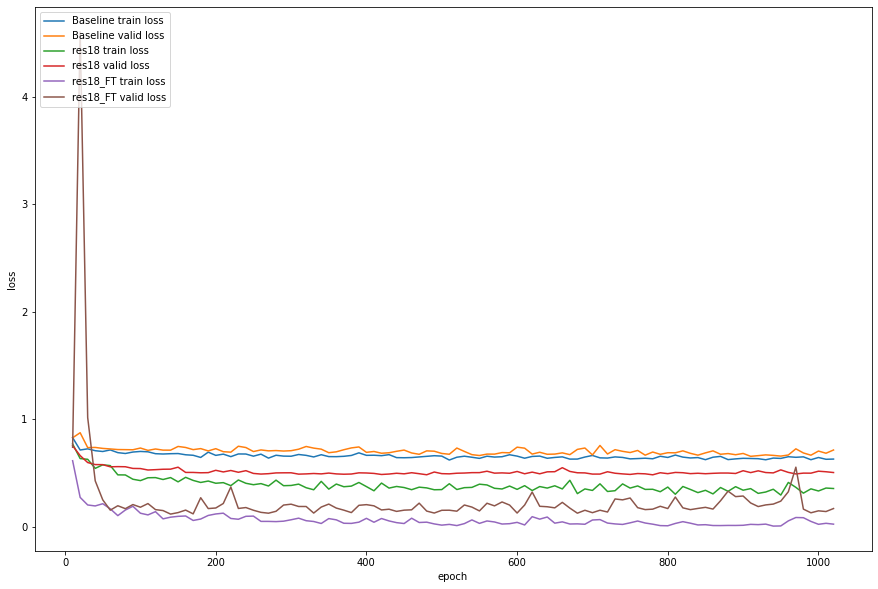

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(step_axis_base, train_loss_line_base,label='Baseline train loss')
plt.plot(step_axis_base, valid_loss_line_base,label='Baseline valid loss')

plt.plot(step_axis_base, train_loss_line_res18,label='res18 train loss')
plt.plot(step_axis_base, valid_loss_line_res18,label='res18 valid loss')

plt.plot(step_axis_base, train_loss_res18_ft,label='res18_FT train loss')
plt.plot(step_axis_base, valid_loss_res18_ft,label='res18_FT valid loss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc = 2)

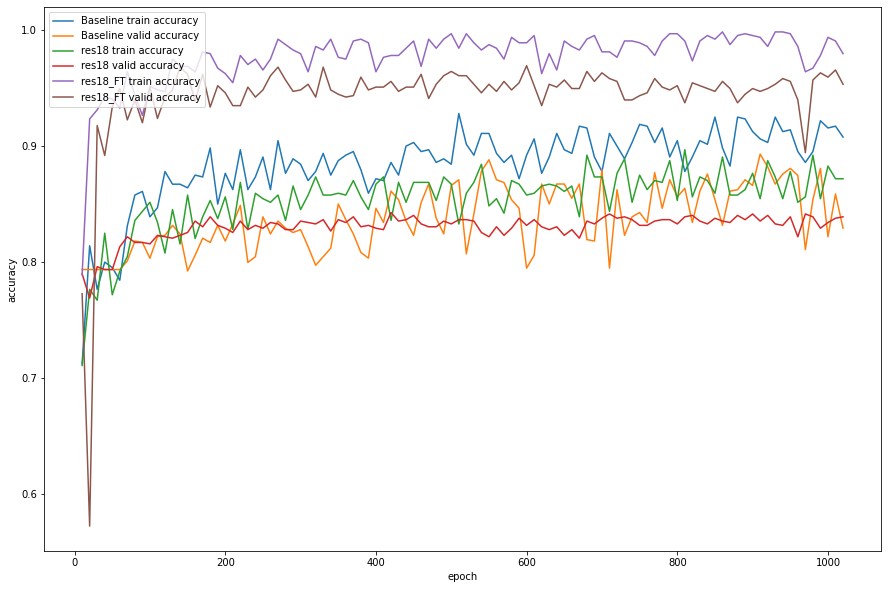

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(step_axis_base, train_accu_line_base,label='Baseline train accuracy')
plt.plot(step_axis_base, valid_accu_line_base,label='Baseline valid accuracy')

plt.plot(step_axis_base, train_accu_line_res18,label='res18 train accuracy')
plt.plot(step_axis_base, valid_accu_line_res18,label='res18 valid accuracy')

plt.plot(step_axis_base, train_accu_res18_ft,label='res18_FT train accuracy')
plt.plot(step_axis_base, valid_accu_res18ft,label='res18_FT valid accuracy')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc = 2)

#Augmentation method

##Image augmentation 1 based on Baseline model


In [ ]:
transf_1 = transforms.Compose(
    [transforms.Resize((32,32)), transforms.ToTensor(),transforms.RandomHorizontalFlip(p=0.9)])

train_dataest = MaskDataset_clip(data_train_path, transforms=transf_1)
valid_dataest = MaskDataset_clip(data_valid_path, transforms=transf_1)

bs = 64

train_loader = DataLoader(train_dataest, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataest, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Baseline_RGB(nn.Module):
    def __init__(self):
        super(Baseline_RGB, self).__init__()
        self.cnn_model = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2, 2, padding=0),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.AvgPool2d(16, 16)
        )
    
        d_in, d_out = 512, 3
        
        self.fc_layer = nn.Sequential(
            nn.Linear(d_in, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, d_out),
            nn.Sigmoid()

        )



    def forward(self, x):
    
        # out_dim = in_dim - kernel_size + 1  
        x = self.cnn_model(x)    
        x = x.view(-1,512)
        #x= x.float()

        x = self.fc_layer(x)
        #x= x.float()
        return x


In [ ]:
model = Baseline_RGB().to(device)
num_epochs = 20
best_val_accu = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
save_path = f'/content/drive/My Drive/comp4211/proj1/baseline_tf1.pt'

step_base_tf1 ,train_loss_base_tf1 ,valid_loss_base_tf1,train_accu_base_tf1, valid_accu_base_tf1 = TRAIN(model, train_loader, valid_loader, num_epochs, criterion, optimizer, best_val_accu, device, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf1.pt
Epoch [1/20], Train Loss: 0.8020, Train Acc: 0.7609, Valid Loss: 0.9313,  Valid Acc: 0.3415



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf1.pt
Epoch [1/20], Train Loss: 0.6674, Train Acc: 0.9031, Valid Loss: 0.8349,  Valid Acc: 0.6044



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf1.pt
Epoch [1/20], Train Loss: 0.6514, Train Acc: 0.8969, Valid Loss: 0.7163,  Valid Acc: 0.8231



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf1.pt
Epoch [1/20], Train Loss: 0.6386, Train Acc: 0.9125, Valid Loss: 0.6620,  Valid Acc: 0.8882



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf1.pt
Epoch [1/20], Train Loss: 0.6195, Train Acc: 0.9313, Valid Loss: 0.6299,  Valid Acc: 0.9214




Epoch [2/20], Train Loss: 0.6287, Train Acc: 0.9125, Valid Loss: 0.6458,  Valid Acc: 0.9079



Epoch [2/20], Train Loss: 0.6362, Train Acc: 0.9109, Valid Loss: 0.6607,  Valid Acc: 0.8857



Epoch [2/20], Train Loss: 0.6171, Train Acc: 0.9313, Valid Loss: 0.6254,  Valid Acc: 0.9201



Epoch [2/20], Train Loss: 0.6338, Train Acc: 0.9141, Valid Loss: 0.6337,  Valid Acc: 0.9177



Epoch [2/20], Train Loss: 0.6289, Train Acc: 0.9187, Valid Loss: 0.6977,  Valid Acc: 0.8477




Epoch [3/20], Train Loss: 0.6226, Train Acc: 0.9219, Valid Loss: 0.6267,  Valid Acc: 0.9189



Epoch [3/20], Train Loss: 0.6321, Train Acc: 0.9156, Valid Loss: 0.6363,  Valid Acc: 0.9091



Epoch [3/20], Train Loss: 0.6179, Train Acc: 0.9313, Valid Loss: 0.6407,  Valid Acc: 0.9091



Epoch [3/20], Train Loss: 0.6247, Train Acc: 0.9250, Valid Loss: 0.6445,  Valid Acc: 0.9017



Epoch [3/20], Train Loss: 0.6114, Train Acc: 0.9391, Valid Loss: 0.6302,  Valid Acc: 0.9201




Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf1.pt
Epoch [4/20], Train Loss: 0.6173, Train Acc: 0.9234, Valid Loss: 0.6191,  Valid Acc: 0.9238



Epoch [4/20], Train Loss: 0.6127, Train Acc: 0.9359, Valid Loss: 0.6332,  Valid Acc: 0.9115



Epoch [4/20], Train Loss: 0.6196, Train Acc: 0.9313, Valid Loss: 0.6694,  Valid Acc: 0.8784



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf1.pt
Epoch [4/20], Train Loss: 0.6092, Train Acc: 0.9422, Valid Loss: 0.6186,  Valid Acc: 0.9287



Epoch [4/20], Train Loss: 0.6160, Train Acc: 0.9359, Valid Loss: 0.6354,  Valid Acc: 0.9165




Epoch [5/20], Train Loss: 0.6074, Train Acc: 0.9281, Valid Loss: 0.6653,  Valid Acc: 0.8784



Epoch [5/20], Train Loss: 0.6193, Train Acc: 0.9297, Valid Loss: 0.6280,  Valid Acc: 0.9189



Epoch [5/20], Train Loss: 0.6408, Train Acc: 0.9062, Valid Loss: 0.6264,  Valid Acc: 0.9214



Epoch [5/20], Train Loss: 0.6056, Train Acc: 0.9453, Valid Loss: 0.6315,  Valid Acc: 0.9128



Epoch [5/20], Train Loss: 0.5994, Train Acc: 0.9531, Valid Loss: 0.6288,  Valid Acc: 0.9214




Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf1.pt
Epoch [6/20], Train Loss: 0.6132, Train Acc: 0.9281, Valid Loss: 0.6190,  Valid Acc: 0.9324



Epoch [6/20], Train Loss: 0.6067, Train Acc: 0.9438, Valid Loss: 0.6343,  Valid Acc: 0.9115



Epoch [6/20], Train Loss: 0.6163, Train Acc: 0.9375, Valid Loss: 0.6374,  Valid Acc: 0.9091



Epoch [6/20], Train Loss: 0.6204, Train Acc: 0.9297, Valid Loss: 0.6269,  Valid Acc: 0.9238



Epoch [6/20], Train Loss: 0.6277, Train Acc: 0.9187, Valid Loss: 0.6430,  Valid Acc: 0.9042




Epoch [7/20], Train Loss: 0.6230, Train Acc: 0.9156, Valid Loss: 0.6235,  Valid Acc: 0.9201



Epoch [7/20], Train Loss: 0.6087, Train Acc: 0.9438, Valid Loss: 0.6280,  Valid Acc: 0.9214



Epoch [7/20], Train Loss: 0.6060, Train Acc: 0.9453, Valid Loss: 0.6744,  Valid Acc: 0.8722



Epoch [7/20], Train Loss: 0.6301, Train Acc: 0.9156, Valid Loss: 0.6225,  Valid Acc: 0.9238



Epoch [7/20], Train Loss: 0.6161, Train Acc: 0.9344, Valid Loss: 0.6172,  Valid Acc: 0.9312




Epoch [8/20], Train Loss: 0.6096, Train Acc: 0.9297, Valid Loss: 0.6261,  Valid Acc: 0.9238



Epoch [8/20], Train Loss: 0.6115, Train Acc: 0.9375, Valid Loss: 0.6185,  Valid Acc: 0.9300



Epoch [8/20], Train Loss: 0.6157, Train Acc: 0.9359, Valid Loss: 0.6358,  Valid Acc: 0.9177



Epoch [8/20], Train Loss: 0.6290, Train Acc: 0.9250, Valid Loss: 0.6250,  Valid Acc: 0.9238



Epoch [8/20], Train Loss: 0.6160, Train Acc: 0.9328, Valid Loss: 0.6190,  Valid Acc: 0.9300




Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf1.pt
Epoch [9/20], Train Loss: 0.5996, Train Acc: 0.9406, Valid Loss: 0.6157,  Valid Acc: 0.9337



Epoch [9/20], Train Loss: 0.6326, Train Acc: 0.9187, Valid Loss: 0.6769,  Valid Acc: 0.8661



Epoch [9/20], Train Loss: 0.6234, Train Acc: 0.9297, Valid Loss: 0.6870,  Valid Acc: 0.8612



Epoch [9/20], Train Loss: 0.6049, Train Acc: 0.9422, Valid Loss: 0.6309,  Valid Acc: 0.9165



Epoch [9/20], Train Loss: 0.6032, Train Acc: 0.9484, Valid Loss: 0.6256,  Valid Acc: 0.9263




Epoch [10/20], Train Loss: 0.6211, Train Acc: 0.9172, Valid Loss: 0.6594,  Valid Acc: 0.8870



Epoch [10/20], Train Loss: 0.6111, Train Acc: 0.9438, Valid Loss: 0.6521,  Valid Acc: 0.8931



Epoch [10/20], Train Loss: 0.6043, Train Acc: 0.9438, Valid Loss: 0.6182,  Valid Acc: 0.9324



Epoch [10/20], Train Loss: 0.6086, Train Acc: 0.9438, Valid Loss: 0.6251,  Valid Acc: 0.9275



Epoch [10/20], Train Loss: 0.5995, Train Acc: 0.9484, Valid Loss: 0.6170,  Valid Acc: 0.9312



Epoch [10/20], Train Loss: 0.6169, Train Acc: 0.9219, Valid Loss: 0.6540,  Valid Acc: 0.8968




Epoch [11/20], Train Loss: 0.6033, Train Acc: 0.9484, Valid Loss: 0.6419,  Valid Acc: 0.9079



Epoch [11/20], Train Loss: 0.6082, Train Acc: 0.9406, Valid Loss: 0.6381,  Valid Acc: 0.9091



Epoch [11/20], Train Loss: 0.6164, Train Acc: 0.9328, Valid Loss: 0.6335,  Valid Acc: 0.9140



Epoch [11/20], Train Loss: 0.6190, Train Acc: 0.9328, Valid Loss: 0.6229,  Valid Acc: 0.9238



Epoch [11/20], Train Loss: 0.6173, Train Acc: 0.9359, Valid Loss: 0.6294,  Valid Acc: 0.9201




Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf1.pt
Epoch [12/20], Train Loss: 0.5992, Train Acc: 0.9438, Valid Loss: 0.6143,  Valid Acc: 0.9349



Epoch [12/20], Train Loss: 0.6106, Train Acc: 0.9391, Valid Loss: 0.6216,  Valid Acc: 0.9263



Epoch [12/20], Train Loss: 0.6125, Train Acc: 0.9375, Valid Loss: 0.6226,  Valid Acc: 0.9300



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf1.pt
Epoch [12/20], Train Loss: 0.6213, Train Acc: 0.9281, Valid Loss: 0.6120,  Valid Acc: 0.9386



Epoch [12/20], Train Loss: 0.6036, Train Acc: 0.9469, Valid Loss: 0.6328,  Valid Acc: 0.9189




Epoch [13/20], Train Loss: 0.6021, Train Acc: 0.9375, Valid Loss: 0.6335,  Valid Acc: 0.9152



Epoch [13/20], Train Loss: 0.6157, Train Acc: 0.9375, Valid Loss: 0.6384,  Valid Acc: 0.9091



Epoch [13/20], Train Loss: 0.6157, Train Acc: 0.9359, Valid Loss: 0.6158,  Valid Acc: 0.9324



Epoch [13/20], Train Loss: 0.6070, Train Acc: 0.9438, Valid Loss: 0.6198,  Valid Acc: 0.9300



Epoch [13/20], Train Loss: 0.6122, Train Acc: 0.9391, Valid Loss: 0.6220,  Valid Acc: 0.9238




Epoch [14/20], Train Loss: 0.6079, Train Acc: 0.9328, Valid Loss: 0.6180,  Valid Acc: 0.9312



Epoch [14/20], Train Loss: 0.6075, Train Acc: 0.9453, Valid Loss: 0.6253,  Valid Acc: 0.9251



Epoch [14/20], Train Loss: 0.6154, Train Acc: 0.9344, Valid Loss: 0.6177,  Valid Acc: 0.9312



Epoch [14/20], Train Loss: 0.6061, Train Acc: 0.9453, Valid Loss: 0.6142,  Valid Acc: 0.9349



Epoch [14/20], Train Loss: 0.6101, Train Acc: 0.9406, Valid Loss: 0.6372,  Valid Acc: 0.9091




Epoch [15/20], Train Loss: 0.6019, Train Acc: 0.9375, Valid Loss: 0.6214,  Valid Acc: 0.9263



Epoch [15/20], Train Loss: 0.6161, Train Acc: 0.9328, Valid Loss: 0.6351,  Valid Acc: 0.9091



Epoch [15/20], Train Loss: 0.6139, Train Acc: 0.9375, Valid Loss: 0.6194,  Valid Acc: 0.9312



Epoch [15/20], Train Loss: 0.6156, Train Acc: 0.9359, Valid Loss: 0.6147,  Valid Acc: 0.9324



Epoch [15/20], Train Loss: 0.5877, Train Acc: 0.9625, Valid Loss: 0.6173,  Valid Acc: 0.9300




Epoch [16/20], Train Loss: 0.5994, Train Acc: 0.9422, Valid Loss: 0.6112,  Valid Acc: 0.9386



Epoch [16/20], Train Loss: 0.6082, Train Acc: 0.9438, Valid Loss: 0.6142,  Valid Acc: 0.9386



Epoch [16/20], Train Loss: 0.6085, Train Acc: 0.9438, Valid Loss: 0.6120,  Valid Acc: 0.9373



Epoch [16/20], Train Loss: 0.6017, Train Acc: 0.9484, Valid Loss: 0.6141,  Valid Acc: 0.9349



Epoch [16/20], Train Loss: 0.5960, Train Acc: 0.9563, Valid Loss: 0.6279,  Valid Acc: 0.9251




Epoch [17/20], Train Loss: 0.6061, Train Acc: 0.9344, Valid Loss: 0.6549,  Valid Acc: 0.8943



Epoch [17/20], Train Loss: 0.6225, Train Acc: 0.9281, Valid Loss: 0.6380,  Valid Acc: 0.9115



Epoch [17/20], Train Loss: 0.6047, Train Acc: 0.9469, Valid Loss: 0.6241,  Valid Acc: 0.9238



Epoch [17/20], Train Loss: 0.5960, Train Acc: 0.9563, Valid Loss: 0.6669,  Valid Acc: 0.8796



Epoch [17/20], Train Loss: 0.6306, Train Acc: 0.9187, Valid Loss: 0.6523,  Valid Acc: 0.8907




Epoch [18/20], Train Loss: 0.6247, Train Acc: 0.9172, Valid Loss: 0.6789,  Valid Acc: 0.8698



Epoch [18/20], Train Loss: 0.6006, Train Acc: 0.9531, Valid Loss: 0.6392,  Valid Acc: 0.9066



Epoch [18/20], Train Loss: 0.6069, Train Acc: 0.9438, Valid Loss: 0.6165,  Valid Acc: 0.9312



Epoch [18/20], Train Loss: 0.6058, Train Acc: 0.9453, Valid Loss: 0.6214,  Valid Acc: 0.9287



Epoch [18/20], Train Loss: 0.5979, Train Acc: 0.9531, Valid Loss: 0.6185,  Valid Acc: 0.9324




Epoch [19/20], Train Loss: 0.6021, Train Acc: 0.9422, Valid Loss: 0.6197,  Valid Acc: 0.9312



Epoch [19/20], Train Loss: 0.6065, Train Acc: 0.9453, Valid Loss: 0.6194,  Valid Acc: 0.9300



Epoch [19/20], Train Loss: 0.6050, Train Acc: 0.9469, Valid Loss: 0.6446,  Valid Acc: 0.9029



Epoch [19/20], Train Loss: 0.6094, Train Acc: 0.9406, Valid Loss: 0.6225,  Valid Acc: 0.9251



Epoch [19/20], Train Loss: 0.6092, Train Acc: 0.9406, Valid Loss: 0.6319,  Valid Acc: 0.9177




Epoch [20/20], Train Loss: 0.6139, Train Acc: 0.9297, Valid Loss: 0.6436,  Valid Acc: 0.9029



Epoch [20/20], Train Loss: 0.6007, Train Acc: 0.9469, Valid Loss: 0.6407,  Valid Acc: 0.9115



Epoch [20/20], Train Loss: 0.6070, Train Acc: 0.9406, Valid Loss: 0.6155,  Valid Acc: 0.9349



Epoch [20/20], Train Loss: 0.6058, Train Acc: 0.9438, Valid Loss: 0.6219,  Valid Acc: 0.9287



Epoch [20/20], Train Loss: 0.5973, Train Acc: 0.9547, Valid Loss: 0.6220,  Valid Acc: 0.9300



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf1.pt
Epoch [20/20], Train Loss: 0.6063, Train Acc: 0.9375, Valid Loss: 0.6099,  Valid Acc: 0.9398

Finished Training


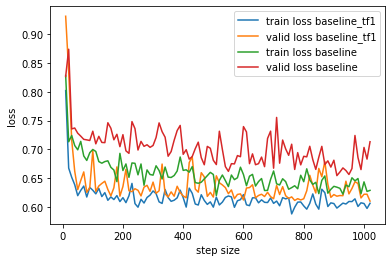

In [ ]:
plt.plot(step_axis_base, train_loss_base_tf1,label='train loss baseline_tf1')
plt.plot(step_axis_base, valid_loss_base_tf1,label='valid loss baseline_tf1')
plt.plot(step_axis_base, train_loss_line_base,label='train loss baseline')
plt.plot(step_axis_base, valid_loss_line_base,label='valid loss baseline')
plt.xlabel('step size')
plt.ylabel('loss')
plt.legend()

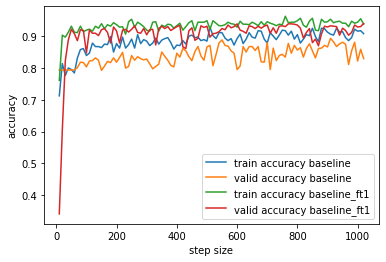

In [ ]:
plt.plot(step_axis_base, train_accu_line_base,label='train accuracy baseline')
plt.plot(step_axis_base, valid_accu_line_base,label='valid accuracy baseline')
plt.plot(step_axis_base, train_accu_base_tf1,label='train accuracy baseline_ft1')
plt.plot(step_axis_base, valid_accu_base_tf1,label='valid accuracy baseline_ft1')


plt.xlabel('step size')
plt.ylabel('accuracy')
plt.legend()

##Image augmentation 2 based on Baseline model

In [ ]:
transf_2 = transforms.Compose(
    [transforms.Resize((32,32)), transforms.ToTensor(),transforms.RandomHorizontalFlip(),transforms.RandomRotation(degrees=(10, 90))])

train_dataest = MaskDataset_clip(data_train_path, transforms=transf_2)
valid_dataest = MaskDataset_clip(data_valid_path, transforms=transf_2)

bs = 64

train_loader = DataLoader(train_dataest, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataest, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = Baseline_RGB().to(device)
num_epochs = 20
best_val_accu = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
save_path = f'/content/drive/My Drive/comp4211/proj1/baseline_tf2.pt'

step_base_tf2 ,train_loss_base_tf2 ,valid_loss_base_tf2,train_accu_base_tf2, valid_accu_base_tf2 = TRAIN(model, train_loader, valid_loader, num_epochs, criterion, optimizer, best_val_accu, device, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf2.pt
Epoch [1/20], Train Loss: 0.7915, Train Acc: 0.7359, Valid Loss: 0.8593,  Valid Acc: 0.7936



Epoch [1/20], Train Loss: 0.6644, Train Acc: 0.8266, Valid Loss: 0.8435,  Valid Acc: 0.4681



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf2.pt
Epoch [1/20], Train Loss: 0.6760, Train Acc: 0.8844, Valid Loss: 0.6945,  Valid Acc: 0.8477



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf2.pt
Epoch [1/20], Train Loss: 0.6685, Train Acc: 0.9031, Valid Loss: 0.6759,  Valid Acc: 0.8931



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf2.pt
Epoch [1/20], Train Loss: 0.6496, Train Acc: 0.9125, Valid Loss: 0.6323,  Valid Acc: 0.9214




Epoch [2/20], Train Loss: 0.6435, Train Acc: 0.9000, Valid Loss: 0.7490,  Valid Acc: 0.7875



Epoch [2/20], Train Loss: 0.6352, Train Acc: 0.9156, Valid Loss: 0.7263,  Valid Acc: 0.8243



Epoch [2/20], Train Loss: 0.6369, Train Acc: 0.9141, Valid Loss: 0.6453,  Valid Acc: 0.9066



Epoch [2/20], Train Loss: 0.6111, Train Acc: 0.9406, Valid Loss: 0.6640,  Valid Acc: 0.8808



Epoch [2/20], Train Loss: 0.6321, Train Acc: 0.9156, Valid Loss: 0.6499,  Valid Acc: 0.8980




Epoch [3/20], Train Loss: 0.6387, Train Acc: 0.9016, Valid Loss: 0.6455,  Valid Acc: 0.9029



Epoch [3/20], Train Loss: 0.6312, Train Acc: 0.9156, Valid Loss: 0.6364,  Valid Acc: 0.9103



Epoch [3/20], Train Loss: 0.6445, Train Acc: 0.9047, Valid Loss: 0.6424,  Valid Acc: 0.9017



Epoch [3/20], Train Loss: 0.6228, Train Acc: 0.9297, Valid Loss: 0.6475,  Valid Acc: 0.8993



Epoch [3/20], Train Loss: 0.6353, Train Acc: 0.9141, Valid Loss: 0.6383,  Valid Acc: 0.9103




Epoch [4/20], Train Loss: 0.6241, Train Acc: 0.9172, Valid Loss: 0.6394,  Valid Acc: 0.9029



Epoch [4/20], Train Loss: 0.6300, Train Acc: 0.9156, Valid Loss: 0.6498,  Valid Acc: 0.8956



Epoch [4/20], Train Loss: 0.6193, Train Acc: 0.9297, Valid Loss: 0.6306,  Valid Acc: 0.9201



Epoch [4/20], Train Loss: 0.6352, Train Acc: 0.9141, Valid Loss: 0.6589,  Valid Acc: 0.8882



Epoch [4/20], Train Loss: 0.6178, Train Acc: 0.9328, Valid Loss: 0.6373,  Valid Acc: 0.9115




Epoch [5/20], Train Loss: 0.6086, Train Acc: 0.9297, Valid Loss: 0.6293,  Valid Acc: 0.9177



Epoch [5/20], Train Loss: 0.6373, Train Acc: 0.9125, Valid Loss: 0.6494,  Valid Acc: 0.8968



Epoch [5/20], Train Loss: 0.6227, Train Acc: 0.9266, Valid Loss: 0.6708,  Valid Acc: 0.8735



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf2.pt
Epoch [5/20], Train Loss: 0.6231, Train Acc: 0.9266, Valid Loss: 0.6242,  Valid Acc: 0.9275



Epoch [5/20], Train Loss: 0.6103, Train Acc: 0.9406, Valid Loss: 0.6275,  Valid Acc: 0.9189




Epoch [6/20], Train Loss: 0.6415, Train Acc: 0.9000, Valid Loss: 0.7056,  Valid Acc: 0.8415



Epoch [6/20], Train Loss: 0.6194, Train Acc: 0.9281, Valid Loss: 0.7096,  Valid Acc: 0.8366



Epoch [6/20], Train Loss: 0.6340, Train Acc: 0.9172, Valid Loss: 0.6356,  Valid Acc: 0.9128



Epoch [6/20], Train Loss: 0.6211, Train Acc: 0.9297, Valid Loss: 0.6300,  Valid Acc: 0.9189



Epoch [6/20], Train Loss: 0.6240, Train Acc: 0.9281, Valid Loss: 0.6719,  Valid Acc: 0.8759




Epoch [7/20], Train Loss: 0.6167, Train Acc: 0.9234, Valid Loss: 0.6192,  Valid Acc: 0.9263



Epoch [7/20], Train Loss: 0.6142, Train Acc: 0.9375, Valid Loss: 0.6461,  Valid Acc: 0.9054



Epoch [7/20], Train Loss: 0.6182, Train Acc: 0.9328, Valid Loss: 0.6347,  Valid Acc: 0.9115



Epoch [7/20], Train Loss: 0.6311, Train Acc: 0.9156, Valid Loss: 0.6348,  Valid Acc: 0.9091



Epoch [7/20], Train Loss: 0.6279, Train Acc: 0.9250, Valid Loss: 0.6330,  Valid Acc: 0.9177




Epoch [8/20], Train Loss: 0.6335, Train Acc: 0.9000, Valid Loss: 0.6713,  Valid Acc: 0.8796



Epoch [8/20], Train Loss: 0.6126, Train Acc: 0.9375, Valid Loss: 0.6502,  Valid Acc: 0.8980



Epoch [8/20], Train Loss: 0.6229, Train Acc: 0.9281, Valid Loss: 0.6695,  Valid Acc: 0.8747



Epoch [8/20], Train Loss: 0.6354, Train Acc: 0.9109, Valid Loss: 0.6370,  Valid Acc: 0.9079



Epoch [8/20], Train Loss: 0.6323, Train Acc: 0.9234, Valid Loss: 0.6233,  Valid Acc: 0.9214




Epoch [9/20], Train Loss: 0.6146, Train Acc: 0.9250, Valid Loss: 0.6315,  Valid Acc: 0.9201



Epoch [9/20], Train Loss: 0.6191, Train Acc: 0.9313, Valid Loss: 0.6221,  Valid Acc: 0.9275



Epoch [9/20], Train Loss: 0.6194, Train Acc: 0.9266, Valid Loss: 0.6448,  Valid Acc: 0.9054



Epoch [9/20], Train Loss: 0.6148, Train Acc: 0.9328, Valid Loss: 0.6369,  Valid Acc: 0.9140



Epoch [9/20], Train Loss: 0.6200, Train Acc: 0.9313, Valid Loss: 0.6215,  Valid Acc: 0.9226




Epoch [10/20], Train Loss: 0.6241, Train Acc: 0.9203, Valid Loss: 0.6400,  Valid Acc: 0.9029



Epoch [10/20], Train Loss: 0.6192, Train Acc: 0.9281, Valid Loss: 0.6341,  Valid Acc: 0.9079



Epoch [10/20], Train Loss: 0.6072, Train Acc: 0.9422, Valid Loss: 0.6341,  Valid Acc: 0.9165



Epoch [10/20], Train Loss: 0.6087, Train Acc: 0.9422, Valid Loss: 0.6231,  Valid Acc: 0.9275



Epoch [10/20], Train Loss: 0.6306, Train Acc: 0.9187, Valid Loss: 0.6287,  Valid Acc: 0.9226



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf2.pt
Epoch [10/20], Train Loss: 0.6125, Train Acc: 0.9297, Valid Loss: 0.6203,  Valid Acc: 0.9312




Epoch [11/20], Train Loss: 0.6114, Train Acc: 0.9391, Valid Loss: 0.6434,  Valid Acc: 0.9054



Epoch [11/20], Train Loss: 0.6293, Train Acc: 0.9203, Valid Loss: 0.6370,  Valid Acc: 0.9091



Epoch [11/20], Train Loss: 0.6005, Train Acc: 0.9500, Valid Loss: 0.6210,  Valid Acc: 0.9287



Epoch [11/20], Train Loss: 0.6215, Train Acc: 0.9281, Valid Loss: 0.6945,  Valid Acc: 0.8489



Epoch [11/20], Train Loss: 0.6150, Train Acc: 0.9359, Valid Loss: 0.6385,  Valid Acc: 0.9115




Epoch [12/20], Train Loss: 0.6200, Train Acc: 0.9219, Valid Loss: 0.6430,  Valid Acc: 0.9005



Epoch [12/20], Train Loss: 0.6174, Train Acc: 0.9344, Valid Loss: 0.6262,  Valid Acc: 0.9238



Epoch [12/20], Train Loss: 0.6195, Train Acc: 0.9328, Valid Loss: 0.6219,  Valid Acc: 0.9238



Epoch [12/20], Train Loss: 0.6093, Train Acc: 0.9422, Valid Loss: 0.6981,  Valid Acc: 0.8501



Epoch [12/20], Train Loss: 0.6057, Train Acc: 0.9406, Valid Loss: 0.6421,  Valid Acc: 0.9066




Epoch [13/20], Train Loss: 0.6411, Train Acc: 0.9016, Valid Loss: 0.6608,  Valid Acc: 0.8894



Epoch [13/20], Train Loss: 0.6104, Train Acc: 0.9391, Valid Loss: 0.6509,  Valid Acc: 0.8943



Epoch [13/20], Train Loss: 0.6180, Train Acc: 0.9313, Valid Loss: 0.6508,  Valid Acc: 0.8968



Epoch [13/20], Train Loss: 0.6282, Train Acc: 0.9203, Valid Loss: 0.6749,  Valid Acc: 0.8710



Epoch [13/20], Train Loss: 0.6086, Train Acc: 0.9422, Valid Loss: 0.6269,  Valid Acc: 0.9214




Epoch [14/20], Train Loss: 0.6317, Train Acc: 0.9062, Valid Loss: 0.6372,  Valid Acc: 0.9128



Epoch [14/20], Train Loss: 0.6112, Train Acc: 0.9359, Valid Loss: 0.6449,  Valid Acc: 0.9054



Epoch [14/20], Train Loss: 0.6180, Train Acc: 0.9344, Valid Loss: 0.6676,  Valid Acc: 0.8784



Epoch [14/20], Train Loss: 0.6253, Train Acc: 0.9250, Valid Loss: 0.6273,  Valid Acc: 0.9201



Epoch [14/20], Train Loss: 0.6134, Train Acc: 0.9328, Valid Loss: 0.6326,  Valid Acc: 0.9189




Epoch [15/20], Train Loss: 0.6145, Train Acc: 0.9281, Valid Loss: 0.6238,  Valid Acc: 0.9226



Epoch [15/20], Train Loss: 0.6089, Train Acc: 0.9438, Valid Loss: 0.6414,  Valid Acc: 0.9054



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf2.pt
Epoch [15/20], Train Loss: 0.6164, Train Acc: 0.9313, Valid Loss: 0.6160,  Valid Acc: 0.9324



Epoch [15/20], Train Loss: 0.6083, Train Acc: 0.9438, Valid Loss: 0.6391,  Valid Acc: 0.9054



Epoch [15/20], Train Loss: 0.6262, Train Acc: 0.9219, Valid Loss: 0.6536,  Valid Acc: 0.8870




Epoch [16/20], Train Loss: 0.6128, Train Acc: 0.9297, Valid Loss: 0.6240,  Valid Acc: 0.9226



Epoch [16/20], Train Loss: 0.6171, Train Acc: 0.9344, Valid Loss: 0.6254,  Valid Acc: 0.9226



Epoch [16/20], Train Loss: 0.6169, Train Acc: 0.9344, Valid Loss: 0.6334,  Valid Acc: 0.9152



Epoch [16/20], Train Loss: 0.6204, Train Acc: 0.9266, Valid Loss: 0.6299,  Valid Acc: 0.9189



Epoch [16/20], Train Loss: 0.6251, Train Acc: 0.9219, Valid Loss: 0.6364,  Valid Acc: 0.9103




Epoch [17/20], Train Loss: 0.6202, Train Acc: 0.9141, Valid Loss: 0.6225,  Valid Acc: 0.9238



Epoch [17/20], Train Loss: 0.6058, Train Acc: 0.9438, Valid Loss: 0.6372,  Valid Acc: 0.9103



Epoch [17/20], Train Loss: 0.6227, Train Acc: 0.9203, Valid Loss: 0.6235,  Valid Acc: 0.9275



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf2.pt
Epoch [17/20], Train Loss: 0.6076, Train Acc: 0.9406, Valid Loss: 0.6145,  Valid Acc: 0.9349



Epoch [17/20], Train Loss: 0.6112, Train Acc: 0.9406, Valid Loss: 0.6251,  Valid Acc: 0.9238




Epoch [18/20], Train Loss: 0.6007, Train Acc: 0.9453, Valid Loss: 0.6256,  Valid Acc: 0.9238



Epoch [18/20], Train Loss: 0.6101, Train Acc: 0.9406, Valid Loss: 0.6266,  Valid Acc: 0.9214



Epoch [18/20], Train Loss: 0.6099, Train Acc: 0.9391, Valid Loss: 0.6207,  Valid Acc: 0.9238



Epoch [18/20], Train Loss: 0.5974, Train Acc: 0.9563, Valid Loss: 0.6203,  Valid Acc: 0.9226



Epoch [18/20], Train Loss: 0.6254, Train Acc: 0.9250, Valid Loss: 0.6246,  Valid Acc: 0.9226




Epoch [19/20], Train Loss: 0.6118, Train Acc: 0.9281, Valid Loss: 0.6163,  Valid Acc: 0.9312



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf2.pt
Epoch [19/20], Train Loss: 0.6168, Train Acc: 0.9328, Valid Loss: 0.6137,  Valid Acc: 0.9386



Epoch [19/20], Train Loss: 0.6144, Train Acc: 0.9359, Valid Loss: 0.6110,  Valid Acc: 0.9373



Epoch [19/20], Train Loss: 0.6118, Train Acc: 0.9391, Valid Loss: 0.6158,  Valid Acc: 0.9349



Epoch [19/20], Train Loss: 0.6049, Train Acc: 0.9438, Valid Loss: 0.6356,  Valid Acc: 0.9115




Epoch [20/20], Train Loss: 0.5971, Train Acc: 0.9438, Valid Loss: 0.6167,  Valid Acc: 0.9373



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf2.pt
Epoch [20/20], Train Loss: 0.6157, Train Acc: 0.9391, Valid Loss: 0.6067,  Valid Acc: 0.9423



Epoch [20/20], Train Loss: 0.6007, Train Acc: 0.9469, Valid Loss: 0.6080,  Valid Acc: 0.9410



Epoch [20/20], Train Loss: 0.6068, Train Acc: 0.9422, Valid Loss: 0.6123,  Valid Acc: 0.9337



Epoch [20/20], Train Loss: 0.6059, Train Acc: 0.9469, Valid Loss: 0.6167,  Valid Acc: 0.9324



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf2.pt
Epoch [20/20], Train Loss: 0.6093, Train Acc: 0.9297, Valid Loss: 0.6067,  Valid Acc: 0.9435

Finished Training


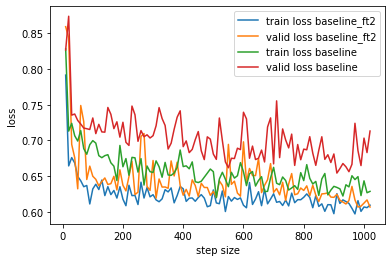

In [ ]:
plt.plot(step_axis_base, train_loss_base_tf2,label='train loss baseline_ft2')
plt.plot(step_axis_base, valid_loss_base_tf2,label='valid loss baseline_ft2')
plt.plot(step_axis_base, train_loss_line_base,label='train loss baseline')
plt.plot(step_axis_base, valid_loss_line_base,label='valid loss baseline')
plt.xlabel('step size')
plt.ylabel('loss')
plt.legend()

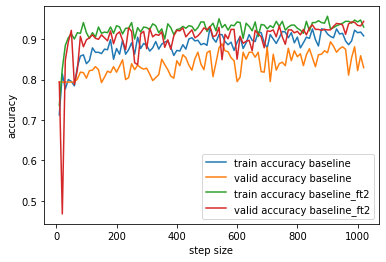

In [ ]:
plt.plot(step_axis_base, train_accu_line_base,label='train accuracy baseline')
plt.plot(step_axis_base, valid_accu_line_base,label='valid accuracy baseline')
plt.plot(step_axis_base, train_accu_base_tf2,label='train accuracy baseline_ft2')
plt.plot(step_axis_base, valid_accu_base_tf2,label='valid accuracy baseline_ft2')


plt.xlabel('step size')
plt.ylabel('accuracy')
plt.legend()

##Image augmentation 3 based on Baseline model

In [ ]:
transf_3 = transforms.Compose(
    [transforms.Resize((32,32)), transforms.ToTensor(),transforms.RandomHorizontalFlip(),transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5, hue=.5)])

train_dataest = MaskDataset_clip(data_train_path, transforms=transf_3)
valid_dataest = MaskDataset_clip(data_valid_path, transforms=transf_3)

bs = 64

train_loader = DataLoader(train_dataest, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataest, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = Baseline_RGB().to(device)
num_epochs = 20
best_val_accu = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
save_path = f'/content/drive/My Drive/comp4211/proj1/baseline_tf3.pt'

step_base_tf3 ,train_loss_base_tf3 ,valid_loss_base_tf3,train_accu_base_tf3, valid_accu_base_tf3 = TRAIN(model, train_loader, valid_loader, num_epochs, criterion, optimizer, best_val_accu, device, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf3.pt
Epoch [1/20], Train Loss: 0.8401, Train Acc: 0.7312, Valid Loss: 0.7695,  Valid Acc: 0.7936



Epoch [1/20], Train Loss: 0.7419, Train Acc: 0.7953, Valid Loss: 0.7445,  Valid Acc: 0.7936



Epoch [1/20], Train Loss: 0.7382, Train Acc: 0.7891, Valid Loss: 0.7312,  Valid Acc: 0.7936



Epoch [1/20], Train Loss: 0.7099, Train Acc: 0.7891, Valid Loss: 0.7255,  Valid Acc: 0.7936



Epoch [1/20], Train Loss: 0.7088, Train Acc: 0.8156, Valid Loss: 0.7513,  Valid Acc: 0.7936




Epoch [2/20], Train Loss: 0.7294, Train Acc: 0.7859, Valid Loss: 0.7148,  Valid Acc: 0.7936



Epoch [2/20], Train Loss: 0.7238, Train Acc: 0.7734, Valid Loss: 0.7320,  Valid Acc: 0.7936



Epoch [2/20], Train Loss: 0.6917, Train Acc: 0.8047, Valid Loss: 0.7092,  Valid Acc: 0.7936



Epoch [2/20], Train Loss: 0.7067, Train Acc: 0.7922, Valid Loss: 0.7062,  Valid Acc: 0.7936



Epoch [2/20], Train Loss: 0.6962, Train Acc: 0.8000, Valid Loss: 0.7420,  Valid Acc: 0.7936




Epoch [3/20], Train Loss: 0.6966, Train Acc: 0.7953, Valid Loss: 0.7190,  Valid Acc: 0.7936



Epoch [3/20], Train Loss: 0.7026, Train Acc: 0.7937, Valid Loss: 0.7183,  Valid Acc: 0.7936



Epoch [3/20], Train Loss: 0.7137, Train Acc: 0.7797, Valid Loss: 0.7726,  Valid Acc: 0.7936



Epoch [3/20], Train Loss: 0.6741, Train Acc: 0.8109, Valid Loss: 0.7312,  Valid Acc: 0.7936



Epoch [3/20], Train Loss: 0.7033, Train Acc: 0.7797, Valid Loss: 0.7772,  Valid Acc: 0.7936




Epoch [4/20], Train Loss: 0.6772, Train Acc: 0.8094, Valid Loss: 0.7131,  Valid Acc: 0.7936



Epoch [4/20], Train Loss: 0.7094, Train Acc: 0.7766, Valid Loss: 0.7218,  Valid Acc: 0.7936



Epoch [4/20], Train Loss: 0.6849, Train Acc: 0.8172, Valid Loss: 0.7000,  Valid Acc: 0.7936



Epoch [4/20], Train Loss: 0.6609, Train Acc: 0.8188, Valid Loss: 0.7121,  Valid Acc: 0.7936



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf3.pt
Epoch [4/20], Train Loss: 0.6819, Train Acc: 0.8156, Valid Loss: 0.7119,  Valid Acc: 0.8587




Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf3.pt
Epoch [5/20], Train Loss: 0.7073, Train Acc: 0.8562, Valid Loss: 0.6900,  Valid Acc: 0.8612



Epoch [5/20], Train Loss: 0.6757, Train Acc: 0.8641, Valid Loss: 0.7051,  Valid Acc: 0.8317



Epoch [5/20], Train Loss: 0.6759, Train Acc: 0.8656, Valid Loss: 0.6932,  Valid Acc: 0.8440



Epoch [5/20], Train Loss: 0.6792, Train Acc: 0.8719, Valid Loss: 0.7118,  Valid Acc: 0.8501



Epoch [5/20], Train Loss: 0.6844, Train Acc: 0.8750, Valid Loss: 0.6997,  Valid Acc: 0.8514




Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf3.pt
Epoch [6/20], Train Loss: 0.6797, Train Acc: 0.8813, Valid Loss: 0.6759,  Valid Acc: 0.8686



Epoch [6/20], Train Loss: 0.6447, Train Acc: 0.9109, Valid Loss: 0.6821,  Valid Acc: 0.8673



Epoch [6/20], Train Loss: 0.6650, Train Acc: 0.8828, Valid Loss: 1.0326,  Valid Acc: 0.4926



Epoch [6/20], Train Loss: 0.6670, Train Acc: 0.8844, Valid Loss: 0.6921,  Valid Acc: 0.8526



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf3.pt
Epoch [6/20], Train Loss: 0.6736, Train Acc: 0.8750, Valid Loss: 0.6488,  Valid Acc: 0.9005




Epoch [7/20], Train Loss: 0.6680, Train Acc: 0.8766, Valid Loss: 0.6865,  Valid Acc: 0.8526



Epoch [7/20], Train Loss: 0.6360, Train Acc: 0.9078, Valid Loss: 0.6651,  Valid Acc: 0.8821



Epoch [7/20], Train Loss: 0.6629, Train Acc: 0.8813, Valid Loss: 0.6636,  Valid Acc: 0.8796



Epoch [7/20], Train Loss: 0.6379, Train Acc: 0.9094, Valid Loss: 0.7312,  Valid Acc: 0.7961



Epoch [7/20], Train Loss: 0.6507, Train Acc: 0.8859, Valid Loss: 0.7429,  Valid Acc: 0.7887




Epoch [8/20], Train Loss: 0.6618, Train Acc: 0.8750, Valid Loss: 0.6804,  Valid Acc: 0.8612



Epoch [8/20], Train Loss: 0.6695, Train Acc: 0.8750, Valid Loss: 0.7272,  Valid Acc: 0.8047



Epoch [8/20], Train Loss: 0.6734, Train Acc: 0.8750, Valid Loss: 0.6601,  Valid Acc: 0.8882



Epoch [8/20], Train Loss: 0.6482, Train Acc: 0.8922, Valid Loss: 0.6787,  Valid Acc: 0.8587



Epoch [8/20], Train Loss: 0.6498, Train Acc: 0.9031, Valid Loss: 0.6886,  Valid Acc: 0.8514




Epoch [9/20], Train Loss: 0.6368, Train Acc: 0.9062, Valid Loss: 0.6797,  Valid Acc: 0.8624



Epoch [9/20], Train Loss: 0.6494, Train Acc: 0.8922, Valid Loss: 0.6725,  Valid Acc: 0.8710



Epoch [9/20], Train Loss: 0.6433, Train Acc: 0.9016, Valid Loss: 0.6547,  Valid Acc: 0.8907



Epoch [9/20], Train Loss: 0.6556, Train Acc: 0.8859, Valid Loss: 0.6683,  Valid Acc: 0.8735



Epoch [9/20], Train Loss: 0.6471, Train Acc: 0.9062, Valid Loss: 0.7035,  Valid Acc: 0.8452




Epoch [10/20], Train Loss: 0.6604, Train Acc: 0.8797, Valid Loss: 0.6759,  Valid Acc: 0.8673



Epoch [10/20], Train Loss: 0.6263, Train Acc: 0.9281, Valid Loss: 0.6510,  Valid Acc: 0.8968



Epoch [10/20], Train Loss: 0.6589, Train Acc: 0.8828, Valid Loss: 0.6825,  Valid Acc: 0.8575



Epoch [10/20], Train Loss: 0.6567, Train Acc: 0.8984, Valid Loss: 0.6525,  Valid Acc: 0.8980



Epoch [10/20], Train Loss: 0.6408, Train Acc: 0.8969, Valid Loss: 0.7023,  Valid Acc: 0.8415



Epoch [10/20], Train Loss: 0.6567, Train Acc: 0.8813, Valid Loss: 0.6916,  Valid Acc: 0.8526




Epoch [11/20], Train Loss: 0.6568, Train Acc: 0.8828, Valid Loss: 0.7005,  Valid Acc: 0.8428



Epoch [11/20], Train Loss: 0.6316, Train Acc: 0.9172, Valid Loss: 0.6686,  Valid Acc: 0.8821



Epoch [11/20], Train Loss: 0.6392, Train Acc: 0.9031, Valid Loss: 0.6487,  Valid Acc: 0.8968



Epoch [11/20], Train Loss: 0.6583, Train Acc: 0.8969, Valid Loss: 0.6609,  Valid Acc: 0.8870



Epoch [11/20], Train Loss: 0.6346, Train Acc: 0.9125, Valid Loss: 0.6814,  Valid Acc: 0.8575




Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf3.pt
Epoch [12/20], Train Loss: 0.6552, Train Acc: 0.8844, Valid Loss: 0.6440,  Valid Acc: 0.9054



Epoch [12/20], Train Loss: 0.6490, Train Acc: 0.8984, Valid Loss: 0.7347,  Valid Acc: 0.7948



Epoch [12/20], Train Loss: 0.6472, Train Acc: 0.9031, Valid Loss: 0.6786,  Valid Acc: 0.8612



Epoch [12/20], Train Loss: 0.6484, Train Acc: 0.9016, Valid Loss: 0.6451,  Valid Acc: 0.8993



Epoch [12/20], Train Loss: 0.6421, Train Acc: 0.9031, Valid Loss: 0.6668,  Valid Acc: 0.8833




Epoch [13/20], Train Loss: 0.6285, Train Acc: 0.9094, Valid Loss: 0.6799,  Valid Acc: 0.8686



Epoch [13/20], Train Loss: 0.6496, Train Acc: 0.9000, Valid Loss: 0.6684,  Valid Acc: 0.8808



Epoch [13/20], Train Loss: 0.6432, Train Acc: 0.9047, Valid Loss: 0.6728,  Valid Acc: 0.8735



Epoch [13/20], Train Loss: 0.6436, Train Acc: 0.8984, Valid Loss: 0.6594,  Valid Acc: 0.8894



Epoch [13/20], Train Loss: 0.6485, Train Acc: 0.8969, Valid Loss: 0.6764,  Valid Acc: 0.8759




Epoch [14/20], Train Loss: 0.6334, Train Acc: 0.9016, Valid Loss: 0.6722,  Valid Acc: 0.8600



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf3.pt
Epoch [14/20], Train Loss: 0.6485, Train Acc: 0.9000, Valid Loss: 0.6509,  Valid Acc: 0.9066



Epoch [14/20], Train Loss: 0.6485, Train Acc: 0.8922, Valid Loss: 0.6602,  Valid Acc: 0.8882



Epoch [14/20], Train Loss: 0.6369, Train Acc: 0.9203, Valid Loss: 0.6671,  Valid Acc: 0.8771



Epoch [14/20], Train Loss: 0.6457, Train Acc: 0.8969, Valid Loss: 0.6598,  Valid Acc: 0.8882




Epoch [15/20], Train Loss: 0.6196, Train Acc: 0.9250, Valid Loss: 0.6461,  Valid Acc: 0.9054



Epoch [15/20], Train Loss: 0.6417, Train Acc: 0.9062, Valid Loss: 0.7180,  Valid Acc: 0.8256



Epoch [15/20], Train Loss: 0.6287, Train Acc: 0.9172, Valid Loss: 0.7000,  Valid Acc: 0.8366



Epoch [15/20], Train Loss: 0.6405, Train Acc: 0.9047, Valid Loss: 0.6591,  Valid Acc: 0.8907



Epoch [15/20], Train Loss: 0.6634, Train Acc: 0.8828, Valid Loss: 0.6522,  Valid Acc: 0.8980




Epoch [16/20], Train Loss: 0.6256, Train Acc: 0.9172, Valid Loss: 0.8838,  Valid Acc: 0.6486



Epoch [16/20], Train Loss: 0.6507, Train Acc: 0.8828, Valid Loss: 0.6535,  Valid Acc: 0.8870



Epoch [16/20], Train Loss: 0.6531, Train Acc: 0.8906, Valid Loss: 0.6514,  Valid Acc: 0.8882



Epoch [16/20], Train Loss: 0.6295, Train Acc: 0.9172, Valid Loss: 0.6714,  Valid Acc: 0.8698



Epoch [16/20], Train Loss: 0.6407, Train Acc: 0.9078, Valid Loss: 0.6501,  Valid Acc: 0.8980




Epoch [17/20], Train Loss: 0.6377, Train Acc: 0.9031, Valid Loss: 0.6497,  Valid Acc: 0.8968



Epoch [17/20], Train Loss: 0.6438, Train Acc: 0.9031, Valid Loss: 0.7219,  Valid Acc: 0.8243



Epoch [17/20], Train Loss: 0.6719, Train Acc: 0.8688, Valid Loss: 0.6529,  Valid Acc: 0.8956



Epoch [17/20], Train Loss: 0.6318, Train Acc: 0.9109, Valid Loss: 0.8597,  Valid Acc: 0.6585



Epoch [17/20], Train Loss: 0.6137, Train Acc: 0.9359, Valid Loss: 0.6595,  Valid Acc: 0.8870




Epoch [18/20], Train Loss: 0.6340, Train Acc: 0.9062, Valid Loss: 0.6807,  Valid Acc: 0.8624



Epoch [18/20], Train Loss: 0.6672, Train Acc: 0.8766, Valid Loss: 0.7205,  Valid Acc: 0.8133



Epoch [18/20], Train Loss: 0.6286, Train Acc: 0.9156, Valid Loss: 0.6794,  Valid Acc: 0.8636



Epoch [18/20], Train Loss: 0.6516, Train Acc: 0.9016, Valid Loss: 0.6559,  Valid Acc: 0.8919



Model saved to /content/drive/My Drive/comp4211/proj1/baseline_tf3.pt
Epoch [18/20], Train Loss: 0.6453, Train Acc: 0.8984, Valid Loss: 0.6391,  Valid Acc: 0.9140




Epoch [19/20], Train Loss: 0.6321, Train Acc: 0.9109, Valid Loss: 0.6657,  Valid Acc: 0.8771



Epoch [19/20], Train Loss: 0.6351, Train Acc: 0.9172, Valid Loss: 0.6535,  Valid Acc: 0.8956



Epoch [19/20], Train Loss: 0.6304, Train Acc: 0.9234, Valid Loss: 0.6634,  Valid Acc: 0.8808



Epoch [19/20], Train Loss: 0.6459, Train Acc: 0.8953, Valid Loss: 0.6531,  Valid Acc: 0.8956



Epoch [19/20], Train Loss: 0.6355, Train Acc: 0.9109, Valid Loss: 0.7149,  Valid Acc: 0.8354




Epoch [20/20], Train Loss: 0.6363, Train Acc: 0.8984, Valid Loss: 0.6405,  Valid Acc: 0.9103



Epoch [20/20], Train Loss: 0.6301, Train Acc: 0.9187, Valid Loss: 0.6736,  Valid Acc: 0.8759



Epoch [20/20], Train Loss: 0.6344, Train Acc: 0.9062, Valid Loss: 0.6718,  Valid Acc: 0.8710



Epoch [20/20], Train Loss: 0.6420, Train Acc: 0.8984, Valid Loss: 0.6442,  Valid Acc: 0.9005



Epoch [20/20], Train Loss: 0.6311, Train Acc: 0.9187, Valid Loss: 0.6630,  Valid Acc: 0.8796



Epoch [20/20], Train Loss: 0.6425, Train Acc: 0.8984, Valid Loss: 0.6493,  Valid Acc: 0.8993

Finished Training


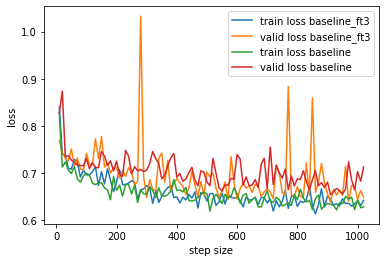

In [ ]:
plt.plot(step_axis_base, train_loss_base_tf3,label='train loss baseline_ft3')
plt.plot(step_axis_base, valid_loss_base_tf3,label='valid loss baseline_ft3')
plt.plot(step_axis_base, train_loss_line_base,label='train loss baseline')
plt.plot(step_axis_base, valid_loss_line_base,label='valid loss baseline')
plt.xlabel('step size')
plt.ylabel('loss')
plt.legend()

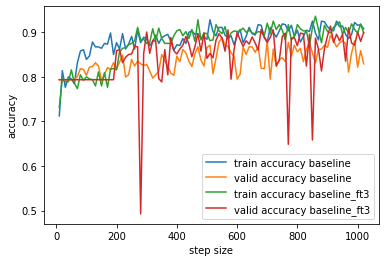

In [ ]:
plt.plot(step_axis_base, train_accu_line_base,label='train accuracy baseline')
plt.plot(step_axis_base, valid_accu_line_base,label='valid accuracy baseline')
plt.plot(step_axis_base, train_accu_base_tf3,label='train accuracy baseline_ft3')
plt.plot(step_axis_base, valid_accu_base_tf3,label='valid accuracy baseline_ft3')


plt.xlabel('step size')
plt.ylabel('accuracy')
plt.legend()

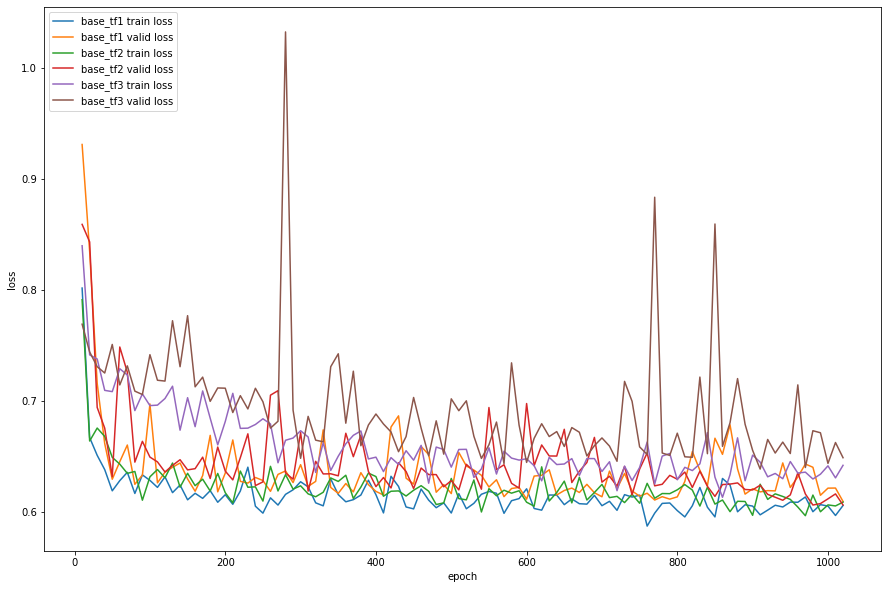

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(step_axis_base, train_loss_base_tf1,label='base_tf1 train loss')
plt.plot(step_axis_base, valid_loss_base_tf1,label='base_tf1 valid loss')

plt.plot(step_axis_base, train_loss_base_tf2,label='base_tf2 train loss')
plt.plot(step_axis_base, valid_loss_base_tf2,label='base_tf2 valid loss')

plt.plot(step_axis_base, train_loss_base_tf3,label='base_tf3 train loss')
plt.plot(step_axis_base, valid_loss_base_tf3,label='base_tf3 valid loss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc = 2)

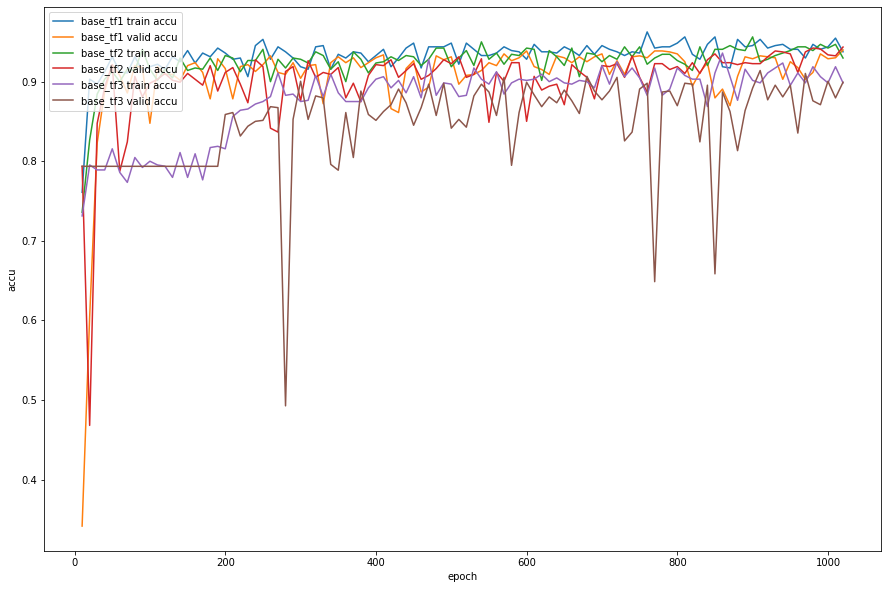

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(step_axis_base, train_accu_base_tf1,label='base_tf1 train accu')
plt.plot(step_axis_base, valid_accu_base_tf1,label='base_tf1 valid accu')

plt.plot(step_axis_base, train_accu_base_tf2,label='base_tf2 train accu')
plt.plot(step_axis_base, valid_accu_base_tf2,label='base_tf2 valid accu')

plt.plot(step_axis_base, train_accu_base_tf3,label='base_tf3 train accu')
plt.plot(step_axis_base, valid_accu_base_tf3,label='base_tf3 valid accu')

plt.xlabel('epoch')
plt.ylabel('accu')
plt.legend(loc = 2)